In [0]:
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

# code from https://github.com/forcecore/Keras-GAN-Animeface-Character

class MinibatchDiscrimination(Layer):
    """Concatenates to each sample information about how different the input
    features for that sample are from features of other samples in the same
    minibatch, as described in Salimans et. al. (2016). Useful for preventing
    GANs from collapsing to a single output. When using this layer, generated
    samples and reference samples should be in separate batches.
    # Example
    ```python
        # apply a convolution 1d of length 3 to a sequence with 10 timesteps,
        # with 64 output filters
        model = Sequential()
        model.add(Convolution1D(64, 3, border_mode='same', input_shape=(10, 32)))
        # now model.output_shape == (None, 10, 64)
        # flatten the output so it can be fed into a minibatch discrimination layer
        model.add(Flatten())
        # now model.output_shape == (None, 640)
        # add the minibatch discrimination layer
        model.add(MinibatchDiscrimination(5, 3))
        # now model.output_shape = (None, 645)
    ```
    # Arguments
        nb_kernels: Number of discrimination kernels to use
            (dimensionality concatenated to output).
        kernel_dim: The dimensionality of the space where closeness of samples
            is calculated.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        weights: list of numpy arrays to set as initial weights.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        input_dim: Number of channels/dimensions in the input.
            Either this argument or the keyword argument `input_shape`must be
            provided when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(samples, input_dim + nb_kernels)`.
    # References
        - [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
    """

    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        # Set built to true.
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [53]:
"""
After several unsuccessful tries to make my own GAN I used working one from here:
https://github.com/King-Of-Knights/Keras-ACGAN-CIFAR10
"""
from __future__ import print_function
import os
from collections import defaultdict

try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image
from six.moves import range
import keras.backend as K
from keras.datasets import cifar10
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar
#from ganVAE.Minibatch import MinibatchDiscrimination
import matplotlib.pyplot as plt
from keras.layers.noise import GaussianNoise
import numpy as np

np.random.seed(1337)
class_num = 10
K.set_image_dim_ordering('th')
path = "images"  # The path to store the generated images
load_weight = True
load_epoch = 73  # Decide which epoch to reload weight, please check your file name
weights_path = 'params_generator_epoch_073.hdf5'



def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 3, 32, 32)
    cnn = Sequential()
    cnn.add(Dense(384 * 4 * 4, input_dim=latent_size, activation='relu',
                  kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(Reshape((384, 4, 4)))
    cnn.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh',
                            kernel_initializer='glorot_normal', bias_initializer='Zeros'))

    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size,))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # 10 classes in CIFAR-10
    cls = Flatten()(Embedding(10, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(GaussianNoise(0.05, input_shape=(3, 32, 32)))  # Add this layer to prevent D from overfitting!

    cnn.add(Conv2D(16, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(32, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(128, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(256, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(512, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='glorot_normal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    cnn.add(MinibatchDiscrimination(50, 30))

    image = Input(shape=(3, 32, 32))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation',
                 kernel_initializer='glorot_normal', bias_initializer='Zeros')(features)
    aux = Dense(class_num, activation='softmax', name='auxiliary',
                kernel_initializer='glorot_normal', bias_initializer='Zeros')(features)

    return Model(image, [fake, aux])


if __name__ == '__main__':

    # batch and latent size taken from the paper
    nb_epochs = 1
    batch_size = 100
    latent_size = 110

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator, Choose Adam as optimizer according to GANHACK
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    generator = build_generator(latent_size)

    latent = Input(shape=(latent_size,))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generator for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    combined.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    nb_train, nb_test = X_train.shape[0], X_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    if load_weight:
        generator.load_weights('params_generator_epoch_{0:03d}.hdf5'.format(load_epoch))
        discriminator.load_weights('params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch))
    else:
        load_epoch = 0

    for epoch in range(nb_epochs):
        print('Epoch {} of {}'.format(load_epoch + 1, nb_epochs))
        load_epoch += 1
        nb_batches = int(X_train.shape[0] / batch_size)
        progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(nb_batches):
            progress_bar.update(index)
            # generate a new batch of noise
            noise = np.random.normal(0, 0.5, (batch_size, latent_size))

            # get a batch of real images
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, class_num, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            disc_real_weight = [np.ones(batch_size), 2 * np.ones(batch_size)]
            disc_fake_weight = [np.ones(batch_size), np.zeros(batch_size)]

            # According to GANHACK, We training our ACGAN-CIFAR10 in Real->D, Fake->D,
            # Noise->G, rather than traditional method: [Real, Fake]->D, Noise->G, actully,
            # it really make sense!

            for train_ix in range(3):
                if index % 30 != 0:
                    X_real = image_batch
                    # Label Soomthing
                    y_real = np.random.uniform(0.7, 1.2, size=(batch_size,))
                    aux_y1 = label_batch.reshape(-1, )
                    epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                    # Label Soomthing
                    X_fake = generated_images
                    y_fake = np.random.uniform(0.0, 0.3, size=(batch_size,))
                    aux_y2 = sampled_labels

                    # see if the discriminator can figure itself out...
                    epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
                else:
                    # make the labels the noisy for the discriminator: occasionally flip the labels
                    # when training the discriminator
                    X_real = image_batch
                    y_real = np.random.uniform(0.0, 0.3, size=(batch_size,))
                    aux_y1 = label_batch.reshape(-1, )

                    epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                    # Label Soomthing
                    X_fake = generated_images
                    y_fake = np.random.uniform(0.7, 1.2, size=(batch_size,))
                    aux_y2 = sampled_labels

                    # see if the discriminator can figure itself out...
                    epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
            # make new noise. we generate Guassian Noise rather than Uniform Noise according to GANHACK
            noise = np.random.normal(0, 0.5, (2 * batch_size, latent_size))
            sampled_labels = np.random.randint(0, class_num, 2 * batch_size)

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.random.uniform(0.7, 1.2, size=(2 * batch_size,))

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

        print('\nTesting for epoch {}:'.format(load_epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.normal(0, 0.5, (nb_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, class_num, nb_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        X = np.concatenate((X_test, generated_images))
        y = np.array([1] * nb_test + [0] * nb_test)
        aux_y = np.concatenate((y_test.reshape(-1, ), sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            X, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.normal(0, 0.5, (2 * nb_test, latent_size))
        sampled_labels = np.random.randint(0, class_num, 2 * nb_test)
        trick = np.ones(2 * nb_test)
        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch), True)

        # generate some pictures to display
        noise = np.random.normal(0, 0.5, (100, latent_size))
        sampled_labels = np.array([
            [i] * 10 for i in range(10)
        ]).reshape(-1, 1)
        generated_images = generator.predict([noise, sampled_labels]).transpose(0, 2, 3, 1)
        generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))


        def vis_square(data, padsize=1, padval=0):

            # force the number of filters to be square
            n = int(np.ceil(np.sqrt(data.shape[0])))
            padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
            data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

            # tile the filters into an image
            data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
            data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
            return data


#         img = vis_square(generated_images)
#         if not os.path.exists(path):
#             os.makedirs(path)
#         Image.fromarray(img).save(
#             'images/plot_epoch_{0:03d}_generated.png'.format(load_epoch))

        pickle.dump({'train': train_history, 'test': test_history},
                        open('acgan-history.pkl', 'wb'))




Epoch 74 of 1
  0/500 [..............................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


499/500 [============================>.] - ETA: 0s
Testing for epoch 74:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.94 | 1.80            | 0.14 
generator (test)       | 14.71 | 1.39            | 13.31
discriminator (train)  | 0.66 | 0.51            | 0.15 
discriminator (test)   | 14.71 | 1.48            | 13.23


In [1]:
!ls

datalab  params_discriminator_epoch_073.hdf5  params_generator_epoch_073.hdf5


In [0]:
def gan_generate_images(amount):
    generator = build_generator(latent_size)
    generator.load_weights(weights_path)
    noise = np.random.normal(0, 0.5, (amount, latent_size))
    sampled_labels = np.array([
        [i] * int(amount/10) for i in range(10)
    ]).reshape(-1, 1)
    generated_images = generator.predict([noise, sampled_labels]).transpose(0, 2, 3, 1)
    generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))

    return generated_images, sampled_labels

In [0]:
generated_im, sampled_labels = generate_images(10000)
generated_im = generated_im.astype('float32')
generated_im /= 255
generated_im = generated_im.transpose(0, 3, 2, 1)
print(generated_im.shape)
print(generated_im)

In [14]:
sampled_labels = keras.utils.to_categorical(sampled_labels, 10)
print(sampled_labels.shape)

(10000, 10)


In [19]:
print(x_train.shape)
print(generated_im.shape)
augmented = np.concatenate((x_train, generated_im))
print(augmented.shape)
augmented_y = np.concatenate((y_train, sampled_labels))
print(augmented_y.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(60000, 3, 32, 32)
(60000, 10)


In [6]:
import keras
from keras.datasets import cifar10, mnist
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 37s 0us/step


In [7]:
NUM_CLASSES  =10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

NUM_CLASSES = 10
#INPUT_SHAPE = x_train.shape[1:]

def build_model(INPUT_SHAPE):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                   padding='same',
                   activation='relu',
                   input_shape=INPUT_SHAPE))
  model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3),
                   padding='same',
                   activation='relu'))
  model.add(Conv2D(64, (3, 3),
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])
  return model




In [10]:
model = build_model([32, 32, 3])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [12]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:100]
y_test = y_test[:100]

model = build_model([32, 32, 3])
model.fit(x_train, y_train,
          batch_size=64,
          callbacks=callbacks_list,
          shuffle = True,
          epochs=50,
          verbose=2,
          validation_data=(x_test, y_test),
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 21s - loss: 1.5675 - acc: 0.4282 - val_loss: 1.1634 - val_acc: 0.5930

Epoch 00001: val_acc improved from -inf to 0.59300, saving model to weights-improvement-01-0.59.hdf5
Epoch 2/50
 - 18s - loss: 1.1578 - acc: 0.5892 - val_loss: 1.0327 - val_acc: 0.6337

Epoch 00002: val_acc improved from 0.59300 to 0.63370, saving model to weights-improvement-02-0.63.hdf5
Epoch 3/50
 - 18s - loss: 0.9886 - acc: 0.6511 - val_loss: 0.8996 - val_acc: 0.6874

Epoch 00003: val_acc improved from 0.63370 to 0.68740, saving model to weights-improvement-03-0.69.hdf5
Epoch 4/50
 - 18s - loss: 0.8951 - acc: 0.6846 - val_loss: 0.7988 - val_acc: 0.7267

Epoch 00004: val_acc improved from 0.68740 to 0.72670, saving model to weights-improvement-04-0.73.hdf5
Epoch 5/50
 - 18s - loss: 0.8192 - acc: 0.7140 - val_loss: 0.7818 - val_acc: 0.7253

Epoch 00005: val_acc did not improve from 0.72670
Epoch 6/50
 - 18s - loss: 0.7626 - acc: 0.7310 - val_loss: 0.7


Epoch 00024: val_acc did not improve from 0.79570
Epoch 25/50
 - 18s - loss: 0.4105 - acc: 0.8547 - val_loss: 0.6444 - val_acc: 0.7935

Epoch 00025: val_acc did not improve from 0.79570
Epoch 26/50
 - 18s - loss: 0.4078 - acc: 0.8556 - val_loss: 0.6422 - val_acc: 0.7955

Epoch 00026: val_acc did not improve from 0.79570
Epoch 27/50
 - 18s - loss: 0.3958 - acc: 0.8591 - val_loss: 0.6448 - val_acc: 0.8010

Epoch 00027: val_acc improved from 0.79570 to 0.80100, saving model to weights-improvement-27-0.80.hdf5
Epoch 28/50
 - 18s - loss: 0.3936 - acc: 0.8614 - val_loss: 0.6585 - val_acc: 0.7934

Epoch 00028: val_acc did not improve from 0.80100
Epoch 29/50
 - 18s - loss: 0.3934 - acc: 0.8603 - val_loss: 0.6623 - val_acc: 0.7917

Epoch 00029: val_acc did not improve from 0.80100
Epoch 30/50
 - 18s - loss: 0.3809 - acc: 0.8647 - val_loss: 0.6302 - val_acc: 0.7955

Epoch 00030: val_acc did not improve from 0.80100
Epoch 31/50
 - 18s - loss: 0.3702 - acc: 0.8693 - val_loss: 0.6592 - val_acc: 0


Epoch 00050: val_acc did not improve from 0.80220
Test loss: 0.6898011532306672
Test accuracy: 0.7949


In [18]:
from keras.preprocessing.image import ImageDataGenerator
model = build_model([32, 32, 3])
datagen = ImageDataGenerator(      
        rotation_range=5,  
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=True,  
        vertical_flip=False)  

model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=64),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    workers=4)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
782/782 [==============================] - 48s 62ms/step - loss: 1.6467 - acc: 0.3927 - val_loss: 1.2563 - val_acc: 0.5455
Epoch 2/50
347/782 [============>.................] - ETA: 25s - loss: 1.3395 - acc: 0.5155

782/782 [==============================] - 47s 60ms/step - loss: 1.2816 - acc: 0.5389 - val_loss: 1.0881 - val_acc: 0.6136
Epoch 3/50
564/782 [====================>.........] - ETA: 12s - loss: 1.1553 - acc: 0.5875

782/782 [==============================] - 47s 60ms/step - loss: 1.1431 - acc: 0.5928 - val_loss: 1.0611 - val_acc: 0.6248
Epoch 4/50
626/782 [=======================>......] - ETA: 9s - loss: 1.0518 - acc: 0.6263

782/782 [==============================] - 46s 59ms/step - loss: 1.0452 - acc: 0.6284 - val_loss: 0.9542 - val_acc: 0.6626
Epoch 5/50
652/782 [========================>.....] - ETA: 7s - loss: 0.9840 - acc: 0.6533

782/782 [==============================] - 46s 59ms/step - loss: 0.9804 - acc: 0.6541 - val_loss: 0.8799 - val_acc: 0.6959
Epoch 6/50
657/782 [========================>.....] - ETA: 7s - loss: 0.9298 - acc: 0.6752

782/782 [==============================] - 46s 59ms/step - loss: 0.9280 - acc: 0.6762 - val_loss: 0.8998 - val_acc: 0.6909
Epoch 7/50
687/782 [=========================>....] - ETA: 5s - loss: 0.8963 - acc: 0.6866

782/782 [==============================] - 46s 59ms/step - loss: 0.8977 - acc: 0.6857 - val_loss: 0.7744 - val_acc: 0.7311
Epoch 8/50
684/782 [=========================>....] - ETA: 5s - loss: 0.8658 - acc: 0.6991

782/782 [==============================] - 46s 59ms/step - loss: 0.8626 - acc: 0.6991 - val_loss: 0.7894 - val_acc: 0.7249
Epoch 9/50
710/782 [==========================>...] - ETA: 4s - loss: 0.8426 - acc: 0.7079

782/782 [==============================] - 46s 59ms/step - loss: 0.8409 - acc: 0.7083 - val_loss: 0.7127 - val_acc: 0.7528
Epoch 10/50
703/782 [=========================>....] - ETA: 4s - loss: 0.8181 - acc: 0.7133

782/782 [==============================] - 46s 59ms/step - loss: 0.8182 - acc: 0.7132 - val_loss: 0.7494 - val_acc: 0.7358
Epoch 11/50
696/782 [=========================>....] - ETA: 4s - loss: 0.8014 - acc: 0.7203

782/782 [==============================] - 46s 58ms/step - loss: 0.8020 - acc: 0.7206 - val_loss: 0.7076 - val_acc: 0.7538
Epoch 12/50
688/782 [=========================>....] - ETA: 5s - loss: 0.7931 - acc: 0.7255

782/782 [==============================] - 46s 58ms/step - loss: 0.7924 - acc: 0.7253 - val_loss: 0.7447 - val_acc: 0.7461
Epoch 13/50
710/782 [==========================>...] - ETA: 4s - loss: 0.7785 - acc: 0.7283

782/782 [==============================] - 46s 59ms/step - loss: 0.7757 - acc: 0.7293 - val_loss: 0.6634 - val_acc: 0.7745
Epoch 14/50
718/782 [==========================>...] - ETA: 3s - loss: 0.7650 - acc: 0.7340

782/782 [==============================] - 46s 59ms/step - loss: 0.7689 - acc: 0.7328 - val_loss: 0.6666 - val_acc: 0.7689
Epoch 15/50
715/782 [==========================>...] - ETA: 3s - loss: 0.7623 - acc: 0.7335

782/782 [==============================] - 46s 59ms/step - loss: 0.7617 - acc: 0.7340 - val_loss: 0.6861 - val_acc: 0.7611
Epoch 16/50
679/782 [=========================>....] - ETA: 5s - loss: 0.7509 - acc: 0.7391

782/782 [==============================] - 46s 59ms/step - loss: 0.7509 - acc: 0.7383 - val_loss: 0.6625 - val_acc: 0.7708
Epoch 17/50
681/782 [=========================>....] - ETA: 5s - loss: 0.7434 - acc: 0.7405

782/782 [==============================] - 46s 59ms/step - loss: 0.7443 - acc: 0.7395 - val_loss: 0.6404 - val_acc: 0.7774
Epoch 18/50
694/782 [=========================>....] - ETA: 4s - loss: 0.7372 - acc: 0.7438

782/782 [==============================] - 46s 58ms/step - loss: 0.7397 - acc: 0.7422 - val_loss: 0.6399 - val_acc: 0.7805
Epoch 19/50
704/782 [==========================>...] - ETA: 4s - loss: 0.7287 - acc: 0.7464

782/782 [==============================] - 45s 58ms/step - loss: 0.7273 - acc: 0.7476 - val_loss: 0.6227 - val_acc: 0.7875
Epoch 20/50
699/782 [=========================>....] - ETA: 4s - loss: 0.7237 - acc: 0.7506

782/782 [==============================] - 46s 58ms/step - loss: 0.7215 - acc: 0.7514 - val_loss: 0.6267 - val_acc: 0.7855
Epoch 21/50
696/782 [=========================>....] - ETA: 4s - loss: 0.7137 - acc: 0.7531

782/782 [==============================] - 46s 58ms/step - loss: 0.7148 - acc: 0.7521 - val_loss: 0.5955 - val_acc: 0.7963
Epoch 22/50
696/782 [=========================>....] - ETA: 4s - loss: 0.7150 - acc: 0.7538

782/782 [==============================] - 46s 59ms/step - loss: 0.7113 - acc: 0.7547 - val_loss: 0.6368 - val_acc: 0.7843
Epoch 23/50
671/782 [========================>.....] - ETA: 6s - loss: 0.7057 - acc: 0.7565

782/782 [==============================] - 46s 58ms/step - loss: 0.7044 - acc: 0.7567 - val_loss: 0.7014 - val_acc: 0.7674
Epoch 24/50
691/782 [=========================>....] - ETA: 5s - loss: 0.6939 - acc: 0.7605

782/782 [==============================] - 45s 58ms/step - loss: 0.6955 - acc: 0.7602 - val_loss: 0.6364 - val_acc: 0.7871
Epoch 25/50
682/782 [=========================>....] - ETA: 5s - loss: 0.6894 - acc: 0.7602

782/782 [==============================] - 46s 58ms/step - loss: 0.6911 - acc: 0.7602 - val_loss: 0.5961 - val_acc: 0.8009
Epoch 26/50
662/782 [========================>.....] - ETA: 6s - loss: 0.6889 - acc: 0.7631

782/782 [==============================] - 46s 59ms/step - loss: 0.6920 - acc: 0.7604 - val_loss: 0.6145 - val_acc: 0.7901
Epoch 27/50
696/782 [=========================>....] - ETA: 4s - loss: 0.6823 - acc: 0.7651

782/782 [==============================] - 45s 58ms/step - loss: 0.6833 - acc: 0.7648 - val_loss: 0.6102 - val_acc: 0.7918
Epoch 28/50
700/782 [=========================>....] - ETA: 4s - loss: 0.6872 - acc: 0.7602

782/782 [==============================] - 45s 58ms/step - loss: 0.6841 - acc: 0.7612 - val_loss: 0.6064 - val_acc: 0.7977
Epoch 29/50
667/782 [========================>.....] - ETA: 6s - loss: 0.6770 - acc: 0.7642

782/782 [==============================] - 46s 58ms/step - loss: 0.6788 - acc: 0.7639 - val_loss: 0.6408 - val_acc: 0.7816
Epoch 30/50
681/782 [=========================>....] - ETA: 5s - loss: 0.6726 - acc: 0.7679

782/782 [==============================] - 46s 59ms/step - loss: 0.6762 - acc: 0.7662 - val_loss: 0.6545 - val_acc: 0.7794
Epoch 31/50
669/782 [========================>.....] - ETA: 6s - loss: 0.6677 - acc: 0.7677

782/782 [==============================] - 45s 58ms/step - loss: 0.6691 - acc: 0.7676 - val_loss: 0.5662 - val_acc: 0.8056
Epoch 32/50
672/782 [========================>.....] - ETA: 6s - loss: 0.6642 - acc: 0.7712

782/782 [==============================] - 45s 58ms/step - loss: 0.6662 - acc: 0.7704 - val_loss: 0.5510 - val_acc: 0.8114
Epoch 33/50
661/782 [========================>.....] - ETA: 6s - loss: 0.6598 - acc: 0.7731

782/782 [==============================] - 45s 58ms/step - loss: 0.6654 - acc: 0.7717 - val_loss: 0.6285 - val_acc: 0.7919
Epoch 34/50
678/782 [=========================>....] - ETA: 5s - loss: 0.6566 - acc: 0.7738

782/782 [==============================] - 46s 58ms/step - loss: 0.6575 - acc: 0.7732 - val_loss: 0.5818 - val_acc: 0.8035
Epoch 35/50
655/782 [========================>.....] - ETA: 7s - loss: 0.6579 - acc: 0.7729

782/782 [==============================] - 46s 58ms/step - loss: 0.6551 - acc: 0.7745 - val_loss: 0.5895 - val_acc: 0.8022
Epoch 36/50
680/782 [=========================>....] - ETA: 5s - loss: 0.6558 - acc: 0.7754

782/782 [==============================] - 45s 58ms/step - loss: 0.6558 - acc: 0.7753 - val_loss: 0.6079 - val_acc: 0.7947
Epoch 37/50
685/782 [=========================>....] - ETA: 5s - loss: 0.6565 - acc: 0.7740

782/782 [==============================] - 46s 59ms/step - loss: 0.6582 - acc: 0.7737 - val_loss: 0.6113 - val_acc: 0.7904
Epoch 38/50
683/782 [=========================>....] - ETA: 5s - loss: 0.6478 - acc: 0.7756

782/782 [==============================] - 46s 58ms/step - loss: 0.6503 - acc: 0.7752 - val_loss: 0.6289 - val_acc: 0.7845
Epoch 39/50
710/782 [==========================>...] - ETA: 4s - loss: 0.6478 - acc: 0.7752

782/782 [==============================] - 45s 58ms/step - loss: 0.6469 - acc: 0.7760 - val_loss: 0.6326 - val_acc: 0.7901
Epoch 40/50
678/782 [=========================>....] - ETA: 5s - loss: 0.6428 - acc: 0.7772

782/782 [==============================] - 46s 58ms/step - loss: 0.6443 - acc: 0.7764 - val_loss: 0.5971 - val_acc: 0.7975
Epoch 41/50
696/782 [=========================>....] - ETA: 4s - loss: 0.6369 - acc: 0.7803

782/782 [==============================] - 45s 58ms/step - loss: 0.6380 - acc: 0.7792 - val_loss: 0.6108 - val_acc: 0.7975
Epoch 42/50
677/782 [========================>.....] - ETA: 5s - loss: 0.6353 - acc: 0.7792

782/782 [==============================] - 46s 58ms/step - loss: 0.6360 - acc: 0.7791 - val_loss: 0.5663 - val_acc: 0.8140
Epoch 43/50
682/782 [=========================>....] - ETA: 5s - loss: 0.6388 - acc: 0.7787

782/782 [==============================] - 45s 58ms/step - loss: 0.6414 - acc: 0.7783 - val_loss: 0.6135 - val_acc: 0.7917
Epoch 44/50
669/782 [========================>.....] - ETA: 6s - loss: 0.6447 - acc: 0.7754

782/782 [==============================] - 45s 58ms/step - loss: 0.6459 - acc: 0.7761 - val_loss: 0.6121 - val_acc: 0.7941
Epoch 45/50
682/782 [=========================>....] - ETA: 5s - loss: 0.6310 - acc: 0.7829

782/782 [==============================] - 45s 58ms/step - loss: 0.6329 - acc: 0.7826 - val_loss: 0.5812 - val_acc: 0.8062
Epoch 46/50
683/782 [=========================>....] - ETA: 5s - loss: 0.6252 - acc: 0.7847

782/782 [==============================] - 45s 58ms/step - loss: 0.6257 - acc: 0.7850 - val_loss: 0.6318 - val_acc: 0.7882
Epoch 47/50
701/782 [=========================>....] - ETA: 4s - loss: 0.6284 - acc: 0.7848

782/782 [==============================] - 45s 58ms/step - loss: 0.6308 - acc: 0.7839 - val_loss: 0.5696 - val_acc: 0.8083
Epoch 48/50
706/782 [==========================>...] - ETA: 4s - loss: 0.6263 - acc: 0.7813

782/782 [==============================] - 45s 58ms/step - loss: 0.6256 - acc: 0.7813 - val_loss: 0.5501 - val_acc: 0.8120
Epoch 49/50
709/782 [==========================>...] - ETA: 4s - loss: 0.6310 - acc: 0.7830

782/782 [==============================] - 45s 57ms/step - loss: 0.6290 - acc: 0.7831 - val_loss: 0.6398 - val_acc: 0.7884
Epoch 50/50
710/782 [==========================>...] - ETA: 4s - loss: 0.6215 - acc: 0.7846

782/782 [==============================] - 45s 58ms/step - loss: 0.6220 - acc: 0.7842 - val_loss: 0.5670 - val_acc: 0.8074
Test loss: 0.566950496339798
Test accuracy: 0.8074


In [59]:
print(x_train.shape[1:])

(3072,)


In [18]:
print(x_train.shape)
print(fake.shape)

(40000, 32, 32, 3)
(10000, 3, 32, 32)


In [30]:
from keras.datasets import cifar10, mnist
import numpy as np
import sys
import keras
#datasets = ['mnist', 'cifar10', 'caltech101']
dataset = 'cifar10'
num_images = 50000
#baseline = build_model(data_augmentation = False, dataset = dataset)
#typical_aug = build_model(data_augmentation = True, dataset = dataset)
#vae_add_near =
#vae_add_random =
#import gan_working as gan
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
scores = []
losses = []

models_to_compare = ['vae']#, vae_add_near, vae_add_random, gan]
fake_ratio = [0.2, 0.4, 0.6, 0.8]
for model in models_to_compare:
  for ratio in fake_ratio:
      print('Ratio: {}'.format(ratio))
      
      (x_train, y_train), (x_test, y_test) = cifar10.load_data()
      test_model = build_model(x_train.shape[1:])#build_model(data_augmentation = False, dataset = dataset)
      x_train = x_train[:int(num_images*(1 - ratio))]
      y_train = y_train[:int(num_images*(1 - ratio))]
      if (model =='gan'):
        fake, sampled_labels = gan_generate_images(int(num_images*ratio))
        print(fake)
        fake /= 255
        #fake = fake.transpose(0, 3, 2, 1)
      elif (model == 'vae'):
        fake, sampled_labels = generate_images_vae(int(num_images*ratio))
      fake = fake.astype('float32')
      
      

      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')
      x_train /= 255
      x_test /= 255
      augmented = np.concatenate((x_train, fake))
      print(augmented.shape)
      augmented_y = np.concatenate((y_train, sampled_labels))
      augmented_y = keras.utils.to_categorical(augmented_y, 10)
      y_test = keras.utils.to_categorical(y_test, 10)
      print(augmented_y.shape)
      test_model.fit(augmented, augmented_y,
                shuffle = True,
                batch_size=64,
                epochs=50,
                verbose=2,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)
      test_model.save_weights(
          'cifar-model-{}-ratio-{}-fake.hdf5'.format(model,ratio), True)
      score = test_model.evaluate(x_test, y_test, verbose=0)
      print('model-{}-fake.hdf5'.format(ratio))
      print('Test loss:', score[0])
      scores.append(score[0])
      print('Test accuracy:', score[1])
      losses.append(score[1])

    

Ratio: 0.2
per image 1 generated
(50000, 32, 32, 3)
(50000, 10)
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 20s - loss: 1.7038 - acc: 0.3768 - val_loss: 1.3608 - val_acc: 0.5050

Epoch 00001: val_acc improved from -inf to 0.50500, saving model to weights-improvement-01-0.51.hdf5
Epoch 2/50
 - 18s - loss: 1.3783 - acc: 0.5052 - val_loss: 1.0630 - val_acc: 0.6229

Epoch 00002: val_acc improved from 0.50500 to 0.62290, saving model to weights-improvement-02-0.62.hdf5
Epoch 3/50
 - 18s - loss: 1.2302 - acc: 0.5613 - val_loss: 1.0017 - val_acc: 0.6515

Epoch 00003: val_acc improved from 0.62290 to 0.65150, saving model to weights-improvement-03-0.65.hdf5
Epoch 4/50
 - 19s - loss: 1.1381 - acc: 0.5961 - val_loss: 0.8852 - val_acc: 0.6937

Epoch 00004: val_acc improved from 0.65150 to 0.69370, saving model to weights-improvement-04-0.69.hdf5
Epoch 5/50
 - 18s - loss: 1.0689 - acc: 0.6219 - val_loss: 0.8154 - val_acc: 0.7149

Epoch 00005: val_acc improved from 0.69370 to 0.


Epoch 00023: val_acc did not improve from 0.77730
Epoch 24/50
 - 18s - loss: 0.6871 - acc: 0.7543 - val_loss: 0.7009 - val_acc: 0.7755

Epoch 00024: val_acc did not improve from 0.77730
Epoch 25/50
 - 18s - loss: 0.6733 - acc: 0.7576 - val_loss: 0.7244 - val_acc: 0.7692

Epoch 00025: val_acc did not improve from 0.77730
Epoch 26/50
 - 18s - loss: 0.6728 - acc: 0.7576 - val_loss: 0.7138 - val_acc: 0.7741

Epoch 00026: val_acc did not improve from 0.77730
Epoch 27/50
 - 18s - loss: 0.6606 - acc: 0.7628 - val_loss: 0.6775 - val_acc: 0.7786

Epoch 00027: val_acc improved from 0.77730 to 0.77860, saving model to weights-improvement-27-0.78.hdf5
Epoch 28/50
 - 18s - loss: 0.6618 - acc: 0.7614 - val_loss: 0.6959 - val_acc: 0.7745

Epoch 00028: val_acc did not improve from 0.77860
Epoch 29/50
 - 18s - loss: 0.6627 - acc: 0.7622 - val_loss: 0.6912 - val_acc: 0.7762

Epoch 00029: val_acc did not improve from 0.77860
Epoch 30/50
 - 18s - loss: 0.6463 - acc: 0.7677 - val_loss: 0.7161 - val_acc: 0


Epoch 00049: val_acc improved from 0.78090 to 0.78340, saving model to weights-improvement-49-0.78.hdf5
Epoch 50/50
 - 17s - loss: 0.5820 - acc: 0.7921 - val_loss: 0.7601 - val_acc: 0.7724

Epoch 00050: val_acc did not improve from 0.78340
model-0.2-fake.hdf5
Test loss: 0.7600538200855255
Test accuracy: 0.7724
Ratio: 0.4
per image 2 generated
(50000, 32, 32, 3)
(50000, 10)
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 20s - loss: 1.7626 - acc: 0.3525 - val_loss: 1.3693 - val_acc: 0.5114

Epoch 00001: val_acc did not improve from 0.78340
Epoch 2/50
 - 18s - loss: 1.5130 - acc: 0.4553 - val_loss: 1.1121 - val_acc: 0.6066

Epoch 00002: val_acc did not improve from 0.78340
Epoch 3/50
 - 19s - loss: 1.4030 - acc: 0.4968 - val_loss: 1.0007 - val_acc: 0.6532

Epoch 00003: val_acc did not improve from 0.78340
Epoch 4/50
 - 18s - loss: 1.3244 - acc: 0.5260 - val_loss: 0.9277 - val_acc: 0.6784

Epoch 00004: val_acc did not improve from 0.78340
Epoch 5/50
 - 19s - loss: 1.2604 


Epoch 00024: val_acc did not improve from 0.78340
Epoch 25/50
 - 18s - loss: 0.8546 - acc: 0.6907 - val_loss: 0.8632 - val_acc: 0.7394

Epoch 00025: val_acc did not improve from 0.78340
Epoch 26/50
 - 18s - loss: 0.8480 - acc: 0.6932 - val_loss: 0.8466 - val_acc: 0.7397

Epoch 00026: val_acc did not improve from 0.78340
Epoch 27/50
 - 18s - loss: 0.8436 - acc: 0.6944 - val_loss: 0.7989 - val_acc: 0.7486

Epoch 00027: val_acc did not improve from 0.78340
Epoch 28/50
 - 18s - loss: 0.8376 - acc: 0.6976 - val_loss: 0.8004 - val_acc: 0.7499

Epoch 00028: val_acc did not improve from 0.78340
Epoch 29/50
 - 18s - loss: 0.8179 - acc: 0.7006 - val_loss: 0.8341 - val_acc: 0.7515

Epoch 00029: val_acc did not improve from 0.78340
Epoch 30/50
 - 18s - loss: 0.8020 - acc: 0.7088 - val_loss: 0.8447 - val_acc: 0.7454

Epoch 00030: val_acc did not improve from 0.78340
Epoch 31/50
 - 18s - loss: 0.7984 - acc: 0.7109 - val_loss: 0.8303 - val_acc: 0.7498

Epoch 00031: val_acc did not improve from 0.783

model-0.4-fake.hdf5
Test loss: 0.9473607071876526
Test accuracy: 0.7387
Ratio: 0.6
per image 3 generated
(50000, 32, 32, 3)
(50000, 10)
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 20s - loss: 1.8624 - acc: 0.3118 - val_loss: 1.4649 - val_acc: 0.4645

Epoch 00001: val_acc did not improve from 0.78340
Epoch 2/50
 - 19s - loss: 1.6697 - acc: 0.3959 - val_loss: 1.3783 - val_acc: 0.5087

Epoch 00002: val_acc did not improve from 0.78340
Epoch 3/50
 - 19s - loss: 1.5826 - acc: 0.4276 - val_loss: 1.1996 - val_acc: 0.5784

Epoch 00003: val_acc did not improve from 0.78340
Epoch 4/50
 - 19s - loss: 1.5179 - acc: 0.4509 - val_loss: 1.1661 - val_acc: 0.5858

Epoch 00004: val_acc did not improve from 0.78340
Epoch 5/50
 - 18s - loss: 1.4679 - acc: 0.4716 - val_loss: 1.0929 - val_acc: 0.6102

Epoch 00005: val_acc did not improve from 0.78340
Epoch 6/50
 - 19s - loss: 1.4244 - acc: 0.4851 - val_loss: 1.0491 - val_acc: 0.6276

Epoch 00006: val_acc did not improve from 0.78340
Epoc

 - 19s - loss: 0.9113 - acc: 0.6672 - val_loss: 1.1225 - val_acc: 0.6617

Epoch 00026: val_acc did not improve from 0.78340
Epoch 27/50
 - 18s - loss: 0.8991 - acc: 0.6717 - val_loss: 1.1058 - val_acc: 0.6730

Epoch 00027: val_acc did not improve from 0.78340
Epoch 28/50
 - 19s - loss: 0.8884 - acc: 0.6770 - val_loss: 1.0643 - val_acc: 0.6713

Epoch 00028: val_acc did not improve from 0.78340
Epoch 29/50
 - 19s - loss: 0.8698 - acc: 0.6805 - val_loss: 1.0531 - val_acc: 0.6640

Epoch 00029: val_acc did not improve from 0.78340
Epoch 30/50
 - 19s - loss: 0.8537 - acc: 0.6888 - val_loss: 1.1103 - val_acc: 0.6671

Epoch 00030: val_acc did not improve from 0.78340
Epoch 31/50
 - 18s - loss: 0.8358 - acc: 0.6925 - val_loss: 1.0723 - val_acc: 0.6642

Epoch 00031: val_acc did not improve from 0.78340
Epoch 32/50
 - 19s - loss: 0.8265 - acc: 0.6999 - val_loss: 1.1287 - val_acc: 0.6681

Epoch 00032: val_acc did not improve from 0.78340
Epoch 33/50
 - 18s - loss: 0.8117 - acc: 0.7032 - val_loss: 

Train on 49999 samples, validate on 10000 samples
Epoch 1/50
 - 20s - loss: 1.9008 - acc: 0.3032 - val_loss: 1.6283 - val_acc: 0.4122

Epoch 00001: val_acc did not improve from 0.78340
Epoch 2/50
 - 19s - loss: 1.7368 - acc: 0.3691 - val_loss: 1.4960 - val_acc: 0.4622

Epoch 00002: val_acc did not improve from 0.78340
Epoch 3/50
 - 19s - loss: 1.6703 - acc: 0.3952 - val_loss: 1.4695 - val_acc: 0.4736

Epoch 00003: val_acc did not improve from 0.78340
Epoch 4/50
 - 19s - loss: 1.6071 - acc: 0.4187 - val_loss: 1.4132 - val_acc: 0.4900

Epoch 00004: val_acc did not improve from 0.78340
Epoch 5/50
 - 19s - loss: 1.5519 - acc: 0.4376 - val_loss: 1.3925 - val_acc: 0.5000

Epoch 00005: val_acc did not improve from 0.78340
Epoch 6/50
 - 19s - loss: 1.4894 - acc: 0.4611 - val_loss: 1.3564 - val_acc: 0.5180

Epoch 00006: val_acc did not improve from 0.78340
Epoch 7/50
 - 19s - loss: 1.4323 - acc: 0.4830 - val_loss: 1.3744 - val_acc: 0.5177

Epoch 00007: val_acc did not improve from 0.78340
Epoch

 - 18s - loss: 0.6437 - acc: 0.7645 - val_loss: 1.7020 - val_acc: 0.5208

Epoch 00027: val_acc did not improve from 0.78340
Epoch 28/50
 - 18s - loss: 0.6341 - acc: 0.7694 - val_loss: 1.7409 - val_acc: 0.5184

Epoch 00028: val_acc did not improve from 0.78340
Epoch 29/50
 - 19s - loss: 0.6193 - acc: 0.7748 - val_loss: 1.7126 - val_acc: 0.5193

Epoch 00029: val_acc did not improve from 0.78340
Epoch 30/50
 - 18s - loss: 0.6044 - acc: 0.7784 - val_loss: 1.7465 - val_acc: 0.5229

Epoch 00030: val_acc did not improve from 0.78340
Epoch 31/50
 - 18s - loss: 0.5906 - acc: 0.7842 - val_loss: 1.7372 - val_acc: 0.5150

Epoch 00031: val_acc did not improve from 0.78340
Epoch 32/50
 - 18s - loss: 0.5763 - acc: 0.7915 - val_loss: 1.7492 - val_acc: 0.5159

Epoch 00032: val_acc did not improve from 0.78340
Epoch 33/50
 - 19s - loss: 0.5714 - acc: 0.7936 - val_loss: 1.7231 - val_acc: 0.5172

Epoch 00033: val_acc did not improve from 0.78340
Epoch 34/50
 - 18s - loss: 0.5624 - acc: 0.7967 - val_loss: 

In [92]:
from keras.datasets import cifar10, mnist
import numpy as np
import sys
import keras
#datasets = ['mnist', 'cifar10', 'caltech101']
dataset = 'cifar10'
num_images = 500
#baseline = build_model(data_augmentation = False, dataset = dataset)
#typical_aug = build_model(data_augmentation = True, dataset = dataset)
#vae_add_near =
#vae_add_random =
#import gan_working as gan
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
scores = []
losses = []

models_to_compare = ['vae', 'gan']#, vae_add_near, vae_add_random, gan]
fake_ratio = [0.2, 0.4, 0.6, 0.8]
for model in models_to_compare:
  for ratio in fake_ratio:
      print('Ratio: {}'.format(ratio))
      
      (x_train, y_train), (x_test, y_test) = cifar10.load_data()
      test_model = build_model(x_train.shape[1:])#build_model(data_augmentation = False, dataset = dataset)
      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')
      x_train /= 255.
      x_test /= 255.
      if (model =='gan'):
        fake, sampled_labels = gan_generate_images(int(num_images*ratio))
        fake = fake.astype('float32')
        print(fake.shape)
        fake /= 255.
        #fake = fake.transpose(0, 3, 2, 1)
      elif (model == 'vae'):
        temp_x_train = x_train
        temp_x_test = x_test
        if (x_train[0].shape == (3, 32, 32)):
          temp_x_train = x_train.transpose(0, 3, 2, 1)
          temp_x_test = x_test.transpose(0, 3, 2, 1)
        temp_x_train = temp_x_train.reshape(-1, original_dim)
        temp_x_test = temp_x_test.reshape(-1, original_dim)
        fake, sampled_labels = generate_images_vae(temp_x_train[:int(num_images*ratio/4)+2],y_train[:int(num_images*ratio/4)+2],int(num_images*ratio))
        fake = fake.astype('float32')
      fake = fake.transpose(0, 3, 2, 1)
      
      x_train = x_train[:int(num_images*(1 - ratio))]
      y_train = y_train[:int(num_images*(1 - ratio))]
      x_test = x_test[:int(num_images*0.2)]
      y_test = y_test[:int(num_images*0.2)]

      
      print(x_train.shape)
      print(fake.shape)
      augmented = np.concatenate((x_train, fake))
      print(augmented.shape)
      augmented_y = np.concatenate((y_train, sampled_labels))
      augmented_y = keras.utils.to_categorical(augmented_y, 10)
      y_test = keras.utils.to_categorical(y_test, 10)
      print(augmented_y.shape)
      test_model.fit(augmented, augmented_y,
                shuffle = True,
                batch_size=64,
                epochs=25,
                verbose=2,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)
      test_model.save_weights(
          'cifar-model-{}-ratio-{}-fake.hdf5'.format(model,ratio), True)
      score = test_model.evaluate(x_test, y_test, verbose=0)
      print('model-{}-fake.hdf5'.format(ratio))
      print('Test loss:', score[0])
      scores.append(score[0])
      print('Test accuracy:', score[1])
      losses.append(score[1])

    

Ratio: 0.2
per image 3 generated
(400, 3, 32, 32)
(100, 3, 32, 32)
(500, 3, 32, 32)
(500, 10)
Train on 500 samples, validate on 100 samples
Epoch 1/25
 - 4s - loss: 2.2971 - acc: 0.1460 - val_loss: 2.3134 - val_acc: 0.0600

Epoch 00001: val_acc improved from -inf to 0.06000, saving model to weights-improvement-01-0.06.hdf5
Epoch 2/25
 - 0s - loss: 2.2780 - acc: 0.1360 - val_loss: 2.2950 - val_acc: 0.0900

Epoch 00002: val_acc improved from 0.06000 to 0.09000, saving model to weights-improvement-02-0.09.hdf5
Epoch 3/25
 - 0s - loss: 2.2517 - acc: 0.1900 - val_loss: 2.2642 - val_acc: 0.2000

Epoch 00003: val_acc improved from 0.09000 to 0.20000, saving model to weights-improvement-03-0.20.hdf5
Epoch 4/25
 - 0s - loss: 2.1944 - acc: 0.2100 - val_loss: 2.1871 - val_acc: 0.2700

Epoch 00004: val_acc improved from 0.20000 to 0.27000, saving model to weights-improvement-04-0.27.hdf5
Epoch 5/25
 - 0s - loss: 2.0678 - acc: 0.2300 - val_loss: 2.1201 - val_acc: 0.2800

Epoch 00005: val_acc improv

 - 0s - loss: 0.4684 - acc: 0.8380 - val_loss: 2.8934 - val_acc: 0.3600

Epoch 00024: val_acc did not improve from 0.39000
Epoch 25/25
 - 0s - loss: 0.4792 - acc: 0.8460 - val_loss: 2.7829 - val_acc: 0.3800

Epoch 00025: val_acc did not improve from 0.39000
model-0.2-fake.hdf5
Test loss: 2.7829026794433593
Test accuracy: 0.38
Ratio: 0.4
per image 3 generated
(300, 3, 32, 32)
(200, 3, 32, 32)
(500, 3, 32, 32)
(500, 10)
Train on 500 samples, validate on 100 samples
Epoch 1/25
 - 4s - loss: 2.2934 - acc: 0.1220 - val_loss: 2.3042 - val_acc: 0.0600

Epoch 00001: val_acc did not improve from 0.39000
Epoch 2/25
 - 0s - loss: 2.2709 - acc: 0.1780 - val_loss: 2.3127 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.39000
Epoch 3/25
 - 0s - loss: 2.2360 - acc: 0.1600 - val_loss: 2.2484 - val_acc: 0.2000

Epoch 00003: val_acc did not improve from 0.39000
Epoch 4/25
 - 0s - loss: 2.1471 - acc: 0.2280 - val_loss: 2.0932 - val_acc: 0.2300

Epoch 00004: val_acc did not improve from 0.39

 - 0s - loss: 0.4829 - acc: 0.8380 - val_loss: 2.7844 - val_acc: 0.3400

Epoch 00024: val_acc did not improve from 0.39000
Epoch 25/25
 - 0s - loss: 0.3365 - acc: 0.8900 - val_loss: 3.1264 - val_acc: 0.2900

Epoch 00025: val_acc did not improve from 0.39000
model-0.4-fake.hdf5
Test loss: 3.1264034271240235
Test accuracy: 0.29
Ratio: 0.6
per image 3 generated
(200, 3, 32, 32)
(300, 3, 32, 32)
(500, 3, 32, 32)
(500, 10)
Train on 500 samples, validate on 100 samples
Epoch 1/25
 - 4s - loss: 2.2991 - acc: 0.1360 - val_loss: 2.3236 - val_acc: 0.0800

Epoch 00001: val_acc did not improve from 0.39000
Epoch 2/25
 - 0s - loss: 2.2596 - acc: 0.1620 - val_loss: 2.3293 - val_acc: 0.1200

Epoch 00002: val_acc did not improve from 0.39000
Epoch 3/25
 - 0s - loss: 2.2222 - acc: 0.1740 - val_loss: 2.2504 - val_acc: 0.1600

Epoch 00003: val_acc did not improve from 0.39000
Epoch 4/25
 - 0s - loss: 2.1421 - acc: 0.2200 - val_loss: 2.1497 - val_acc: 0.2300

Epoch 00004: val_acc did not improve from 0.39

 - 0s - loss: 0.3853 - acc: 0.8660 - val_loss: 3.6934 - val_acc: 0.2000

Epoch 00024: val_acc did not improve from 0.39000
Epoch 25/25
 - 0s - loss: 0.3798 - acc: 0.8760 - val_loss: 3.6072 - val_acc: 0.1900

Epoch 00025: val_acc did not improve from 0.39000
model-0.6-fake.hdf5
Test loss: 3.6072179317474364
Test accuracy: 0.19
Ratio: 0.8
per image 3 generated
(99, 3, 32, 32)
(400, 3, 32, 32)
(499, 3, 32, 32)
(499, 10)
Train on 499 samples, validate on 100 samples
Epoch 1/25
 - 4s - loss: 2.2798 - acc: 0.1263 - val_loss: 2.3346 - val_acc: 0.0600

Epoch 00001: val_acc did not improve from 0.39000
Epoch 2/25
 - 0s - loss: 2.2527 - acc: 0.1563 - val_loss: 2.3594 - val_acc: 0.1100

Epoch 00002: val_acc did not improve from 0.39000
Epoch 3/25
 - 0s - loss: 2.2156 - acc: 0.1683 - val_loss: 2.4310 - val_acc: 0.0700

Epoch 00003: val_acc did not improve from 0.39000
Epoch 4/25
 - 0s - loss: 2.1876 - acc: 0.1683 - val_loss: 2.3260 - val_acc: 0.0900

Epoch 00004: val_acc did not improve from 0.390

 - 0s - loss: 0.2627 - acc: 0.8918 - val_loss: 6.4108 - val_acc: 0.1500

Epoch 00024: val_acc did not improve from 0.39000
Epoch 25/25
 - 0s - loss: 0.2310 - acc: 0.9259 - val_loss: 6.4184 - val_acc: 0.1600

Epoch 00025: val_acc did not improve from 0.39000
model-0.8-fake.hdf5
Test loss: 6.418364372253418
Test accuracy: 0.16
Ratio: 0.2
(100, 32, 32, 3)
(400, 3, 32, 32)
(100, 3, 32, 32)
(500, 3, 32, 32)
(500, 10)
Train on 500 samples, validate on 100 samples
Epoch 1/25
 - 4s - loss: 2.3059 - acc: 0.1340 - val_loss: 2.2953 - val_acc: 0.0600

Epoch 00001: val_acc did not improve from 0.39000
Epoch 2/25
 - 0s - loss: 2.2773 - acc: 0.1380 - val_loss: 2.2571 - val_acc: 0.0600

Epoch 00002: val_acc did not improve from 0.39000
Epoch 3/25
 - 0s - loss: 2.1895 - acc: 0.1800 - val_loss: 2.0360 - val_acc: 0.3000

Epoch 00003: val_acc did not improve from 0.39000
Epoch 4/25
 - 0s - loss: 2.1349 - acc: 0.2280 - val_loss: 2.0438 - val_acc: 0.3200

Epoch 00004: val_acc did not improve from 0.39000
Ep


Epoch 00023: val_acc did not improve from 0.45000
Epoch 24/25
 - 0s - loss: 0.6750 - acc: 0.7740 - val_loss: 2.1617 - val_acc: 0.4100

Epoch 00024: val_acc did not improve from 0.45000
Epoch 25/25
 - 0s - loss: 0.4877 - acc: 0.8420 - val_loss: 2.3725 - val_acc: 0.4000

Epoch 00025: val_acc did not improve from 0.45000
model-0.2-fake.hdf5
Test loss: 2.372521090507507
Test accuracy: 0.4
Ratio: 0.4
(200, 32, 32, 3)
(300, 3, 32, 32)
(200, 3, 32, 32)
(500, 3, 32, 32)
(500, 10)
Train on 500 samples, validate on 100 samples
Epoch 1/25
 - 5s - loss: 2.3143 - acc: 0.0940 - val_loss: 2.2916 - val_acc: 0.0900

Epoch 00001: val_acc did not improve from 0.45000
Epoch 2/25
 - 0s - loss: 2.2821 - acc: 0.1160 - val_loss: 2.2649 - val_acc: 0.0700

Epoch 00002: val_acc did not improve from 0.45000
Epoch 3/25
 - 0s - loss: 2.2403 - acc: 0.1780 - val_loss: 2.2116 - val_acc: 0.2900

Epoch 00003: val_acc did not improve from 0.45000
Epoch 4/25
 - 0s - loss: 2.1592 - acc: 0.2280 - val_loss: 2.1933 - val_acc

 - 0s - loss: 0.8888 - acc: 0.7020 - val_loss: 2.2543 - val_acc: 0.3500

Epoch 00024: val_acc did not improve from 0.45000
Epoch 25/25
 - 0s - loss: 0.7871 - acc: 0.7220 - val_loss: 2.3409 - val_acc: 0.3300

Epoch 00025: val_acc did not improve from 0.45000
model-0.4-fake.hdf5
Test loss: 2.3409073734283448
Test accuracy: 0.33
Ratio: 0.6
(300, 32, 32, 3)
(200, 3, 32, 32)
(300, 3, 32, 32)
(500, 3, 32, 32)
(500, 10)
Train on 500 samples, validate on 100 samples
Epoch 1/25
 - 5s - loss: 2.3183 - acc: 0.0800 - val_loss: 2.2995 - val_acc: 0.0900

Epoch 00001: val_acc did not improve from 0.45000
Epoch 2/25
 - 0s - loss: 2.2835 - acc: 0.1380 - val_loss: 2.2725 - val_acc: 0.0600

Epoch 00002: val_acc did not improve from 0.45000
Epoch 3/25
 - 0s - loss: 2.1962 - acc: 0.1340 - val_loss: 2.0932 - val_acc: 0.2700

Epoch 00003: val_acc did not improve from 0.45000
Epoch 4/25
 - 0s - loss: 2.1379 - acc: 0.1800 - val_loss: 2.0520 - val_acc: 0.2800

Epoch 00004: val_acc did not improve from 0.45000
E

 - 0s - loss: 0.3702 - acc: 0.8700 - val_loss: 3.3242 - val_acc: 0.2800

Epoch 00024: val_acc did not improve from 0.45000
Epoch 25/25
 - 0s - loss: 0.3927 - acc: 0.8580 - val_loss: 3.2199 - val_acc: 0.2400

Epoch 00025: val_acc did not improve from 0.45000
model-0.6-fake.hdf5
Test loss: 3.2199129557609556
Test accuracy: 0.24
Ratio: 0.8
(400, 32, 32, 3)
(99, 3, 32, 32)
(400, 3, 32, 32)
(499, 3, 32, 32)
(499, 10)
Train on 499 samples, validate on 100 samples
Epoch 1/25
 - 5s - loss: 2.3045 - acc: 0.0922 - val_loss: 2.2787 - val_acc: 0.0700

Epoch 00001: val_acc did not improve from 0.45000
Epoch 2/25
 - 0s - loss: 2.2289 - acc: 0.1643 - val_loss: 2.1303 - val_acc: 0.2400

Epoch 00002: val_acc did not improve from 0.45000
Epoch 3/25
 - 0s - loss: 2.1285 - acc: 0.1984 - val_loss: 2.1626 - val_acc: 0.1600

Epoch 00003: val_acc did not improve from 0.45000
Epoch 4/25
 - 0s - loss: 2.0693 - acc: 0.2184 - val_loss: 2.1313 - val_acc: 0.3000

Epoch 00004: val_acc did not improve from 0.45000
Ep

 - 0s - loss: 0.6265 - acc: 0.7796 - val_loss: 2.5564 - val_acc: 0.2500

Epoch 00024: val_acc did not improve from 0.45000
Epoch 25/25
 - 0s - loss: 0.4905 - acc: 0.8357 - val_loss: 3.2876 - val_acc: 0.2300

Epoch 00025: val_acc did not improve from 0.45000
model-0.8-fake.hdf5
Test loss: 3.2876040315628052
Test accuracy: 0.23


In [94]:
print(scores)
print(losses)

[2.7829026794433593, 3.1264034271240235, 3.6072179317474364, 6.418364372253418, 2.372521090507507, 2.3409073734283448, 3.2199129557609556, 3.2876040315628052]
[0.38, 0.29, 0.19, 0.16, 0.4, 0.33, 0.24, 0.23]


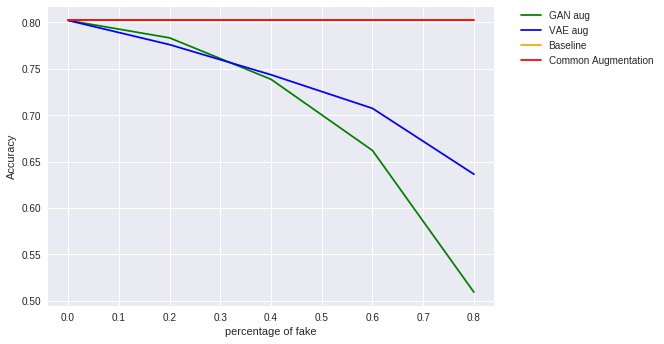

In [23]:
import matplotlib.pyplot as plt
baseline_acc = 0.80220
augmented_acc = 0.8074
ratio = [0, 0.2, 0.4, 0.6, 0.8]
gan = [baseline_acc, 0.77610, 0.7436, 0.7074, 0.6364]
vae = [baseline_acc , 0.78340, 0.7387, 0.662, 0.5092]


plt.plot(ratio, vae, color='g', label="GAN aug")
plt.plot(ratio, gan, color='b', label="VAE aug")
plt.plot(ratio, [baseline_acc]*5, color='orange', label="Baseline")
plt.plot(ratio, [baseline_acc]*5, color='red', label="Common Augmentation")
plt.xlabel('percentage of fake')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [1]:
losses = [2.7829026794433593, 3.1264034271240235, 3.6072179317474364, 6.418364372253418, 2.372521090507507, 2.3409073734283448, 3.2199129557609556, 3.2876040315628052]
scores = [0.38, 0.29, 0.19, 0.16, 0.4, 0.33, 0.24, 0.23]

ratio = [0, 0.2, 0.4, 0.6, 0.8]
gan = [baseline_acc, 0.77610, 0.7436, 0.7074, 0.6364]
vae = [baseline_acc , 0.78340, 0.7387, 0.662, 0.5092]

print(lat2)
print(lat8)

plt.plot(ratio, vae, color='g', label="GAN aug")
plt.plot(ratio, gan, color='b', label="VAE aug")

plt.xlabel('percentage of fake')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

NameError: ignored

In [42]:
!ls

acgan-history.pkl		     weights-improvement-01-0.50.hdf5
datalab				     weights-improvement-01-0.63.hdf5
images				     weights-improvement-01-0.66.hdf5
model-0.2-fake.hdf5		     weights-improvement-01-0.68.hdf5
model-0.4-fake.hdf5		     weights-improvement-01-0.76.hdf5
model-0.6-fake.hdf5		     weights-improvement-02-0.61.hdf5
model-0.8-fake.hdf5		     weights-improvement-02-0.62.hdf5
model-1-fake.hdf5		     weights-improvement-02-0.64.hdf5
params_discriminator_epoch_073.hdf5  weights-improvement-02-0.66.hdf5
params_discriminator_epoch_074.hdf5  weights-improvement-02-0.69.hdf5
params_generator_epoch_073.hdf5      weights-improvement-02-0.70.hdf5
params_generator_epoch_074.hdf5      weights-improvement-02-0.72.hdf5
weights-improvement-01-0.49.hdf5


In [0]:
for ratio in fake_ratio:
  files.download('model-{}-fake.hdf5'.format(ratio))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10

import pickle



NUM_CLASSES = 10 #cifar
DATA_AUGMENTATION = False
SIZE = [32, 32, 3]
original_dim = 32*32*3
intermediate_dim = [64, 128, 256]
latent_dim = [2, 4, 8, 16, 32]
batch_size = 64
epochs = [5, 10, 25, 50]
epsilon_std = 1.0#[0.5, 1.0, 2.0, 5.0]
load_model = False
weights_path = "weights_4_DIM_5_epochs.hdf5"


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    """ KL divergence for loss. """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

intermediate_dims = [64, 128, 256]
latent_dims = [2, 4, 8, 16, 32]
batch_size = 64
epochss = [5, 10, 25, 50]


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
if (x_train[0].shape == (3, 32, 32)):
  x_train = x_train.transpose(0, 3, 2, 1)
  x_test = x_test.transpose(0, 3, 2, 1)
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.


for intermediate_dim in intermediate_dims:
  for latent_dim in latent_dims:
    for epochs in epochss:
      print("int-{}-lat-{}-epo-{}".format(intermediate_dim, latent_dim, epochs))
      decoder_h = Dense(intermediate_dim, input_dim=latent_dim, activation='relu')
      decoder_mean = Dense(original_dim, activation='sigmoid')

      decoder = Sequential([
          decoder_h,
          decoder_mean
      ])

      x = Input(shape=(original_dim,))
      h = Dense(intermediate_dim, activation='relu')(x)

      z_mu = Dense(latent_dim)(h)
      z_log_var = Dense(latent_dim)(h)

      z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
      z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

      eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                         shape=(K.shape(x)[0], latent_dim)))
      z_eps = Multiply()([z_sigma, eps])
      z = Add()([z_mu, z_eps])

      x_pred = decoder(z)
      encoder = Model([x, eps], z)

      decoder_input = Input(shape=(latent_dim,))

      _h_decoded = decoder_h(decoder_input)
      _x_decoded_mean = decoder_mean(_h_decoded)
      generator = Model(decoder_input, _x_decoded_mean)
    
    
    
      vae = Model(inputs=[x, eps], outputs=x_pred)
      vae.compile(optimizer='rmsprop', loss=nll)
      vae.fit(x_train,
            x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test))
      vae.save_weights("vae_epochs-{}---latent-{}---med-{}---epoch-{}.hdf5".format(epochss, latent_dim, intermediate_dim, epochs))


      n = 15
      img_size = 32
      figure = np.zeros((img_size * n, img_size * n, 3))

      for i in range(n):
          for j in range(n):
              z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
              x_decoded = generator.predict(z_sample)
              img = x_decoded[0].reshape(img_size, img_size, 3)
              #img = img*255
              figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



      plt.figure(figsize=(15, 15))
      plt.imshow(figure)
      plt.show()
      

# print(x_train.shape)
# with open('caltech_dataset.pickle', 'rb') as data:
#     x_train, x_test, y_train, y_test = pickle.load(data)




#x_train = x_train[:1000]
#y_train = x_train[:1000]

# from collections import Counter
# c=Counter()
# for d in y_train:
#     c[str(d)] += 1
# print(c)
# def visualize_closest(latent_point, axis1, axis2, step):
#     n = 3
#     #img_size = 32
#     figure = np.zeros((SIZE[0] * 3, SIZE[1] * 3, 3))

#     for i in range(-1, 2):
#         for j in range(-1, 2):
#             temp = latent_point
#             temp[axis1] += i*step
#             temp[axis2] += j * step
#             x_decoded = generator.predict(np.array([temp]))
#             print(x_decoded)
#             img = x_decoded[0].reshape(SIZE)
#             #img *= 255
#             #print(img)
#             figure[(i+1) * SIZE[0]: (i + 2) * SIZE[0], (j+1) * SIZE[1]: (j + 2) * SIZE[1]] = img

#     plt.figure(figsize=(20, 20))
#     plt.imshow(figure)
#     plt.show()



# print(y_train[0])
# print(encoder.predict(x_train[0:2]))



# if load_model:
#     vae.load_weights(weights_path)
# else:
#     vae.fit(x_train,
#             x_train,
#             shuffle=True,
#             epochs=epochs,
#             batch_size=batch_size,
#             validation_data=(x_test, x_test))
#     vae.save_weights("weights_{}_DIM_{}_epochs.hdf5".format(latent_dim, epochs))

# lat1, lat2 = encoder.predict(x_train[0:2])
# plt.imshow(x_train[0].reshape(SIZE))
# plt.show()
# visualize_closest(lat1, 1, 3, 0.1)
# plt.imshow(x_train[1].reshape(SIZE))
# plt.show()
# visualize_closest(lat2, 1, 3, 0.1)
# print(x_train.shape)


# x = x_train[0]
# # print(x.shape)
# eps = Input(tensor=K.random_normal(stddev=epsilon_std,
#                                    shape=(K.shape(x)[0], latent_dim)))


# n = 15
# img_size = 32
# figure = np.zeros((img_size * n, img_size * n, 3))


# for i in range(n):
#     for j in range(n):
#         z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
#         x_decoded = generator.predict(z_sample)
#         img = x_decoded[0].reshape(img_size, img_size, 3)
#         #img = img*255
#         figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



# plt.figure(figsize=(15, 15))
# plt.imshow(figure)
# plt.show()


int-64-lat-2-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 160us/step - loss: 2055.4054 - val_loss: 1992.4507
Epoch 2/5
50000/50000 [==============================] - 8s 156us/step - loss: 1972.1840 - val_loss: 1973.5550
Epoch 3/5
44352/50000 [=========================>....] - ETA: 0s - loss: 1966.1760

50000/50000 [==============================] - 8s 151us/step - loss: 1966.6467 - val_loss: 1974.4785
Epoch 4/5
50000/50000 [==============================] - 8s 155us/step - loss: 1964.5913 - val_loss: 1967.6893
Epoch 5/5
50000/50000 [==============================] - 8s 153us/step - loss: 1962.9642 - val_loss: 1963.6260


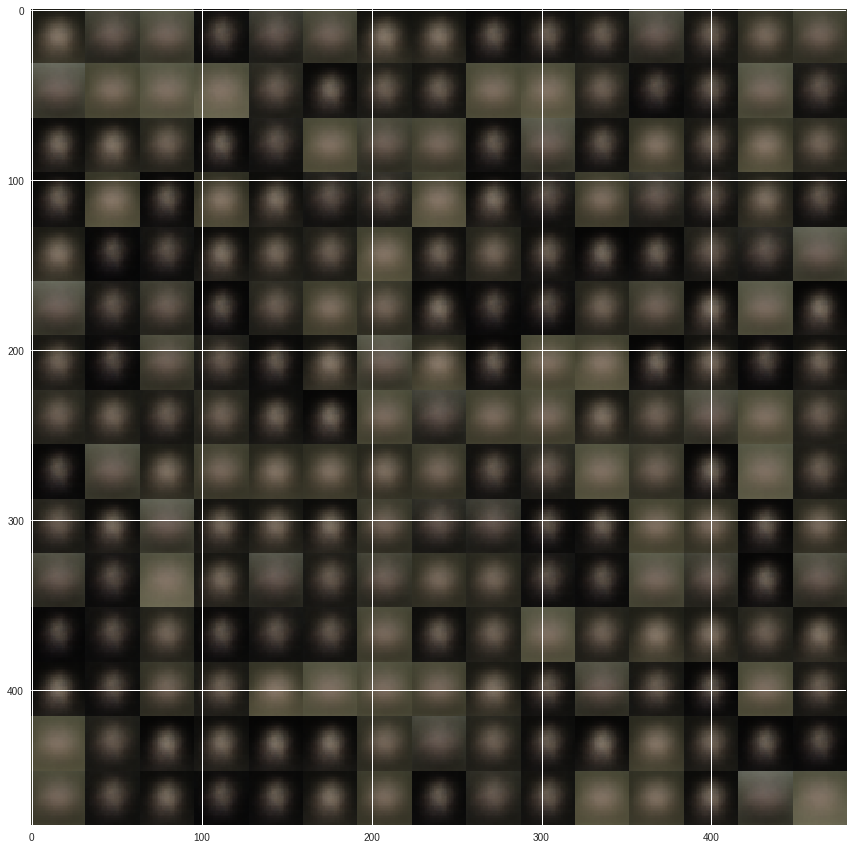

int-64-lat-2-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 164us/step - loss: 2012.7821 - val_loss: 1971.8290
Epoch 2/10
50000/50000 [==============================] - 8s 158us/step - loss: 1967.3651 - val_loss: 1970.2627
Epoch 3/10
42688/50000 [========================>.....] - ETA: 1s - loss: 1964.8027

50000/50000 [==============================] - 8s 157us/step - loss: 1964.7522 - val_loss: 1966.2073
Epoch 4/10
50000/50000 [==============================] - 8s 151us/step - loss: 1962.7897 - val_loss: 1966.1122
Epoch 5/10
50000/50000 [==============================] - 8s 152us/step - loss: 1962.1396 - val_loss: 1961.8075
Epoch 6/10
30848/50000 [=================>............] - ETA: 2s - loss: 1961.0436

50000/50000 [==============================] - 8s 156us/step - loss: 1960.7873 - val_loss: 1962.5384
Epoch 7/10
50000/50000 [==============================] - 8s 156us/step - loss: 1960.3792 - val_loss: 1962.6533
Epoch 8/10
50000/50000 [==============================] - 8s 154us/step - loss: 1959.5492 - val_loss: 1959.7954
Epoch 9/10
28736/50000 [================>.............] - ETA: 3s - loss: 1958.5578

50000/50000 [==============================] - 8s 153us/step - loss: 1959.1724 - val_loss: 1961.8274
Epoch 10/10
50000/50000 [==============================] - 8s 153us/step - loss: 1958.8559 - val_loss: 1959.6047


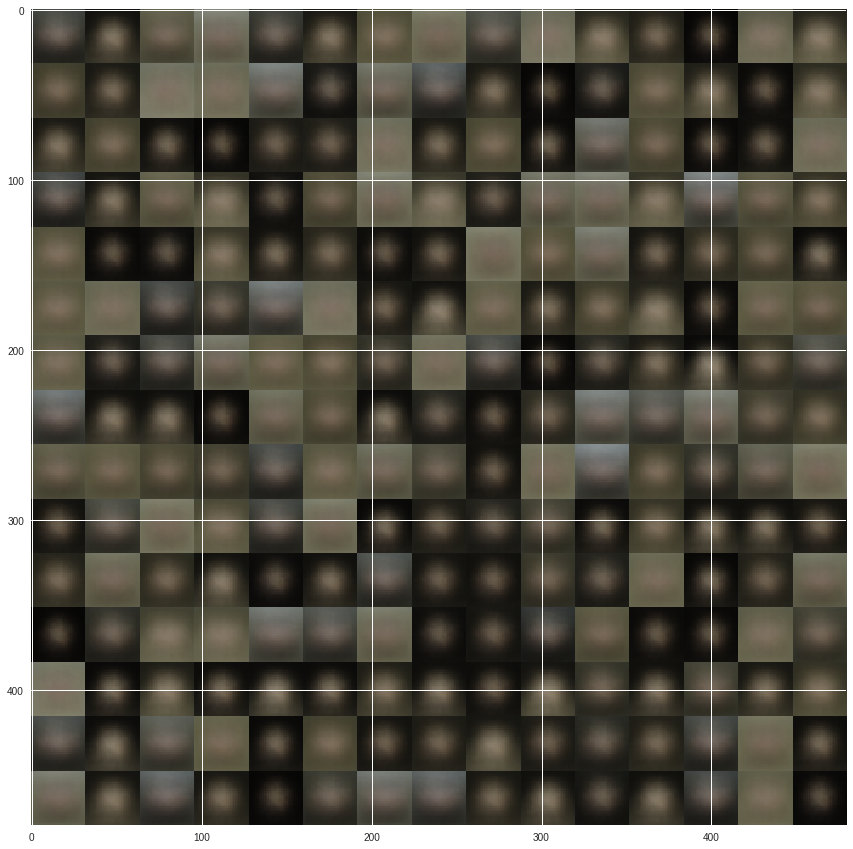

int-64-lat-2-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 170us/step - loss: 2006.3417 - val_loss: 1967.7945
Epoch 2/25
50000/50000 [==============================] - 8s 158us/step - loss: 1967.5441 - val_loss: 1970.3654
Epoch 3/25
42624/50000 [========================>.....] - ETA: 1s - loss: 1965.5193

50000/50000 [==============================] - 8s 153us/step - loss: 1965.3110 - val_loss: 1965.2605
Epoch 4/25
50000/50000 [==============================] - 8s 153us/step - loss: 1963.9288 - val_loss: 1968.9113
Epoch 5/25
50000/50000 [==============================] - 8s 154us/step - loss: 1963.1008 - val_loss: 1966.5552
Epoch 6/25
30464/50000 [=================>............] - ETA: 2s - loss: 1962.3582

50000/50000 [==============================] - 8s 157us/step - loss: 1962.5148 - val_loss: 1961.9977
Epoch 7/25
50000/50000 [==============================] - 8s 155us/step - loss: 1961.9429 - val_loss: 1964.5373
Epoch 8/25
50000/50000 [==============================] - 8s 156us/step - loss: 1961.8599 - val_loss: 1961.4162
Epoch 9/25
28672/50000 [================>.............] - ETA: 3s - loss: 1961.8448

50000/50000 [==============================] - 8s 154us/step - loss: 1961.1106 - val_loss: 1960.3040
Epoch 10/25
50000/50000 [==============================] - 8s 151us/step - loss: 1960.8149 - val_loss: 1960.7472
Epoch 11/25
50000/50000 [==============================] - 8s 152us/step - loss: 1960.5039 - val_loss: 1961.0670
Epoch 12/25
28160/50000 [===============>..............] - ETA: 3s - loss: 1959.4668

50000/50000 [==============================] - 8s 153us/step - loss: 1960.2704 - val_loss: 1960.3203
Epoch 13/25
50000/50000 [==============================] - 8s 152us/step - loss: 1960.0271 - val_loss: 1960.3437
Epoch 14/25
50000/50000 [==============================] - 8s 158us/step - loss: 1959.8471 - val_loss: 1961.5120
Epoch 15/25
27712/50000 [===============>..............] - ETA: 3s - loss: 1961.3190

50000/50000 [==============================] - 8s 152us/step - loss: 1959.7356 - val_loss: 1960.0634
Epoch 16/25
50000/50000 [==============================] - 8s 156us/step - loss: 1959.6096 - val_loss: 1960.4061
Epoch 17/25
50000/50000 [==============================] - 8s 154us/step - loss: 1959.4073 - val_loss: 1961.6520
Epoch 18/25
27392/50000 [===============>..............] - ETA: 3s - loss: 1959.7762

50000/50000 [==============================] - 8s 155us/step - loss: 1959.3249 - val_loss: 1960.6801
Epoch 19/25
50000/50000 [==============================] - 8s 158us/step - loss: 1959.1964 - val_loss: 1960.8376
Epoch 20/25
50000/50000 [==============================] - 8s 154us/step - loss: 1959.0383 - val_loss: 1961.1650
Epoch 21/25
27456/50000 [===============>..............] - ETA: 3s - loss: 1959.9253

50000/50000 [==============================] - 8s 156us/step - loss: 1959.0073 - val_loss: 1963.2533
Epoch 22/25
50000/50000 [==============================] - 8s 157us/step - loss: 1958.9103 - val_loss: 1960.1096
Epoch 23/25
50000/50000 [==============================] - 8s 155us/step - loss: 1958.8579 - val_loss: 1959.0473
Epoch 24/25
27008/50000 [===============>..............] - ETA: 3s - loss: 1957.5382

50000/50000 [==============================] - 8s 153us/step - loss: 1958.7048 - val_loss: 1959.2018
Epoch 25/25
50000/50000 [==============================] - 8s 153us/step - loss: 1958.6666 - val_loss: 1959.4713


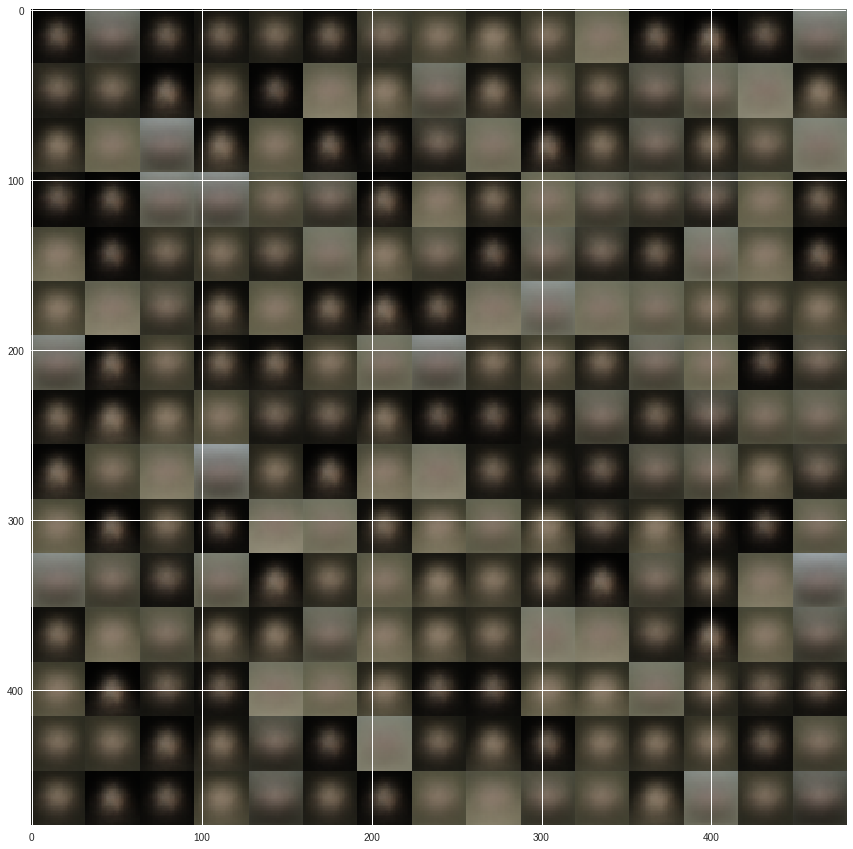

int-64-lat-2-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 165us/step - loss: 2013.6535 - val_loss: 1979.0455
Epoch 2/50
50000/50000 [==============================] - 8s 153us/step - loss: 1971.9807 - val_loss: 1971.4344
Epoch 3/50
42688/50000 [========================>.....] - ETA: 1s - loss: 1968.2740

50000/50000 [==============================] - 8s 156us/step - loss: 1968.1034 - val_loss: 1968.1010
Epoch 4/50
50000/50000 [==============================] - 8s 156us/step - loss: 1964.8914 - val_loss: 1968.6551
Epoch 5/50
50000/50000 [==============================] - 8s 153us/step - loss: 1963.4090 - val_loss: 1970.9167
Epoch 6/50
30784/50000 [=================>............] - ETA: 2s - loss: 1962.2554

50000/50000 [==============================] - 8s 157us/step - loss: 1963.1502 - val_loss: 1961.5691
Epoch 7/50
50000/50000 [==============================] - 8s 153us/step - loss: 1961.7505 - val_loss: 1964.9436
Epoch 8/50
50000/50000 [==============================] - 8s 153us/step - loss: 1961.2633 - val_loss: 1961.4589
Epoch 9/50
28736/50000 [================>.............] - ETA: 3s - loss: 1961.1075

50000/50000 [==============================] - 8s 153us/step - loss: 1960.8994 - val_loss: 1961.7815
Epoch 10/50
50000/50000 [==============================] - 8s 157us/step - loss: 1960.5373 - val_loss: 1962.9505
Epoch 11/50
50000/50000 [==============================] - 8s 153us/step - loss: 1960.3152 - val_loss: 1960.0509
Epoch 12/50
27968/50000 [===============>..............] - ETA: 3s - loss: 1960.0126

50000/50000 [==============================] - 8s 152us/step - loss: 1960.0959 - val_loss: 1964.5674
Epoch 13/50
50000/50000 [==============================] - 7s 150us/step - loss: 1959.8457 - val_loss: 1960.2385
Epoch 14/50
50000/50000 [==============================] - 8s 152us/step - loss: 1959.6443 - val_loss: 1959.9658
Epoch 15/50
27968/50000 [===============>..............] - ETA: 3s - loss: 1959.6858

50000/50000 [==============================] - 8s 154us/step - loss: 1959.4993 - val_loss: 1963.4325
Epoch 16/50
50000/50000 [==============================] - 8s 158us/step - loss: 1959.3816 - val_loss: 1962.7600
Epoch 17/50
50000/50000 [==============================] - 8s 159us/step - loss: 1959.2787 - val_loss: 1959.7356
Epoch 18/50
27200/50000 [===============>..............] - ETA: 3s - loss: 1958.4829

50000/50000 [==============================] - 8s 154us/step - loss: 1959.1387 - val_loss: 1960.3130
Epoch 19/50
50000/50000 [==============================] - 8s 157us/step - loss: 1958.9902 - val_loss: 1963.4257
Epoch 20/50
50000/50000 [==============================] - 8s 160us/step - loss: 1958.8895 - val_loss: 1964.2316
Epoch 21/50
26624/50000 [==============>...............] - ETA: 3s - loss: 1959.1127

50000/50000 [==============================] - 8s 158us/step - loss: 1958.8122 - val_loss: 1968.4316
Epoch 22/50
50000/50000 [==============================] - 8s 155us/step - loss: 1958.6800 - val_loss: 1961.0488
Epoch 23/50
50000/50000 [==============================] - 8s 153us/step - loss: 1958.6344 - val_loss: 1965.9725
Epoch 24/50
27456/50000 [===============>..............] - ETA: 3s - loss: 1958.5531

50000/50000 [==============================] - 8s 154us/step - loss: 1958.5348 - val_loss: 1959.5179
Epoch 25/50
50000/50000 [==============================] - 8s 153us/step - loss: 1958.4391 - val_loss: 1959.3542
Epoch 26/50
50000/50000 [==============================] - 8s 152us/step - loss: 1958.4105 - val_loss: 1960.0813
Epoch 27/50
27264/50000 [===============>..............] - ETA: 3s - loss: 1959.8442

50000/50000 [==============================] - 8s 157us/step - loss: 1958.2925 - val_loss: 1960.7203
Epoch 28/50
50000/50000 [==============================] - 8s 155us/step - loss: 1958.2399 - val_loss: 1960.0259
Epoch 29/50
50000/50000 [==============================] - 8s 158us/step - loss: 1958.2130 - val_loss: 1963.6024
Epoch 30/50
26816/50000 [===============>..............] - ETA: 3s - loss: 1958.8575

50000/50000 [==============================] - 8s 157us/step - loss: 1958.0984 - val_loss: 1962.5351
Epoch 31/50
50000/50000 [==============================] - 8s 156us/step - loss: 1958.0533 - val_loss: 1958.6858
Epoch 32/50
50000/50000 [==============================] - 8s 156us/step - loss: 1958.0115 - val_loss: 1958.5531
Epoch 33/50
26880/50000 [===============>..............] - ETA: 3s - loss: 1958.8315

50000/50000 [==============================] - 8s 158us/step - loss: 1957.9317 - val_loss: 1972.1981
Epoch 34/50
50000/50000 [==============================] - 8s 160us/step - loss: 1957.8694 - val_loss: 1958.6512
Epoch 35/50
50000/50000 [==============================] - 8s 158us/step - loss: 1957.7928 - val_loss: 1959.8784
Epoch 36/50
26816/50000 [===============>..............] - ETA: 3s - loss: 1957.9770

50000/50000 [==============================] - 8s 160us/step - loss: 1957.7134 - val_loss: 1958.3412
Epoch 37/50
50000/50000 [==============================] - 8s 155us/step - loss: 1957.5946 - val_loss: 1961.6544
Epoch 38/50
50000/50000 [==============================] - 8s 159us/step - loss: 1957.5151 - val_loss: 1962.4077
Epoch 39/50
27200/50000 [===============>..............] - ETA: 3s - loss: 1957.3280

50000/50000 [==============================] - 8s 154us/step - loss: 1957.3976 - val_loss: 1962.8267
Epoch 40/50
50000/50000 [==============================] - 8s 157us/step - loss: 1957.2686 - val_loss: 1959.8495
Epoch 41/50
50000/50000 [==============================] - 8s 159us/step - loss: 1957.2078 - val_loss: 1964.7264
Epoch 42/50
26240/50000 [==============>...............] - ETA: 3s - loss: 1956.6287

50000/50000 [==============================] - 8s 164us/step - loss: 1957.1272 - val_loss: 1963.8732
Epoch 43/50
50000/50000 [==============================] - 8s 152us/step - loss: 1957.0347 - val_loss: 1962.2932
Epoch 44/50
50000/50000 [==============================] - 8s 156us/step - loss: 1956.9176 - val_loss: 1962.9102
Epoch 45/50
24576/50000 [=============>................] - ETA: 4s - loss: 1955.9192

50000/50000 [==============================] - 9s 189us/step - loss: 1956.7595 - val_loss: 1957.6965
Epoch 46/50
50000/50000 [==============================] - 12s 246us/step - loss: 1956.5553 - val_loss: 1957.4555
Epoch 47/50
49792/50000 [============================>.] - ETA: 0s - loss: 1956.1910

50000/50000 [==============================] - 11s 221us/step - loss: 1956.1289 - val_loss: 1966.9102
Epoch 48/50
50000/50000 [==============================] - 12s 242us/step - loss: 1955.8165 - val_loss: 1956.8726
Epoch 49/50
50000/50000 [==============================] - 10s 206us/step - loss: 1955.6424 - val_loss: 1958.1948
Epoch 50/50
 7488/50000 [===>..........................] - ETA: 7s - loss: 1955.0333

50000/50000 [==============================] - 9s 181us/step - loss: 1955.5140 - val_loss: 1956.4701


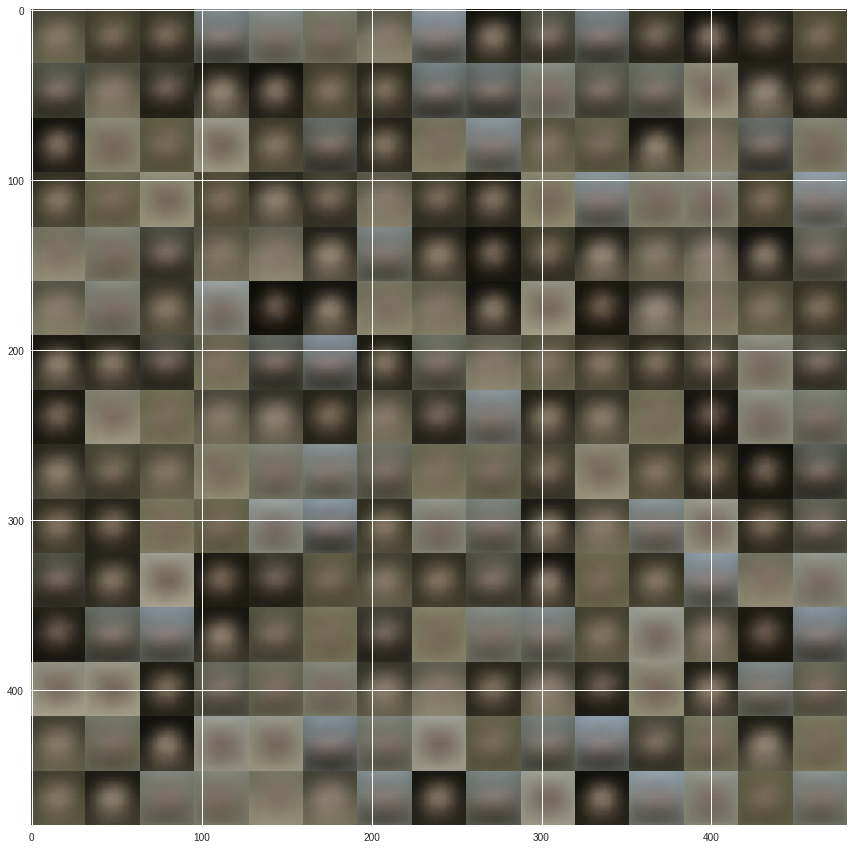

int-64-lat-4-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 164us/step - loss: 1995.1364 - val_loss: 2003.2408
Epoch 2/5
50000/50000 [==============================] - 8s 154us/step - loss: 1945.7723 - val_loss: 1947.0216
Epoch 3/5
43712/50000 [=========================>....] - ETA: 0s - loss: 1932.2957

50000/50000 [==============================] - 8s 159us/step - loss: 1931.9947 - val_loss: 1928.5705
Epoch 4/5
50000/50000 [==============================] - 8s 159us/step - loss: 1928.7238 - val_loss: 1926.8188
Epoch 5/5
50000/50000 [==============================] - 8s 156us/step - loss: 1926.2588 - val_loss: 1934.2232


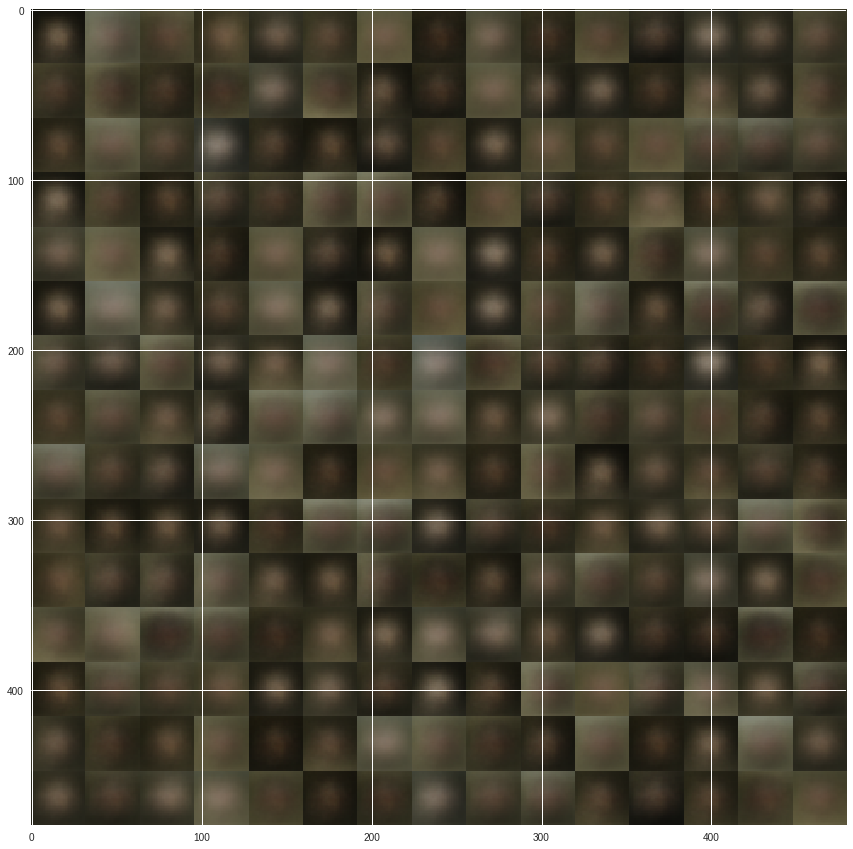

int-64-lat-4-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 171us/step - loss: 1995.1616 - val_loss: 1963.5966
Epoch 2/10
50000/50000 [==============================] - 8s 159us/step - loss: 1939.4395 - val_loss: 1932.6464
Epoch 3/10
42304/50000 [========================>.....] - ETA: 1s - loss: 1930.4485

50000/50000 [==============================] - 8s 157us/step - loss: 1929.9688 - val_loss: 1928.9206
Epoch 4/10
50000/50000 [==============================] - 8s 160us/step - loss: 1927.5571 - val_loss: 1934.4338
Epoch 5/10
50000/50000 [==============================] - 8s 159us/step - loss: 1926.2375 - val_loss: 1924.5355
Epoch 6/10
29952/50000 [================>.............] - ETA: 2s - loss: 1925.3421

50000/50000 [==============================] - 8s 160us/step - loss: 1925.0923 - val_loss: 1928.2660
Epoch 7/10
50000/50000 [==============================] - 8s 155us/step - loss: 1924.1054 - val_loss: 1930.4765
Epoch 8/10
50000/50000 [==============================] - 8s 156us/step - loss: 1923.3228 - val_loss: 1930.1642
Epoch 9/10
27968/50000 [===============>..............] - ETA: 3s - loss: 1923.2455

50000/50000 [==============================] - 8s 159us/step - loss: 1922.6140 - val_loss: 1921.7650
Epoch 10/10
50000/50000 [==============================] - 8s 154us/step - loss: 1921.8533 - val_loss: 1924.2760


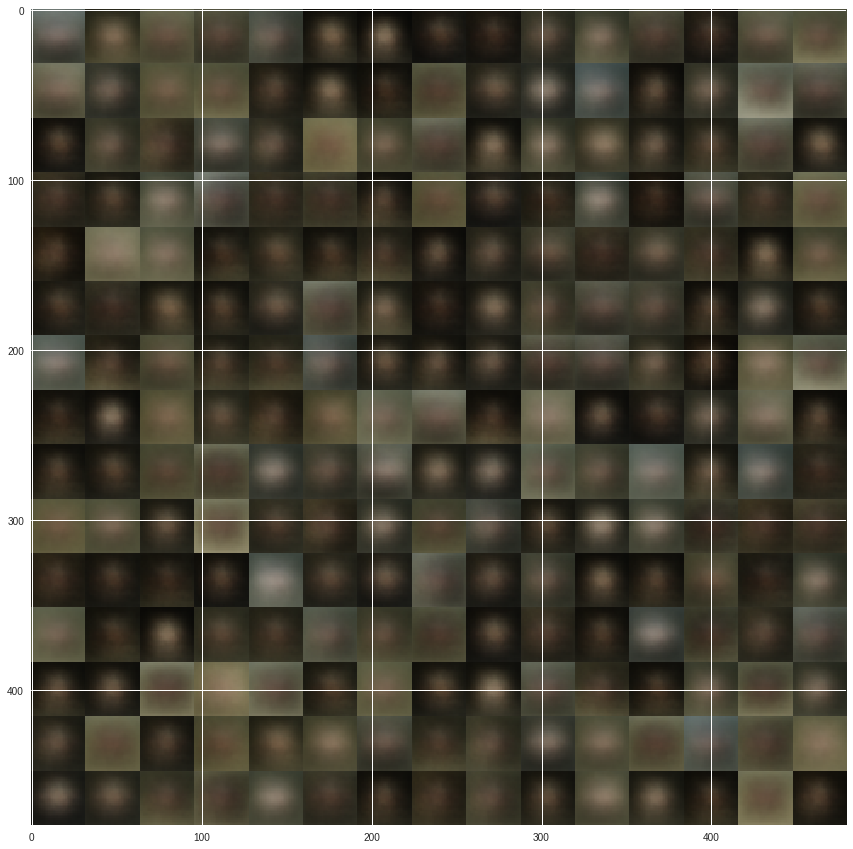

int-64-lat-4-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 172us/step - loss: 2001.0727 - val_loss: 1955.6500
Epoch 2/25
50000/50000 [==============================] - 8s 157us/step - loss: 1939.4551 - val_loss: 1932.5440
Epoch 3/25
42432/50000 [========================>.....] - ETA: 1s - loss: 1930.7790

50000/50000 [==============================] - 8s 158us/step - loss: 1930.8732 - val_loss: 1932.8054
Epoch 4/25
50000/50000 [==============================] - 8s 156us/step - loss: 1928.4196 - val_loss: 1941.1734
Epoch 5/25
50000/50000 [==============================] - 8s 156us/step - loss: 1926.9353 - val_loss: 1927.4339
Epoch 6/25
30336/50000 [=================>............] - ETA: 2s - loss: 1925.6575

50000/50000 [==============================] - 8s 154us/step - loss: 1925.6041 - val_loss: 1924.2756
Epoch 7/25
50000/50000 [==============================] - 8s 153us/step - loss: 1924.5985 - val_loss: 1931.5245
Epoch 8/25
50000/50000 [==============================] - 8s 156us/step - loss: 1923.9306 - val_loss: 1926.2776
Epoch 9/25
28736/50000 [================>.............] - ETA: 3s - loss: 1921.4828

50000/50000 [==============================] - 8s 157us/step - loss: 1923.1746 - val_loss: 1929.2561
Epoch 10/25
50000/50000 [==============================] - 8s 157us/step - loss: 1922.7130 - val_loss: 1924.2082
Epoch 11/25
50000/50000 [==============================] - 8s 160us/step - loss: 1922.1189 - val_loss: 1920.3837
Epoch 12/25
26816/50000 [===============>..............] - ETA: 3s - loss: 1921.3560

50000/50000 [==============================] - 8s 161us/step - loss: 1921.6533 - val_loss: 1926.7194
Epoch 13/25
50000/50000 [==============================] - 8s 155us/step - loss: 1921.2383 - val_loss: 1924.6099
Epoch 14/25
50000/50000 [==============================] - 8s 154us/step - loss: 1920.8469 - val_loss: 1922.0983
Epoch 15/25
26688/50000 [===============>..............] - ETA: 3s - loss: 1919.9785

50000/50000 [==============================] - 8s 156us/step - loss: 1920.4415 - val_loss: 1918.6896
Epoch 16/25
50000/50000 [==============================] - 8s 161us/step - loss: 1920.1340 - val_loss: 1918.9845
Epoch 17/25
50000/50000 [==============================] - 8s 164us/step - loss: 1919.7680 - val_loss: 1918.7793
Epoch 18/25
24832/50000 [=============>................] - ETA: 3s - loss: 1918.6990

50000/50000 [==============================] - 8s 155us/step - loss: 1919.5371 - val_loss: 1928.1514
Epoch 19/25
50000/50000 [==============================] - 8s 155us/step - loss: 1919.1969 - val_loss: 1922.2346
Epoch 20/25
50000/50000 [==============================] - 8s 156us/step - loss: 1918.9512 - val_loss: 1919.7923
Epoch 21/25
25728/50000 [==============>...............] - ETA: 3s - loss: 1919.0655

50000/50000 [==============================] - 8s 167us/step - loss: 1918.6049 - val_loss: 1920.2471
Epoch 22/25
50000/50000 [==============================] - 9s 178us/step - loss: 1918.3377 - val_loss: 1918.2126
Epoch 23/25
50000/50000 [==============================] - 11s 217us/step - loss: 1918.0276 - val_loss: 1923.9919
Epoch 24/25
 9728/50000 [====>.........................] - ETA: 6s - loss: 1914.8577

50000/50000 [==============================] - 10s 195us/step - loss: 1917.7042 - val_loss: 1922.4928
Epoch 25/25
50000/50000 [==============================] - 8s 158us/step - loss: 1917.5571 - val_loss: 1918.0943


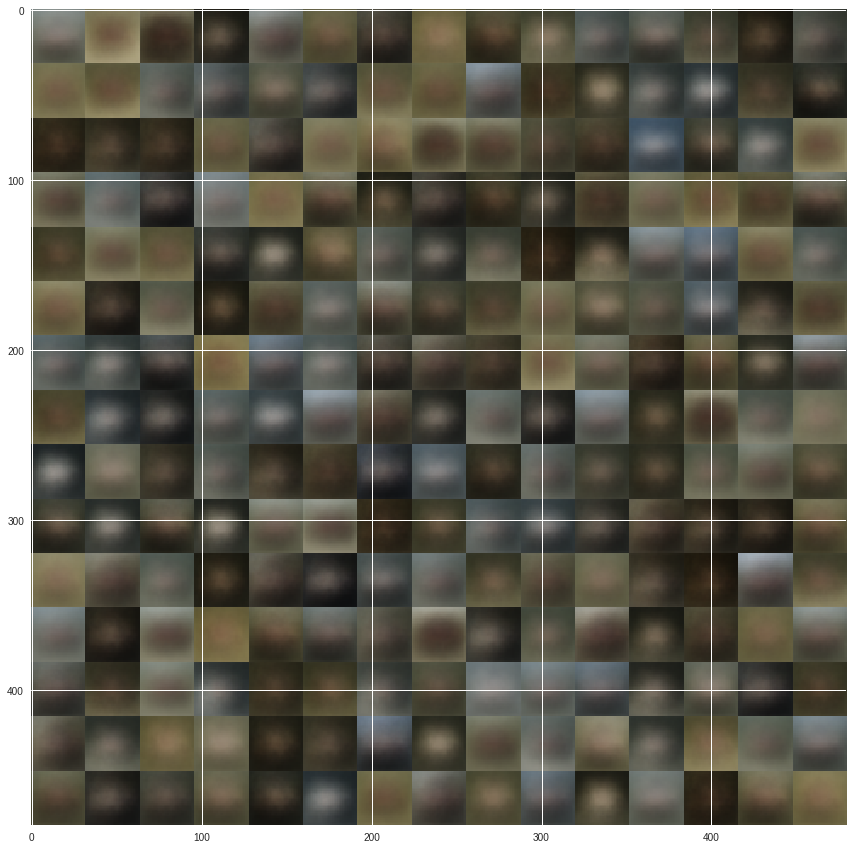

int-64-lat-4-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 177us/step - loss: 2001.0166 - val_loss: 1959.3074
Epoch 2/50
50000/50000 [==============================] - 8s 158us/step - loss: 1948.2411 - val_loss: 1933.3539
Epoch 3/50
27072/50000 [===============>..............] - ETA: 5s - loss: 1934.8348

50000/50000 [==============================] - 14s 281us/step - loss: 1934.3944 - val_loss: 1935.9474
Epoch 4/50
50000/50000 [==============================] - 15s 295us/step - loss: 1930.6224 - val_loss: 1934.6572
Epoch 5/50
31616/50000 [=================>............] - ETA: 5s - loss: 1928.1459

50000/50000 [==============================] - 15s 305us/step - loss: 1927.8881 - val_loss: 1926.7593
Epoch 6/50
50000/50000 [==============================] - 15s 302us/step - loss: 1925.3859 - val_loss: 1932.6225
Epoch 7/50
30400/50000 [=================>............] - ETA: 5s - loss: 1923.6021

50000/50000 [==============================] - 15s 304us/step - loss: 1923.6624 - val_loss: 1924.1935
Epoch 8/50
50000/50000 [==============================] - 15s 292us/step - loss: 1922.6289 - val_loss: 1926.6533
Epoch 9/50
33600/50000 [===================>..........] - ETA: 4s - loss: 1921.9654

50000/50000 [==============================] - 13s 258us/step - loss: 1921.7169 - val_loss: 1927.8312
Epoch 10/50
50000/50000 [==============================] - 11s 213us/step - loss: 1920.7336 - val_loss: 1921.0400
Epoch 11/50
41920/50000 [========================>.....] - ETA: 2s - loss: 1920.1599

50000/50000 [==============================] - 15s 306us/step - loss: 1920.0029 - val_loss: 1922.4331
Epoch 12/50
50000/50000 [==============================] - 16s 322us/step - loss: 1919.3304 - val_loss: 1919.5671
Epoch 13/50
32064/50000 [==================>...........] - ETA: 5s - loss: 1919.3377

50000/50000 [==============================] - 16s 311us/step - loss: 1918.8520 - val_loss: 1923.2718
Epoch 14/50
50000/50000 [==============================] - 15s 304us/step - loss: 1918.2929 - val_loss: 1921.4337
Epoch 15/50
31680/50000 [==================>...........] - ETA: 5s - loss: 1918.1980

50000/50000 [==============================] - 15s 307us/step - loss: 1917.8475 - val_loss: 1925.3104
Epoch 16/50
50000/50000 [==============================] - 16s 311us/step - loss: 1917.4768 - val_loss: 1918.8135
Epoch 17/50
30016/50000 [=================>............] - ETA: 5s - loss: 1916.9659

50000/50000 [==============================] - 16s 318us/step - loss: 1916.9777 - val_loss: 1923.4110
Epoch 18/50
50000/50000 [==============================] - 13s 264us/step - loss: 1916.7171 - val_loss: 1919.1451
Epoch 19/50
50000/50000 [==============================] - 8s 157us/step - loss: 1916.2982 - val_loss: 1921.6067
Epoch 20/50
 8768/50000 [====>.........................] - ETA: 5s - loss: 1915.7808

50000/50000 [==============================] - 8s 151us/step - loss: 1915.8505 - val_loss: 1923.4814
Epoch 21/50
50000/50000 [==============================] - 8s 163us/step - loss: 1915.4966 - val_loss: 1923.3450
Epoch 22/50
50000/50000 [==============================] - 8s 157us/step - loss: 1915.2905 - val_loss: 1915.1096
Epoch 23/50
22976/50000 [============>.................] - ETA: 3s - loss: 1914.8630

50000/50000 [==============================] - 8s 156us/step - loss: 1914.9844 - val_loss: 1919.9749
Epoch 24/50
50000/50000 [==============================] - 8s 158us/step - loss: 1914.7963 - val_loss: 1924.9556
Epoch 25/50
50000/50000 [==============================] - 8s 155us/step - loss: 1914.5269 - val_loss: 1918.1692
Epoch 26/50
26496/50000 [==============>...............] - ETA: 3s - loss: 1914.1341

50000/50000 [==============================] - 8s 158us/step - loss: 1914.4541 - val_loss: 1917.3141
Epoch 27/50
50000/50000 [==============================] - 8s 156us/step - loss: 1914.2358 - val_loss: 1916.9813
Epoch 28/50
50000/50000 [==============================] - 8s 153us/step - loss: 1914.1254 - val_loss: 1918.8600
Epoch 29/50
27648/50000 [===============>..............] - ETA: 3s - loss: 1914.1560

50000/50000 [==============================] - 8s 154us/step - loss: 1914.0467 - val_loss: 1914.5210
Epoch 30/50
50000/50000 [==============================] - 8s 158us/step - loss: 1913.8476 - val_loss: 1917.4293
Epoch 31/50
50000/50000 [==============================] - 8s 158us/step - loss: 1913.8259 - val_loss: 1916.3545
Epoch 32/50
27072/50000 [===============>..............] - ETA: 3s - loss: 1912.8162

50000/50000 [==============================] - 8s 156us/step - loss: 1913.6927 - val_loss: 1915.2550
Epoch 33/50
50000/50000 [==============================] - 8s 161us/step - loss: 1913.5657 - val_loss: 1918.9869
Epoch 34/50
50000/50000 [==============================] - 8s 158us/step - loss: 1913.5773 - val_loss: 1916.4370
Epoch 35/50
26624/50000 [==============>...............] - ETA: 3s - loss: 1913.1138

50000/50000 [==============================] - 8s 157us/step - loss: 1913.4602 - val_loss: 1920.0143
Epoch 36/50
50000/50000 [==============================] - 8s 151us/step - loss: 1913.4157 - val_loss: 1932.7919
Epoch 37/50
50000/50000 [==============================] - 8s 151us/step - loss: 1913.3266 - val_loss: 1919.4426
Epoch 38/50
27520/50000 [===============>..............] - ETA: 3s - loss: 1912.8245

50000/50000 [==============================] - 8s 153us/step - loss: 1913.1999 - val_loss: 1925.1939
Epoch 39/50
50000/50000 [==============================] - 8s 155us/step - loss: 1913.1353 - val_loss: 1917.6899
Epoch 40/50
50000/50000 [==============================] - 8s 154us/step - loss: 1913.1032 - val_loss: 1925.5106
Epoch 41/50
27392/50000 [===============>..............] - ETA: 3s - loss: 1914.1256

50000/50000 [==============================] - 8s 156us/step - loss: 1912.9567 - val_loss: 1913.9420
Epoch 42/50
50000/50000 [==============================] - 8s 153us/step - loss: 1912.8763 - val_loss: 1915.0126
Epoch 43/50
50000/50000 [==============================] - 8s 158us/step - loss: 1912.8878 - val_loss: 1914.7556
Epoch 44/50
27456/50000 [===============>..............] - ETA: 3s - loss: 1913.7274

50000/50000 [==============================] - 8s 155us/step - loss: 1912.8056 - val_loss: 1915.0174
Epoch 45/50
50000/50000 [==============================] - 8s 152us/step - loss: 1912.7605 - val_loss: 1914.7535
Epoch 46/50
50000/50000 [==============================] - 8s 158us/step - loss: 1912.7009 - val_loss: 1912.3149
Epoch 47/50
27456/50000 [===============>..............] - ETA: 3s - loss: 1912.7115

50000/50000 [==============================] - 8s 158us/step - loss: 1912.5883 - val_loss: 1930.7703
Epoch 48/50
50000/50000 [==============================] - 8s 153us/step - loss: 1912.5738 - val_loss: 1912.7007
Epoch 49/50
50000/50000 [==============================] - 8s 159us/step - loss: 1912.5514 - val_loss: 1915.2565
Epoch 50/50
27072/50000 [===============>..............] - ETA: 3s - loss: 1910.6520

50000/50000 [==============================] - 8s 160us/step - loss: 1912.5171 - val_loss: 1914.6094


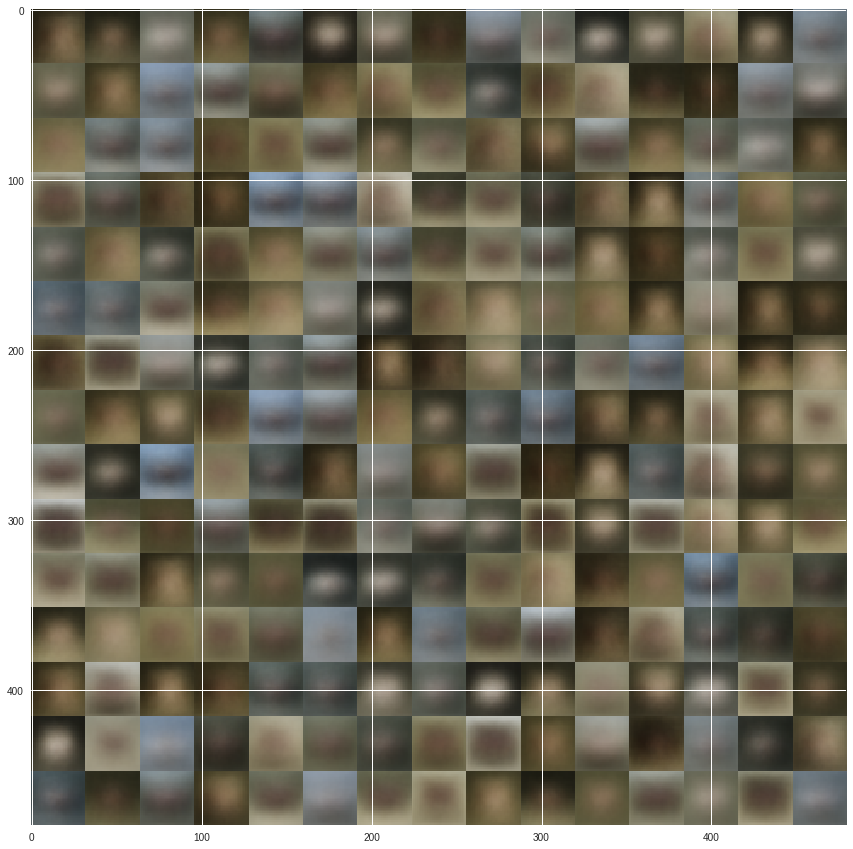

int-64-lat-8-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 179us/step - loss: 2013.9922 - val_loss: 1954.2845
Epoch 2/5
50000/50000 [==============================] - 8s 155us/step - loss: 1926.1385 - val_loss: 1912.5471
Epoch 3/5
44672/50000 [=========================>....] - ETA: 0s - loss: 1910.3308

50000/50000 [==============================] - 8s 152us/step - loss: 1909.6854 - val_loss: 1906.1623
Epoch 4/5
50000/50000 [==============================] - 8s 157us/step - loss: 1900.6774 - val_loss: 1893.4606
Epoch 5/5
50000/50000 [==============================] - 8s 158us/step - loss: 1897.7982 - val_loss: 1911.7054


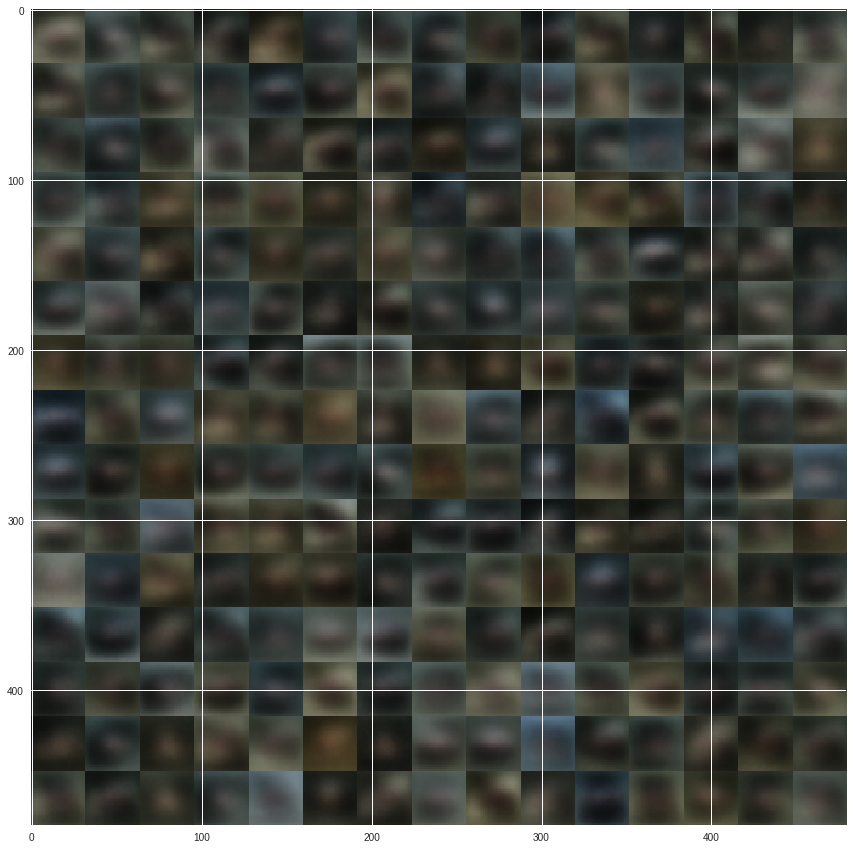

int-64-lat-8-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 179us/step - loss: 1994.9972 - val_loss: 1937.1869
Epoch 2/10
50000/50000 [==============================] - 8s 154us/step - loss: 1926.8376 - val_loss: 1954.0383
Epoch 3/10
42816/50000 [========================>.....] - ETA: 1s - loss: 1916.4405

50000/50000 [==============================] - 8s 157us/step - loss: 1915.4836 - val_loss: 1912.4935
Epoch 4/10
50000/50000 [==============================] - 8s 155us/step - loss: 1905.6767 - val_loss: 1904.6743
Epoch 5/10
50000/50000 [==============================] - 8s 158us/step - loss: 1902.4579 - val_loss: 1895.6382
Epoch 6/10
30656/50000 [=================>............] - ETA: 2s - loss: 1901.3598

50000/50000 [==============================] - 8s 156us/step - loss: 1900.4075 - val_loss: 1910.9367
Epoch 7/10
50000/50000 [==============================] - 8s 157us/step - loss: 1898.7757 - val_loss: 1896.9061
Epoch 8/10
50000/50000 [==============================] - 8s 152us/step - loss: 1897.4196 - val_loss: 1896.3429
Epoch 9/10
28544/50000 [================>.............] - ETA: 3s - loss: 1897.3346

50000/50000 [==============================] - 8s 156us/step - loss: 1896.3614 - val_loss: 1892.6965
Epoch 10/10
50000/50000 [==============================] - 8s 161us/step - loss: 1895.5214 - val_loss: 1896.6422


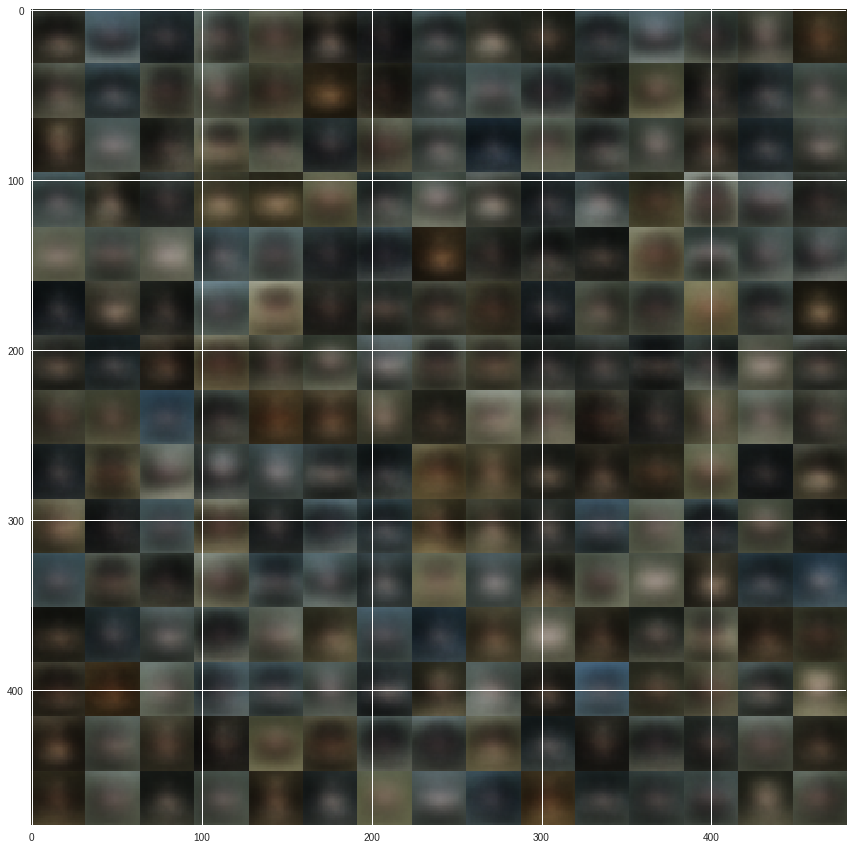

int-64-lat-8-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 173us/step - loss: 2000.3621 - val_loss: 1957.3818
Epoch 2/25
50000/50000 [==============================] - 8s 155us/step - loss: 1924.0375 - val_loss: 1910.7719
Epoch 3/25
42944/50000 [========================>.....] - ETA: 1s - loss: 1910.1173

50000/50000 [==============================] - 8s 155us/step - loss: 1909.6822 - val_loss: 1942.1941
Epoch 4/25
50000/50000 [==============================] - 8s 155us/step - loss: 1902.6722 - val_loss: 1909.5676
Epoch 5/25
50000/50000 [==============================] - 8s 158us/step - loss: 1898.0011 - val_loss: 1904.9789
Epoch 6/25
30976/50000 [=================>............] - ETA: 2s - loss: 1894.9558

50000/50000 [==============================] - 8s 154us/step - loss: 1895.3515 - val_loss: 1910.8081
Epoch 7/25
50000/50000 [==============================] - 8s 160us/step - loss: 1893.5037 - val_loss: 1902.1861
Epoch 8/25
50000/50000 [==============================] - 8s 156us/step - loss: 1892.4071 - val_loss: 1890.4204
Epoch 9/25
27840/50000 [===============>..............] - ETA: 3s - loss: 1891.1581

50000/50000 [==============================] - 8s 157us/step - loss: 1890.7708 - val_loss: 1892.8823
Epoch 10/25
50000/50000 [==============================] - 8s 156us/step - loss: 1889.6244 - val_loss: 1890.1224
Epoch 11/25
50000/50000 [==============================] - 8s 151us/step - loss: 1888.9245 - val_loss: 1887.5862
Epoch 12/25
27904/50000 [===============>..............] - ETA: 3s - loss: 1887.9551

50000/50000 [==============================] - 8s 154us/step - loss: 1887.5986 - val_loss: 1895.4085
Epoch 13/25
50000/50000 [==============================] - 8s 155us/step - loss: 1886.5943 - val_loss: 1888.7124
Epoch 14/25
50000/50000 [==============================] - 8s 156us/step - loss: 1885.7509 - val_loss: 1891.5406
Epoch 15/25
27520/50000 [===============>..............] - ETA: 3s - loss: 1885.6650

50000/50000 [==============================] - 8s 156us/step - loss: 1885.1034 - val_loss: 1891.3236
Epoch 16/25
50000/50000 [==============================] - 8s 159us/step - loss: 1884.6820 - val_loss: 1892.5434
Epoch 17/25
50000/50000 [==============================] - 8s 159us/step - loss: 1884.3711 - val_loss: 1882.5117
Epoch 18/25
26880/50000 [===============>..............] - ETA: 3s - loss: 1884.0124

50000/50000 [==============================] - 8s 161us/step - loss: 1883.9070 - val_loss: 1882.4615
Epoch 19/25
50000/50000 [==============================] - 8s 158us/step - loss: 1883.5545 - val_loss: 1889.7791
Epoch 20/25
50000/50000 [==============================] - 8s 159us/step - loss: 1883.2576 - val_loss: 1882.2846
Epoch 21/25
26752/50000 [===============>..............] - ETA: 3s - loss: 1883.1070

50000/50000 [==============================] - 8s 154us/step - loss: 1883.0053 - val_loss: 1882.1538
Epoch 22/25
50000/50000 [==============================] - 8s 155us/step - loss: 1882.6864 - val_loss: 1887.1009
Epoch 23/25
50000/50000 [==============================] - 8s 155us/step - loss: 1882.4181 - val_loss: 1887.0921
Epoch 24/25
26816/50000 [===============>..............] - ETA: 3s - loss: 1881.9828

50000/50000 [==============================] - 8s 153us/step - loss: 1882.1588 - val_loss: 1889.1877
Epoch 25/25
50000/50000 [==============================] - 8s 159us/step - loss: 1881.8988 - val_loss: 1883.3656


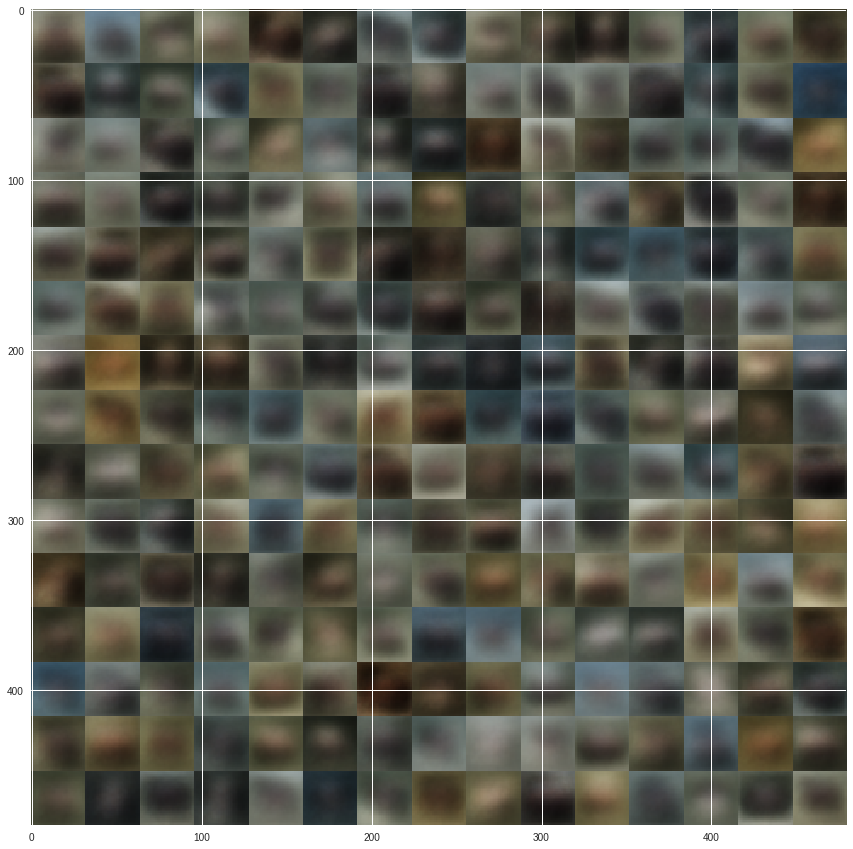

int-64-lat-8-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 174us/step - loss: 2014.6861 - val_loss: 1955.5550
Epoch 2/50
50000/50000 [==============================] - 8s 160us/step - loss: 1926.6045 - val_loss: 1918.7354
Epoch 3/50
42432/50000 [========================>.....] - ETA: 1s - loss: 1907.4459

50000/50000 [==============================] - 8s 161us/step - loss: 1906.5384 - val_loss: 1924.6833
Epoch 4/50
50000/50000 [==============================] - 8s 157us/step - loss: 1901.3606 - val_loss: 1912.9015
Epoch 5/50
50000/50000 [==============================] - 8s 157us/step - loss: 1898.7236 - val_loss: 1900.4205
Epoch 6/50
30400/50000 [=================>............] - ETA: 2s - loss: 1895.8254

50000/50000 [==============================] - 8s 155us/step - loss: 1896.5663 - val_loss: 1890.8913
Epoch 7/50
50000/50000 [==============================] - 8s 157us/step - loss: 1894.6125 - val_loss: 1893.1729
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 1892.6492 - val_loss: 1898.2272
Epoch 9/50
28224/50000 [===============>..............] - ETA: 3s - loss: 1892.7217

50000/50000 [==============================] - 8s 157us/step - loss: 1891.1489 - val_loss: 1899.9202
Epoch 10/50
50000/50000 [==============================] - 8s 160us/step - loss: 1889.3658 - val_loss: 1887.2509
Epoch 11/50
50000/50000 [==============================] - 8s 158us/step - loss: 1887.9501 - val_loss: 1887.9184
Epoch 12/50
27136/50000 [===============>..............] - ETA: 3s - loss: 1887.6675

50000/50000 [==============================] - 8s 159us/step - loss: 1886.8183 - val_loss: 1888.6447
Epoch 13/50
50000/50000 [==============================] - 8s 158us/step - loss: 1885.8182 - val_loss: 1889.4916
Epoch 14/50
50000/50000 [==============================] - 8s 156us/step - loss: 1884.9464 - val_loss: 1896.2269
Epoch 15/50
27008/50000 [===============>..............] - ETA: 3s - loss: 1883.7275

50000/50000 [==============================] - 8s 155us/step - loss: 1884.3903 - val_loss: 1885.4499
Epoch 16/50
50000/50000 [==============================] - 8s 152us/step - loss: 1883.7702 - val_loss: 1884.6178
Epoch 17/50
50000/50000 [==============================] - 8s 155us/step - loss: 1883.2711 - val_loss: 1891.7130
Epoch 18/50
27520/50000 [===============>..............] - ETA: 3s - loss: 1881.1858

50000/50000 [==============================] - 8s 159us/step - loss: 1882.7517 - val_loss: 1887.1065
Epoch 19/50
50000/50000 [==============================] - 8s 154us/step - loss: 1882.2731 - val_loss: 1891.4873
Epoch 20/50
50000/50000 [==============================] - 8s 160us/step - loss: 1881.8613 - val_loss: 1887.0773
Epoch 21/50
26624/50000 [==============>...............] - ETA: 3s - loss: 1882.8294

50000/50000 [==============================] - 8s 159us/step - loss: 1881.4732 - val_loss: 1882.9243
Epoch 22/50
50000/50000 [==============================] - 8s 160us/step - loss: 1881.1766 - val_loss: 1889.4838
Epoch 23/50
50000/50000 [==============================] - 8s 164us/step - loss: 1880.8746 - val_loss: 1885.5250
Epoch 24/50
25920/50000 [==============>...............] - ETA: 3s - loss: 1880.8554

50000/50000 [==============================] - 8s 161us/step - loss: 1880.5552 - val_loss: 1883.6791
Epoch 25/50
50000/50000 [==============================] - 8s 161us/step - loss: 1880.2813 - val_loss: 1891.2414
Epoch 26/50
50000/50000 [==============================] - 8s 156us/step - loss: 1879.9778 - val_loss: 1885.7114
Epoch 27/50
27264/50000 [===============>..............] - ETA: 3s - loss: 1880.6151

50000/50000 [==============================] - 8s 155us/step - loss: 1879.7136 - val_loss: 1886.5940
Epoch 28/50
50000/50000 [==============================] - 8s 155us/step - loss: 1879.5375 - val_loss: 1889.1499
Epoch 29/50
50000/50000 [==============================] - 8s 155us/step - loss: 1879.2476 - val_loss: 1882.6679
Epoch 30/50
27392/50000 [===============>..............] - ETA: 3s - loss: 1880.8477

50000/50000 [==============================] - 8s 153us/step - loss: 1878.9663 - val_loss: 1881.4556
Epoch 31/50
50000/50000 [==============================] - 8s 154us/step - loss: 1878.5950 - val_loss: 1878.5945
Epoch 32/50
50000/50000 [==============================] - 8s 155us/step - loss: 1878.3557 - val_loss: 1882.4443
Epoch 33/50
27392/50000 [===============>..............] - ETA: 3s - loss: 1877.6100

50000/50000 [==============================] - 8s 155us/step - loss: 1878.1966 - val_loss: 1887.6624
Epoch 34/50
50000/50000 [==============================] - 8s 159us/step - loss: 1878.1107 - val_loss: 1879.1370
Epoch 35/50
50000/50000 [==============================] - 8s 156us/step - loss: 1878.0609 - val_loss: 1879.1499
Epoch 36/50
27072/50000 [===============>..............] - ETA: 3s - loss: 1878.1909

50000/50000 [==============================] - 8s 155us/step - loss: 1877.8821 - val_loss: 1881.8194
Epoch 37/50
50000/50000 [==============================] - 8s 154us/step - loss: 1877.7476 - val_loss: 1895.9238
Epoch 38/50
50000/50000 [==============================] - 8s 154us/step - loss: 1877.6673 - val_loss: 1885.7427
Epoch 39/50
27456/50000 [===============>..............] - ETA: 3s - loss: 1877.1626

50000/50000 [==============================] - 8s 156us/step - loss: 1877.6064 - val_loss: 1884.3451
Epoch 40/50
50000/50000 [==============================] - 8s 159us/step - loss: 1877.5529 - val_loss: 1880.3395
Epoch 41/50
50000/50000 [==============================] - 8s 157us/step - loss: 1877.4873 - val_loss: 1880.4446
Epoch 42/50
27264/50000 [===============>..............] - ETA: 3s - loss: 1877.6316

50000/50000 [==============================] - 8s 155us/step - loss: 1877.3621 - val_loss: 1882.5586
Epoch 43/50
50000/50000 [==============================] - 8s 156us/step - loss: 1877.3542 - val_loss: 1879.4588
Epoch 44/50
50000/50000 [==============================] - 8s 161us/step - loss: 1877.2667 - val_loss: 1881.6524
Epoch 45/50
26752/50000 [===============>..............] - ETA: 3s - loss: 1877.2948

50000/50000 [==============================] - 8s 158us/step - loss: 1877.1696 - val_loss: 1882.9303
Epoch 46/50
50000/50000 [==============================] - 8s 155us/step - loss: 1877.2228 - val_loss: 1879.8191
Epoch 47/50
50000/50000 [==============================] - 8s 155us/step - loss: 1877.0466 - val_loss: 1879.9811
Epoch 48/50
27904/50000 [===============>..............] - ETA: 3s - loss: 1878.9780

50000/50000 [==============================] - 8s 156us/step - loss: 1877.0779 - val_loss: 1882.4580
Epoch 49/50
50000/50000 [==============================] - 8s 161us/step - loss: 1877.0351 - val_loss: 1880.1164
Epoch 50/50
50000/50000 [==============================] - 8s 159us/step - loss: 1876.9327 - val_loss: 1887.2097


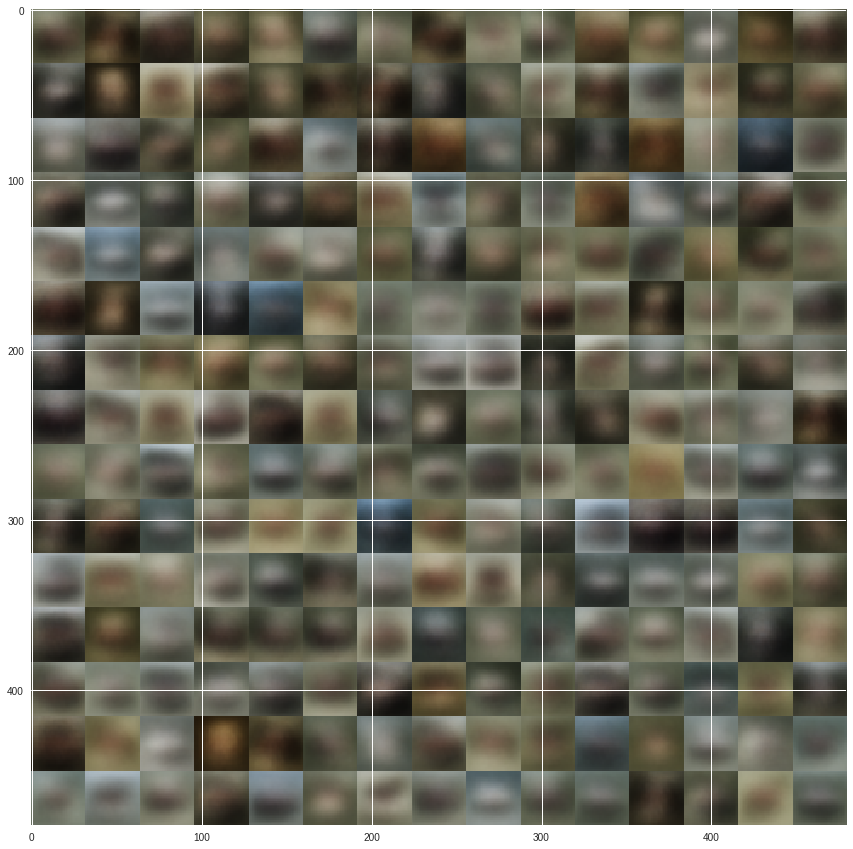

int-64-lat-16-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 176us/step - loss: 1998.2530 - val_loss: 1945.8224
Epoch 2/5
50000/50000 [==============================] - 8s 158us/step - loss: 1923.6190 - val_loss: 1902.4145
Epoch 3/5
43328/50000 [========================>.....] - ETA: 0s - loss: 1908.5487

50000/50000 [==============================] - 8s 159us/step - loss: 1908.2613 - val_loss: 1907.0829
Epoch 4/5
50000/50000 [==============================] - 8s 157us/step - loss: 1899.9389 - val_loss: 1903.2839
Epoch 5/5
50000/50000 [==============================] - 8s 163us/step - loss: 1893.6949 - val_loss: 1890.2382


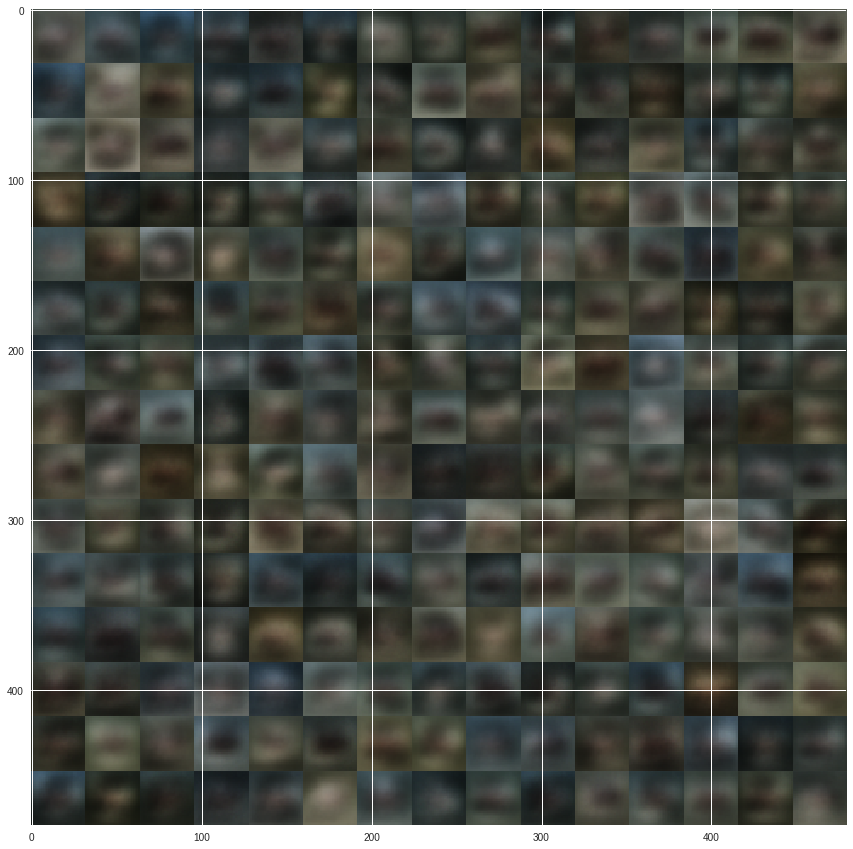

int-64-lat-16-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 181us/step - loss: 1998.3163 - val_loss: 1951.2804
Epoch 2/10
50000/50000 [==============================] - 8s 153us/step - loss: 1947.7981 - val_loss: 1942.6693
Epoch 3/10
42816/50000 [========================>.....] - ETA: 1s - loss: 1924.3089

50000/50000 [==============================] - 8s 155us/step - loss: 1923.5316 - val_loss: 1918.9016
Epoch 4/10
50000/50000 [==============================] - 8s 155us/step - loss: 1912.5527 - val_loss: 1930.9495
Epoch 5/10
50000/50000 [==============================] - 8s 155us/step - loss: 1908.7197 - val_loss: 1921.6016
Epoch 6/10
30592/50000 [=================>............] - ETA: 2s - loss: 1905.7290

50000/50000 [==============================] - 8s 155us/step - loss: 1905.2846 - val_loss: 1910.4451
Epoch 7/10
50000/50000 [==============================] - 8s 158us/step - loss: 1903.1736 - val_loss: 1897.2972
Epoch 8/10
50000/50000 [==============================] - 8s 161us/step - loss: 1901.6643 - val_loss: 1907.9544
Epoch 9/10
28096/50000 [===============>..............] - ETA: 3s - loss: 1901.5077

50000/50000 [==============================] - 8s 159us/step - loss: 1900.5668 - val_loss: 1906.3787
Epoch 10/10
50000/50000 [==============================] - 8s 158us/step - loss: 1899.4010 - val_loss: 1913.2953


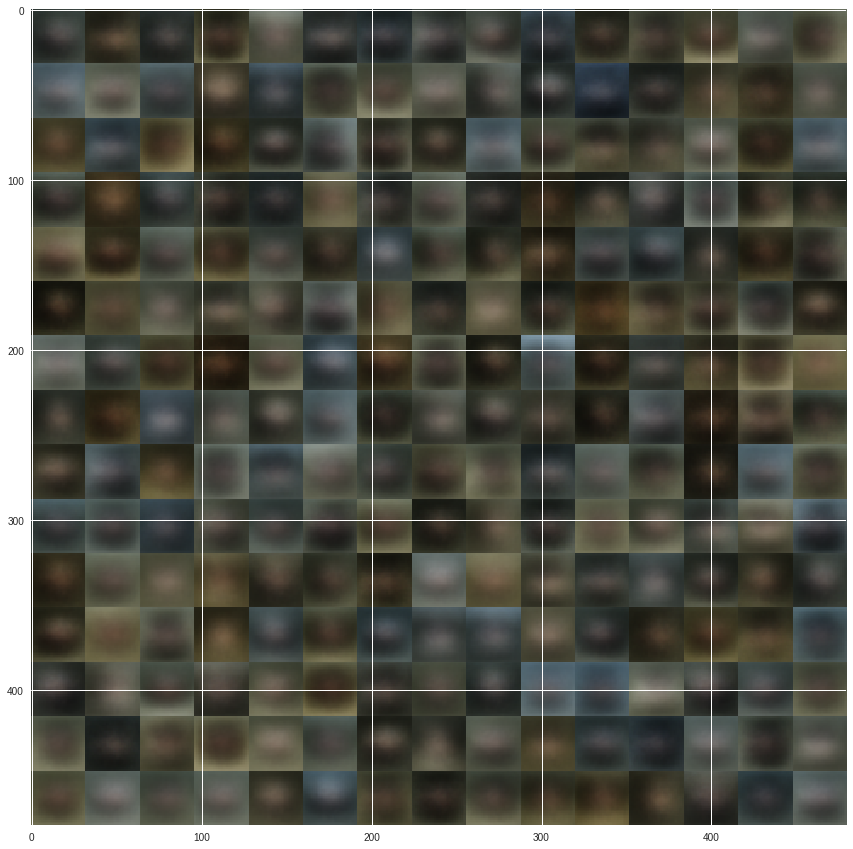

int-64-lat-16-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 183us/step - loss: 2006.3784 - val_loss: 1935.8218
Epoch 2/25
50000/50000 [==============================] - 8s 161us/step - loss: 1924.2789 - val_loss: 1911.5393
Epoch 3/25
40768/50000 [=======================>......] - ETA: 1s - loss: 1903.8022

50000/50000 [==============================] - 8s 161us/step - loss: 1903.4075 - val_loss: 1907.4265
Epoch 4/25
50000/50000 [==============================] - 8s 158us/step - loss: 1895.2342 - val_loss: 1897.5042
Epoch 5/25
50000/50000 [==============================] - 8s 156us/step - loss: 1890.5595 - val_loss: 1888.9037
Epoch 6/25
29824/50000 [================>.............] - ETA: 2s - loss: 1887.5535

50000/50000 [==============================] - 8s 159us/step - loss: 1887.4122 - val_loss: 1883.5878
Epoch 7/25
50000/50000 [==============================] - 8s 161us/step - loss: 1884.5902 - val_loss: 1892.9159
Epoch 8/25
50000/50000 [==============================] - 8s 160us/step - loss: 1882.3990 - val_loss: 1887.3386
Epoch 9/25
27712/50000 [===============>..............] - ETA: 3s - loss: 1881.2376

50000/50000 [==============================] - 8s 155us/step - loss: 1880.4718 - val_loss: 1883.8662
Epoch 10/25
50000/50000 [==============================] - 8s 161us/step - loss: 1877.9057 - val_loss: 1890.4888
Epoch 11/25
50000/50000 [==============================] - 8s 159us/step - loss: 1875.9058 - val_loss: 1868.9910
Epoch 12/25
26816/50000 [===============>..............] - ETA: 3s - loss: 1875.2225

50000/50000 [==============================] - 8s 157us/step - loss: 1874.2498 - val_loss: 1873.5742
Epoch 13/25
50000/50000 [==============================] - 8s 157us/step - loss: 1872.8304 - val_loss: 1874.3681
Epoch 14/25
50000/50000 [==============================] - 8s 161us/step - loss: 1871.9234 - val_loss: 1876.3274
Epoch 15/25
26304/50000 [==============>...............] - ETA: 3s - loss: 1870.3731

50000/50000 [==============================] - 8s 154us/step - loss: 1870.9715 - val_loss: 1870.9036
Epoch 16/25
50000/50000 [==============================] - 8s 158us/step - loss: 1870.3878 - val_loss: 1870.9638
Epoch 17/25
50000/50000 [==============================] - 8s 162us/step - loss: 1869.1950 - val_loss: 1878.7741
Epoch 18/25
26368/50000 [==============>...............] - ETA: 3s - loss: 1869.0345

50000/50000 [==============================] - 8s 158us/step - loss: 1867.8095 - val_loss: 1874.4529
Epoch 19/25
50000/50000 [==============================] - 8s 153us/step - loss: 1866.9242 - val_loss: 1866.1319
Epoch 20/25
50000/50000 [==============================] - 8s 156us/step - loss: 1866.2759 - val_loss: 1868.3830
Epoch 21/25
26176/50000 [==============>...............] - ETA: 3s - loss: 1866.5131

50000/50000 [==============================] - 8s 164us/step - loss: 1865.7792 - val_loss: 1869.0814
Epoch 22/25
50000/50000 [==============================] - 8s 160us/step - loss: 1865.1991 - val_loss: 1871.3635
Epoch 23/25
50000/50000 [==============================] - 8s 155us/step - loss: 1864.8910 - val_loss: 1862.6778
Epoch 24/25
27712/50000 [===============>..............] - ETA: 3s - loss: 1866.1803

50000/50000 [==============================] - 8s 155us/step - loss: 1864.5132 - val_loss: 1865.8004
Epoch 25/25
50000/50000 [==============================] - 8s 153us/step - loss: 1864.0748 - val_loss: 1865.9558


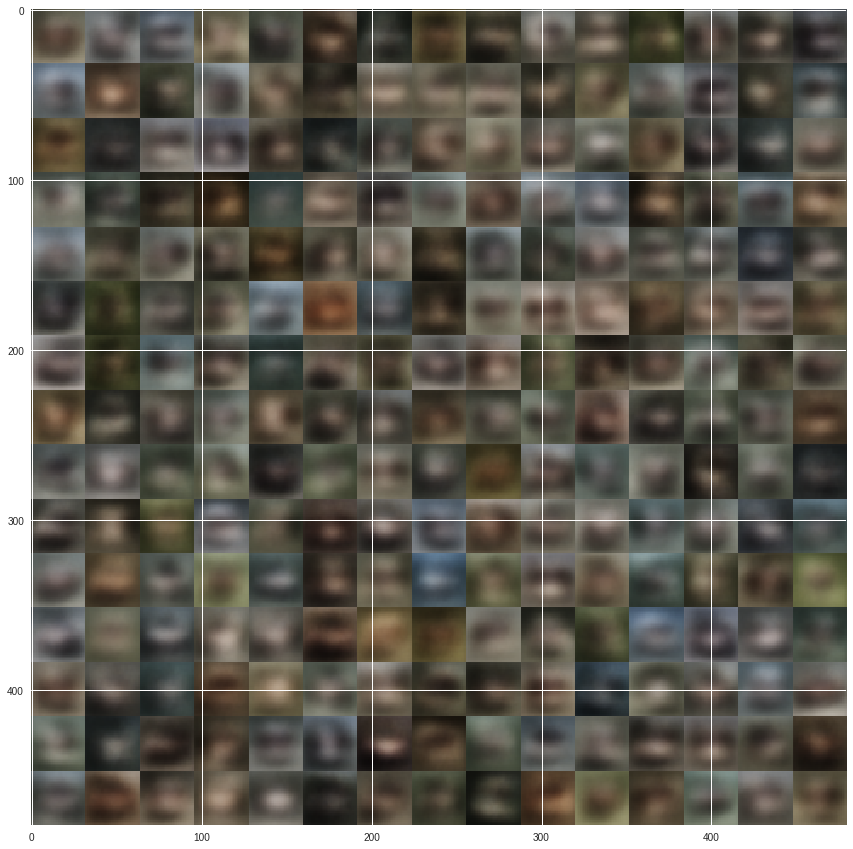

int-64-lat-16-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 178us/step - loss: 1994.5557 - val_loss: 1953.8664
Epoch 2/50
50000/50000 [==============================] - 8s 153us/step - loss: 1924.2748 - val_loss: 1913.7397
Epoch 3/50
42304/50000 [========================>.....] - ETA: 1s - loss: 1907.0976

50000/50000 [==============================] - 8s 162us/step - loss: 1907.1114 - val_loss: 1934.2659
Epoch 4/50
50000/50000 [==============================] - 8s 166us/step - loss: 1901.8609 - val_loss: 1909.5911
Epoch 5/50
50000/50000 [==============================] - 8s 164us/step - loss: 1896.7309 - val_loss: 1902.6200
Epoch 6/50
27904/50000 [===============>..............] - ETA: 3s - loss: 1892.6366

50000/50000 [==============================] - 8s 159us/step - loss: 1892.3751 - val_loss: 1901.6693
Epoch 7/50
50000/50000 [==============================] - 8s 158us/step - loss: 1889.2345 - val_loss: 1887.5752
Epoch 8/50
50000/50000 [==============================] - 8s 152us/step - loss: 1886.7944 - val_loss: 1888.9771
Epoch 9/50
28800/50000 [================>.............] - ETA: 2s - loss: 1885.8312

50000/50000 [==============================] - 8s 151us/step - loss: 1884.9233 - val_loss: 1913.5099
Epoch 10/50
50000/50000 [==============================] - 8s 155us/step - loss: 1883.6248 - val_loss: 1890.9177
Epoch 11/50
50000/50000 [==============================] - 8s 153us/step - loss: 1882.3388 - val_loss: 1897.1614
Epoch 12/50
27904/50000 [===============>..............] - ETA: 3s - loss: 1882.5567

50000/50000 [==============================] - 8s 152us/step - loss: 1881.2871 - val_loss: 1883.1689
Epoch 13/50
50000/50000 [==============================] - 8s 154us/step - loss: 1880.3814 - val_loss: 1881.4912
Epoch 14/50
50000/50000 [==============================] - 8s 158us/step - loss: 1879.5233 - val_loss: 1878.8355
Epoch 15/50
27968/50000 [===============>..............] - ETA: 3s - loss: 1878.7575

50000/50000 [==============================] - 8s 155us/step - loss: 1878.6342 - val_loss: 1891.7092
Epoch 16/50
50000/50000 [==============================] - 8s 159us/step - loss: 1878.0450 - val_loss: 1881.4168
Epoch 17/50
50000/50000 [==============================] - 8s 161us/step - loss: 1877.3308 - val_loss: 1877.7820
Epoch 18/50
26944/50000 [===============>..............] - ETA: 3s - loss: 1875.5502

50000/50000 [==============================] - 8s 156us/step - loss: 1876.8200 - val_loss: 1875.9758
Epoch 19/50
50000/50000 [==============================] - 8s 155us/step - loss: 1876.3430 - val_loss: 1879.6353
Epoch 20/50
50000/50000 [==============================] - 8s 156us/step - loss: 1875.7619 - val_loss: 1878.2582
Epoch 21/50
27648/50000 [===============>..............] - ETA: 3s - loss: 1874.5884

50000/50000 [==============================] - 8s 152us/step - loss: 1875.4009 - val_loss: 1877.9014
Epoch 22/50
50000/50000 [==============================] - 8s 155us/step - loss: 1874.9079 - val_loss: 1882.2501
Epoch 23/50
50000/50000 [==============================] - 8s 156us/step - loss: 1874.5484 - val_loss: 1874.5553
Epoch 24/50
27392/50000 [===============>..............] - ETA: 3s - loss: 1874.7234

50000/50000 [==============================] - 8s 160us/step - loss: 1874.2339 - val_loss: 1889.9391
Epoch 25/50
50000/50000 [==============================] - 8s 158us/step - loss: 1873.9277 - val_loss: 1872.0839
Epoch 26/50
50000/50000 [==============================] - 8s 155us/step - loss: 1873.6635 - val_loss: 1871.6383
Epoch 27/50
27968/50000 [===============>..............] - ETA: 3s - loss: 1873.2855

50000/50000 [==============================] - 8s 155us/step - loss: 1873.3498 - val_loss: 1879.1481
Epoch 28/50
50000/50000 [==============================] - 8s 159us/step - loss: 1873.0889 - val_loss: 1878.2198
Epoch 29/50
50000/50000 [==============================] - 8s 161us/step - loss: 1872.8196 - val_loss: 1875.4097
Epoch 30/50
27008/50000 [===============>..............] - ETA: 3s - loss: 1871.8491

50000/50000 [==============================] - 8s 159us/step - loss: 1872.6757 - val_loss: 1877.8130
Epoch 31/50
50000/50000 [==============================] - 8s 157us/step - loss: 1872.5259 - val_loss: 1879.3271
Epoch 32/50
50000/50000 [==============================] - 8s 153us/step - loss: 1872.2897 - val_loss: 1882.7016
Epoch 33/50
27264/50000 [===============>..............] - ETA: 3s - loss: 1872.9896

50000/50000 [==============================] - 8s 157us/step - loss: 1872.0975 - val_loss: 1878.8391
Epoch 34/50
50000/50000 [==============================] - 8s 157us/step - loss: 1872.0233 - val_loss: 1871.7705
Epoch 35/50
50000/50000 [==============================] - 8s 157us/step - loss: 1871.7761 - val_loss: 1885.9459
Epoch 36/50
27136/50000 [===============>..............] - ETA: 3s - loss: 1872.8469

50000/50000 [==============================] - 8s 156us/step - loss: 1871.7214 - val_loss: 1877.3896
Epoch 37/50
50000/50000 [==============================] - 8s 156us/step - loss: 1871.4522 - val_loss: 1874.8708
Epoch 38/50
50000/50000 [==============================] - 8s 157us/step - loss: 1871.1497 - val_loss: 1872.8392
Epoch 39/50
27456/50000 [===============>..............] - ETA: 3s - loss: 1870.5609

50000/50000 [==============================] - 8s 159us/step - loss: 1870.9679 - val_loss: 1872.7474
Epoch 40/50
50000/50000 [==============================] - 8s 157us/step - loss: 1870.8208 - val_loss: 1889.3081
Epoch 41/50
50000/50000 [==============================] - 8s 160us/step - loss: 1870.6978 - val_loss: 1880.3503
Epoch 42/50
25920/50000 [==============>...............] - ETA: 3s - loss: 1870.3039

50000/50000 [==============================] - 8s 161us/step - loss: 1870.5940 - val_loss: 1869.7484
Epoch 43/50
50000/50000 [==============================] - 8s 156us/step - loss: 1870.5531 - val_loss: 1873.1108
Epoch 44/50
50000/50000 [==============================] - 8s 156us/step - loss: 1870.4489 - val_loss: 1873.2131
Epoch 45/50
27136/50000 [===============>..............] - ETA: 3s - loss: 1869.0065

50000/50000 [==============================] - 8s 156us/step - loss: 1870.3051 - val_loss: 1888.9339
Epoch 46/50
50000/50000 [==============================] - 8s 154us/step - loss: 1870.2560 - val_loss: 1879.5097
Epoch 47/50
50000/50000 [==============================] - 8s 161us/step - loss: 1870.1807 - val_loss: 1874.6914
Epoch 48/50
26880/50000 [===============>..............] - ETA: 3s - loss: 1870.3686

50000/50000 [==============================] - 8s 156us/step - loss: 1870.1128 - val_loss: 1870.1664
Epoch 49/50
50000/50000 [==============================] - 8s 161us/step - loss: 1869.9993 - val_loss: 1882.3369
Epoch 50/50
50000/50000 [==============================] - 8s 158us/step - loss: 1869.9287 - val_loss: 1877.4179


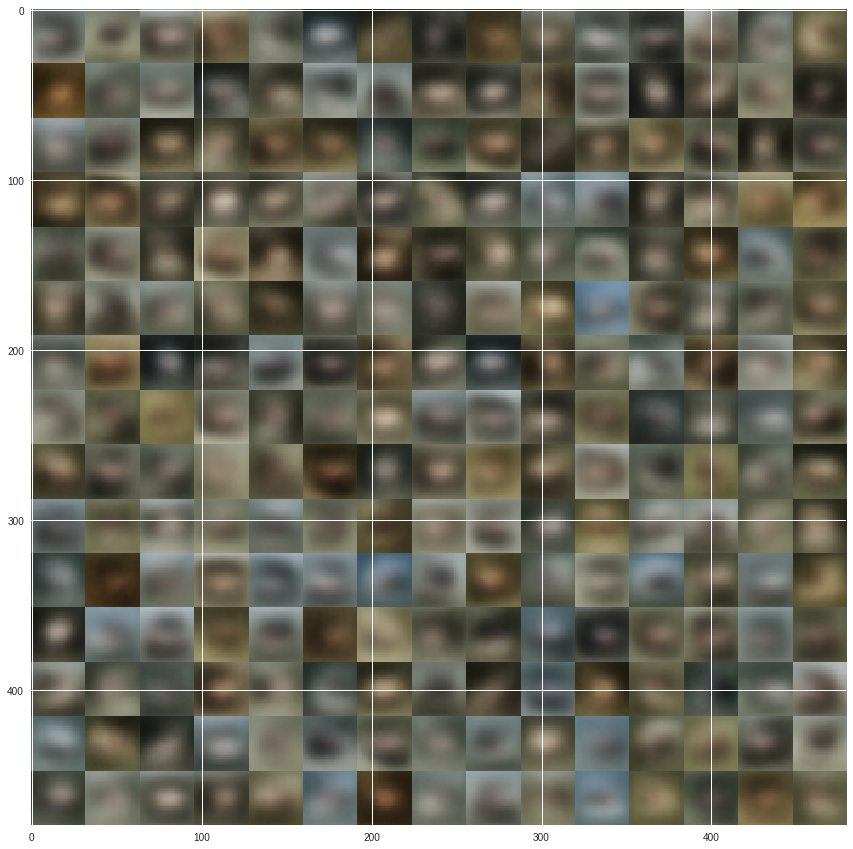

int-64-lat-32-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 178us/step - loss: 2010.7889 - val_loss: 1963.4398
Epoch 2/5
50000/50000 [==============================] - 8s 157us/step - loss: 1948.2436 - val_loss: 1957.7237
Epoch 3/5
43328/50000 [========================>.....] - ETA: 0s - loss: 1933.1936

50000/50000 [==============================] - 8s 161us/step - loss: 1932.3358 - val_loss: 1929.6376
Epoch 4/5
50000/50000 [==============================] - 8s 160us/step - loss: 1924.3854 - val_loss: 1931.9078
Epoch 5/5
50000/50000 [==============================] - 8s 159us/step - loss: 1918.5651 - val_loss: 1920.5206


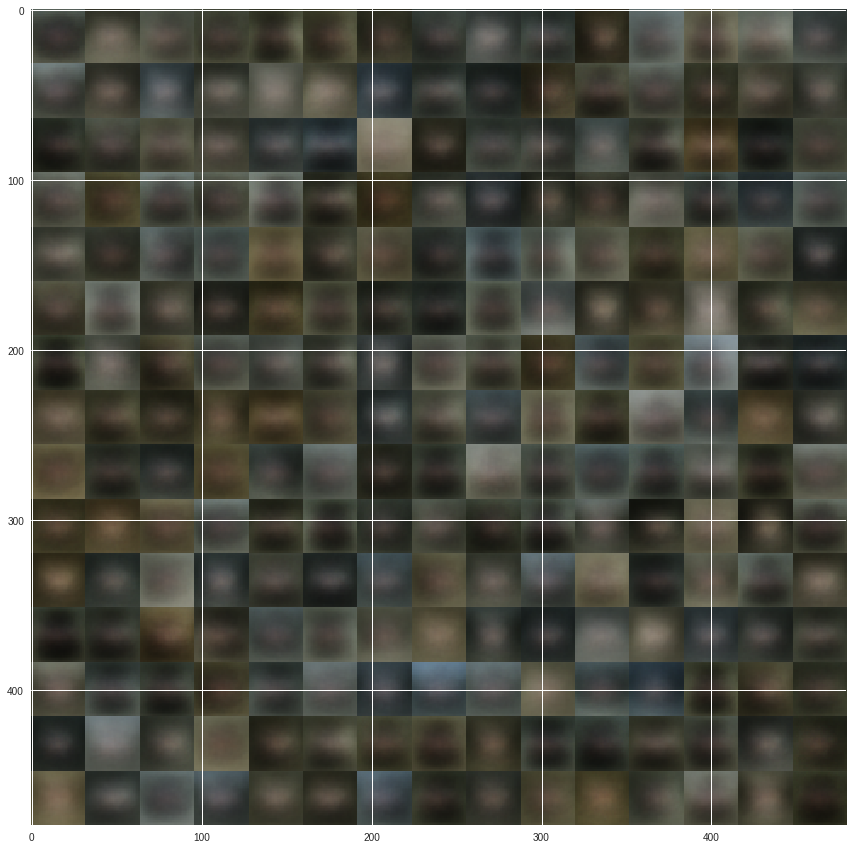

int-64-lat-32-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 183us/step - loss: 2011.3007 - val_loss: 1976.0182
Epoch 2/10
50000/50000 [==============================] - 8s 159us/step - loss: 1951.1664 - val_loss: 1946.3150
Epoch 3/10
42432/50000 [========================>.....] - ETA: 1s - loss: 1940.3005

50000/50000 [==============================] - 8s 158us/step - loss: 1939.8128 - val_loss: 1942.2685
Epoch 4/10
50000/50000 [==============================] - 8s 158us/step - loss: 1932.4991 - val_loss: 1919.8223
Epoch 5/10
50000/50000 [==============================] - 8s 162us/step - loss: 1917.5883 - val_loss: 1910.1001
Epoch 6/10
29440/50000 [================>.............] - ETA: 2s - loss: 1910.3376

50000/50000 [==============================] - 8s 157us/step - loss: 1909.0309 - val_loss: 1916.4918
Epoch 7/10
50000/50000 [==============================] - 8s 160us/step - loss: 1905.5214 - val_loss: 1901.2925
Epoch 8/10
50000/50000 [==============================] - 8s 159us/step - loss: 1903.1138 - val_loss: 1897.4588
Epoch 9/10
27776/50000 [===============>..............] - ETA: 3s - loss: 1902.0983

50000/50000 [==============================] - 8s 157us/step - loss: 1901.3407 - val_loss: 1909.7471
Epoch 10/10
50000/50000 [==============================] - 8s 157us/step - loss: 1899.9073 - val_loss: 1911.6988


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 509.4K of output have been discarded. 

int-64-lat-32-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 184us/step - loss: 2011.6145 - val_loss: 1941.6206
Epoch 2/25
50000/50000 [==============================] - 8s 158us/step - loss: 1936.4622 - val_loss: 1944.5079
Epoch 3/25
41344/50000 [=======================>......] - ETA: 1s - loss: 1919.7049

50000/50000 [==============================] - 8s 162us/step - loss: 1919.0499 - val_loss: 1906.1848
Epoch 4/25
50000/50000 [==============================] - 8s 159us/step - loss: 1911.0442 - val_loss: 1902.3585
Epoch 5/25
50000/50000 [==============================] - 8s 159us/step - loss: 1903.6851 - val_loss: 1891.7501
Epoch 6/25
29952/50000 [================>.............] - ETA: 2s - loss: 1899.2101

50000/50000 [==============================] - 8s 157us/step - loss: 1897.8672 - val_loss: 1887.0601
Epoch 7/25
50000/50000 [==============================] - 8s 160us/step - loss: 1892.1858 - val_loss: 1898.6017
Epoch 8/25
50000/50000 [==============================] - 8s 158us/step - loss: 1888.4001 - val_loss: 1885.7108
Epoch 9/25
26880/50000 [===============>..............] - ETA: 3s - loss: 1887.0253

50000/50000 [==============================] - 8s 162us/step - loss: 1885.3701 - val_loss: 1886.8218
Epoch 10/25
50000/50000 [==============================] - 8s 157us/step - loss: 1882.2284 - val_loss: 1896.5117
Epoch 11/25
50000/50000 [==============================] - 8s 156us/step - loss: 1879.5337 - val_loss: 1894.2609
Epoch 12/25
27456/50000 [===============>..............] - ETA: 3s - loss: 1877.5919

50000/50000 [==============================] - 8s 156us/step - loss: 1877.9548 - val_loss: 1879.8975
Epoch 13/25
50000/50000 [==============================] - 8s 158us/step - loss: 1876.5654 - val_loss: 1882.8946
Epoch 14/25
50000/50000 [==============================] - 8s 158us/step - loss: 1875.2259 - val_loss: 1878.1861
Epoch 15/25
26432/50000 [==============>...............] - ETA: 3s - loss: 1872.8678

50000/50000 [==============================] - 8s 155us/step - loss: 1874.0097 - val_loss: 1893.6595
Epoch 16/25
50000/50000 [==============================] - 8s 163us/step - loss: 1873.2144 - val_loss: 1870.1977
Epoch 17/25
50000/50000 [==============================] - 8s 166us/step - loss: 1872.3550 - val_loss: 1873.7639
Epoch 18/25
25344/50000 [==============>...............] - ETA: 3s - loss: 1872.4667

50000/50000 [==============================] - 8s 162us/step - loss: 1871.7265 - val_loss: 1868.4535
Epoch 19/25
50000/50000 [==============================] - 8s 164us/step - loss: 1871.1894 - val_loss: 1875.8113
Epoch 20/25
50000/50000 [==============================] - 8s 163us/step - loss: 1870.7119 - val_loss: 1871.6403
Epoch 21/25
24960/50000 [=============>................] - ETA: 3s - loss: 1870.2723

50000/50000 [==============================] - 8s 156us/step - loss: 1870.2070 - val_loss: 1880.8075
Epoch 22/25
50000/50000 [==============================] - 8s 163us/step - loss: 1869.9172 - val_loss: 1872.2926
Epoch 23/25
50000/50000 [==============================] - 8s 164us/step - loss: 1869.4116 - val_loss: 1868.1161
Epoch 24/25
25472/50000 [==============>...............] - ETA: 3s - loss: 1869.6231

50000/50000 [==============================] - 8s 157us/step - loss: 1869.0444 - val_loss: 1871.6776
Epoch 25/25
50000/50000 [==============================] - 8s 160us/step - loss: 1868.7767 - val_loss: 1868.6244


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 550K of output have been discarded. 

int-64-lat-32-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 185us/step - loss: 2026.2928 - val_loss: 2009.3768
Epoch 2/50
50000/50000 [==============================] - 8s 154us/step - loss: 1987.7953 - val_loss: 1992.3322
Epoch 3/50
42560/50000 [========================>.....] - ETA: 1s - loss: 1978.7973

50000/50000 [==============================] - 8s 159us/step - loss: 1978.7416 - val_loss: 1973.9834
Epoch 4/50
50000/50000 [==============================] - 8s 161us/step - loss: 1961.5525 - val_loss: 1952.1869
Epoch 5/50
50000/50000 [==============================] - 8s 162us/step - loss: 1949.5627 - val_loss: 1947.2848
Epoch 6/50
29888/50000 [================>.............] - ETA: 2s - loss: 1945.5802

50000/50000 [==============================] - 8s 159us/step - loss: 1945.4835 - val_loss: 1951.6419
Epoch 7/50
50000/50000 [==============================] - 8s 158us/step - loss: 1943.1322 - val_loss: 1944.3993
Epoch 8/50
50000/50000 [==============================] - 8s 155us/step - loss: 1941.4167 - val_loss: 1950.5410
Epoch 9/50
28480/50000 [================>.............] - ETA: 3s - loss: 1940.4001

50000/50000 [==============================] - 8s 162us/step - loss: 1940.3951 - val_loss: 1948.9155
Epoch 10/50
50000/50000 [==============================] - 8s 166us/step - loss: 1939.3421 - val_loss: 1943.5280
Epoch 11/50
50000/50000 [==============================] - 8s 164us/step - loss: 1938.6212 - val_loss: 1948.3477
Epoch 12/50
24960/50000 [=============>................] - ETA: 3s - loss: 1938.0592

50000/50000 [==============================] - 8s 159us/step - loss: 1937.9746 - val_loss: 1940.3681
Epoch 13/50
50000/50000 [==============================] - 8s 161us/step - loss: 1937.3788 - val_loss: 1936.5809
Epoch 14/50
50000/50000 [==============================] - 8s 160us/step - loss: 1936.8971 - val_loss: 1939.1573
Epoch 15/50
26240/50000 [==============>...............] - ETA: 3s - loss: 1937.3602

50000/50000 [==============================] - 8s 160us/step - loss: 1936.4560 - val_loss: 1941.1369
Epoch 16/50
50000/50000 [==============================] - 8s 158us/step - loss: 1936.0366 - val_loss: 1934.4742
Epoch 17/50
50000/50000 [==============================] - 8s 155us/step - loss: 1935.6113 - val_loss: 1938.2564
Epoch 18/50
27136/50000 [===============>..............] - ETA: 3s - loss: 1933.5687

50000/50000 [==============================] - 8s 157us/step - loss: 1930.3179 - val_loss: 1925.6881
Epoch 19/50
50000/50000 [==============================] - 8s 156us/step - loss: 1924.6959 - val_loss: 1928.2978
Epoch 20/50
50000/50000 [==============================] - 8s 156us/step - loss: 1923.0492 - val_loss: 1922.4183
Epoch 21/50
27648/50000 [===============>..............] - ETA: 3s - loss: 1923.4582

50000/50000 [==============================] - 8s 156us/step - loss: 1922.4061 - val_loss: 1930.4049
Epoch 22/50
50000/50000 [==============================] - 8s 157us/step - loss: 1922.0250 - val_loss: 1922.1386
Epoch 23/50
50000/50000 [==============================] - 8s 157us/step - loss: 1921.7617 - val_loss: 1920.1051
Epoch 24/50
27008/50000 [===============>..............] - ETA: 3s - loss: 1921.7355

50000/50000 [==============================] - 8s 159us/step - loss: 1921.4344 - val_loss: 1923.8023
Epoch 25/50
50000/50000 [==============================] - 8s 161us/step - loss: 1921.1502 - val_loss: 1925.8381
Epoch 26/50
50000/50000 [==============================] - 8s 155us/step - loss: 1920.9674 - val_loss: 1926.3680
Epoch 27/50
27584/50000 [===============>..............] - ETA: 3s - loss: 1919.8960

50000/50000 [==============================] - 8s 155us/step - loss: 1920.8203 - val_loss: 1928.1406
Epoch 28/50
50000/50000 [==============================] - 8s 156us/step - loss: 1920.7105 - val_loss: 1918.6597
Epoch 29/50
50000/50000 [==============================] - 8s 156us/step - loss: 1920.5244 - val_loss: 1920.5281
Epoch 30/50
27904/50000 [===============>..............] - ETA: 3s - loss: 1920.4280

50000/50000 [==============================] - 8s 154us/step - loss: 1920.5380 - val_loss: 1919.5522
Epoch 31/50
50000/50000 [==============================] - 8s 155us/step - loss: 1920.3718 - val_loss: 1920.8382
Epoch 32/50
50000/50000 [==============================] - 8s 160us/step - loss: 1920.2689 - val_loss: 1921.9690
Epoch 33/50
27008/50000 [===============>..............] - ETA: 3s - loss: 1920.7079

50000/50000 [==============================] - 8s 160us/step - loss: 1920.1566 - val_loss: 1920.9230
Epoch 34/50
50000/50000 [==============================] - 8s 161us/step - loss: 1920.0749 - val_loss: 1926.4819
Epoch 35/50
50000/50000 [==============================] - 8s 158us/step - loss: 1920.1034 - val_loss: 1919.6496
Epoch 36/50
27072/50000 [===============>..............] - ETA: 3s - loss: 1921.9971

50000/50000 [==============================] - 8s 156us/step - loss: 1919.9760 - val_loss: 1923.1808
Epoch 37/50
50000/50000 [==============================] - 8s 161us/step - loss: 1919.8582 - val_loss: 1924.3753
Epoch 38/50
50000/50000 [==============================] - 8s 157us/step - loss: 1919.9035 - val_loss: 1924.9583
Epoch 39/50
26432/50000 [==============>...............] - ETA: 3s - loss: 1919.8993

50000/50000 [==============================] - 8s 160us/step - loss: 1919.8062 - val_loss: 1924.4601
Epoch 40/50
50000/50000 [==============================] - 8s 164us/step - loss: 1919.7650 - val_loss: 1918.0940
Epoch 41/50
50000/50000 [==============================] - 8s 162us/step - loss: 1919.6573 - val_loss: 1928.1122
Epoch 42/50
25728/50000 [==============>...............] - ETA: 3s - loss: 1918.7892

50000/50000 [==============================] - 8s 162us/step - loss: 1919.7088 - val_loss: 1929.6904
Epoch 43/50
50000/50000 [==============================] - 8s 165us/step - loss: 1919.6447 - val_loss: 1919.5343
Epoch 44/50
50000/50000 [==============================] - 8s 163us/step - loss: 1919.6271 - val_loss: 1920.8111
Epoch 45/50
24768/50000 [=============>................] - ETA: 3s - loss: 1919.6289

50000/50000 [==============================] - 8s 160us/step - loss: 1919.5123 - val_loss: 1923.3264
Epoch 46/50
50000/50000 [==============================] - 8s 156us/step - loss: 1919.4959 - val_loss: 1929.5108
Epoch 47/50
50000/50000 [==============================] - 8s 160us/step - loss: 1919.4648 - val_loss: 1920.3029
Epoch 48/50
27008/50000 [===============>..............] - ETA: 3s - loss: 1918.6491

50000/50000 [==============================] - 8s 159us/step - loss: 1919.4457 - val_loss: 1922.6016
Epoch 49/50
50000/50000 [==============================] - 8s 156us/step - loss: 1919.3814 - val_loss: 1918.3472
Epoch 50/50
50000/50000 [==============================] - 8s 162us/step - loss: 1919.3552 - val_loss: 1923.0325


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 487.9K of output have been discarded. 

int-128-lat-2-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 10s 203us/step - loss: 2012.2372 - val_loss: 1972.1223
Epoch 2/5
50000/50000 [==============================] - 8s 168us/step - loss: 1967.8881 - val_loss: 1966.2687
Epoch 3/5
36736/50000 [=====================>........] - ETA: 2s - loss: 1965.2112

50000/50000 [==============================] - 8s 167us/step - loss: 1965.2370 - val_loss: 1965.2834
Epoch 4/5
50000/50000 [==============================] - 8s 168us/step - loss: 1963.3341 - val_loss: 1964.3778
Epoch 5/5
50000/50000 [==============================] - 8s 163us/step - loss: 1962.5471 - val_loss: 1971.4606


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 521K of output have been discarded. 

int-128-lat-2-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 198us/step - loss: 2006.5621 - val_loss: 1972.1864
Epoch 2/10
50000/50000 [==============================] - 8s 165us/step - loss: 1968.5924 - val_loss: 1991.0260
Epoch 3/10
37440/50000 [=====================>........] - ETA: 1s - loss: 1965.9289

50000/50000 [==============================] - 8s 166us/step - loss: 1965.3419 - val_loss: 1976.4788
Epoch 4/10
50000/50000 [==============================] - 8s 164us/step - loss: 1963.3689 - val_loss: 1962.4143
Epoch 5/10
50000/50000 [==============================] - 8s 163us/step - loss: 1962.1589 - val_loss: 1965.2313
Epoch 6/10
28352/50000 [================>.............] - ETA: 3s - loss: 1961.7957

50000/50000 [==============================] - 8s 164us/step - loss: 1961.3271 - val_loss: 1961.1587
Epoch 7/10
50000/50000 [==============================] - 8s 163us/step - loss: 1960.6590 - val_loss: 1960.9187
Epoch 8/10
50000/50000 [==============================] - 8s 163us/step - loss: 1960.1319 - val_loss: 1968.1939
Epoch 9/10
24832/50000 [=============>................] - ETA: 3s - loss: 1960.1458

50000/50000 [==============================] - 8s 166us/step - loss: 1959.7594 - val_loss: 1962.4741
Epoch 10/10
50000/50000 [==============================] - 8s 168us/step - loss: 1959.4525 - val_loss: 1966.7481


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 499.3K of output have been discarded. 

int-128-lat-2-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 199us/step - loss: 2006.0680 - val_loss: 1967.6168
Epoch 2/25
50000/50000 [==============================] - 8s 168us/step - loss: 1966.5100 - val_loss: 1964.2720
Epoch 3/25
38592/50000 [======================>.......] - ETA: 1s - loss: 1963.4206

50000/50000 [==============================] - 8s 163us/step - loss: 1963.4427 - val_loss: 1963.1525
Epoch 4/25
50000/50000 [==============================] - 8s 164us/step - loss: 1962.1603 - val_loss: 1964.5735
Epoch 5/25
50000/50000 [==============================] - 8s 161us/step - loss: 1961.3251 - val_loss: 1964.8196
Epoch 6/25
27456/50000 [===============>..............] - ETA: 3s - loss: 1959.8094

50000/50000 [==============================] - 8s 165us/step - loss: 1960.5841 - val_loss: 1962.0801
Epoch 7/25
50000/50000 [==============================] - 8s 169us/step - loss: 1960.0313 - val_loss: 1963.2167
Epoch 8/25
50000/50000 [==============================] - 8s 166us/step - loss: 1959.6402 - val_loss: 1962.4853
Epoch 9/25
24192/50000 [=============>................] - ETA: 3s - loss: 1959.0884

50000/50000 [==============================] - 8s 162us/step - loss: 1959.2788 - val_loss: 1959.8118
Epoch 10/25
50000/50000 [==============================] - 8s 168us/step - loss: 1959.3071 - val_loss: 1960.0830
Epoch 11/25
50000/50000 [==============================] - 8s 165us/step - loss: 1958.7044 - val_loss: 1960.1906
Epoch 12/25
22592/50000 [============>.................] - ETA: 4s - loss: 1958.6598

50000/50000 [==============================] - 8s 164us/step - loss: 1958.4288 - val_loss: 1958.9220
Epoch 13/25
50000/50000 [==============================] - 8s 163us/step - loss: 1958.2316 - val_loss: 1959.2673
Epoch 14/25
50000/50000 [==============================] - 8s 164us/step - loss: 1958.0183 - val_loss: 1963.3754
Epoch 15/25
23040/50000 [============>.................] - ETA: 4s - loss: 1955.8908

50000/50000 [==============================] - 8s 168us/step - loss: 1957.6458 - val_loss: 1962.0025
Epoch 16/25
50000/50000 [==============================] - 8s 165us/step - loss: 1957.3716 - val_loss: 1957.6717
Epoch 17/25
50000/50000 [==============================] - 8s 169us/step - loss: 1957.1952 - val_loss: 1958.5540
Epoch 18/25
20096/50000 [===========>..................] - ETA: 4s - loss: 1957.5256

50000/50000 [==============================] - 9s 170us/step - loss: 1957.0358 - val_loss: 1958.1151
Epoch 19/25
50000/50000 [==============================] - 8s 169us/step - loss: 1956.9120 - val_loss: 1957.6506
Epoch 20/25
50000/50000 [==============================] - 8s 165us/step - loss: 1956.7818 - val_loss: 1958.8681
Epoch 21/25
21312/50000 [===========>..................] - ETA: 4s - loss: 1956.3422

50000/50000 [==============================] - 8s 167us/step - loss: 1956.6303 - val_loss: 1962.0648
Epoch 22/25
50000/50000 [==============================] - 8s 167us/step - loss: 1956.5537 - val_loss: 1957.8491
Epoch 23/25
50000/50000 [==============================] - 8s 166us/step - loss: 1956.4470 - val_loss: 1956.4373
Epoch 24/25
21312/50000 [===========>..................] - ETA: 4s - loss: 1956.7669

50000/50000 [==============================] - 8s 166us/step - loss: 1956.1980 - val_loss: 1961.6496
Epoch 25/25
50000/50000 [==============================] - 8s 168us/step - loss: 1956.0241 - val_loss: 1959.6203


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 505.4K of output have been discarded. 

int-128-lat-2-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 205us/step - loss: 2012.5661 - val_loss: 1975.7247
Epoch 2/50
50000/50000 [==============================] - 8s 163us/step - loss: 1971.4989 - val_loss: 1968.7225
Epoch 3/50
40064/50000 [=======================>......] - ETA: 1s - loss: 1966.0487

50000/50000 [==============================] - 8s 161us/step - loss: 1966.4327 - val_loss: 1965.5449
Epoch 4/50
50000/50000 [==============================] - 8s 162us/step - loss: 1964.0820 - val_loss: 1968.5101
Epoch 5/50
50000/50000 [==============================] - 8s 168us/step - loss: 1962.6406 - val_loss: 1964.9388
Epoch 6/50
27584/50000 [===============>..............] - ETA: 3s - loss: 1961.3602

50000/50000 [==============================] - 8s 164us/step - loss: 1961.9365 - val_loss: 1961.9524
Epoch 7/50
50000/50000 [==============================] - 8s 169us/step - loss: 1961.3741 - val_loss: 1961.6274
Epoch 8/50
50000/50000 [==============================] - 8s 169us/step - loss: 1961.1356 - val_loss: 1960.1543
Epoch 9/50
22400/50000 [============>.................] - ETA: 4s - loss: 1960.6364

50000/50000 [==============================] - 8s 161us/step - loss: 1960.4340 - val_loss: 1962.7867
Epoch 10/50
50000/50000 [==============================] - 9s 170us/step - loss: 1959.9676 - val_loss: 1961.2224
Epoch 11/50
50000/50000 [==============================] - 8s 169us/step - loss: 1959.5631 - val_loss: 1960.8883
Epoch 12/50
19136/50000 [==========>...................] - ETA: 4s - loss: 1958.0636

50000/50000 [==============================] - 9s 172us/step - loss: 1959.1231 - val_loss: 1960.9094
Epoch 13/50
50000/50000 [==============================] - 8s 164us/step - loss: 1958.8081 - val_loss: 1959.5811
Epoch 14/50
50000/50000 [==============================] - 8s 167us/step - loss: 1958.4496 - val_loss: 1959.0912
Epoch 15/50
21248/50000 [===========>..................] - ETA: 4s - loss: 1959.2074

50000/50000 [==============================] - 8s 166us/step - loss: 1957.9895 - val_loss: 1959.7082
Epoch 16/50
50000/50000 [==============================] - 8s 165us/step - loss: 1957.5567 - val_loss: 1964.2363
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1957.5391 - val_loss: 1960.2140
Epoch 18/50
22336/50000 [============>.................] - ETA: 4s - loss: 1957.9494

50000/50000 [==============================] - 8s 169us/step - loss: 1957.3268 - val_loss: 1957.7673
Epoch 19/50
50000/50000 [==============================] - 8s 170us/step - loss: 1956.8224 - val_loss: 1958.4143
Epoch 20/50
50000/50000 [==============================] - 8s 166us/step - loss: 1956.5867 - val_loss: 1956.8708
Epoch 21/50
20032/50000 [===========>..................] - ETA: 4s - loss: 1955.7910

50000/50000 [==============================] - 8s 167us/step - loss: 1956.5488 - val_loss: 1957.3886
Epoch 22/50
50000/50000 [==============================] - 8s 167us/step - loss: 1956.2570 - val_loss: 1968.7321
Epoch 23/50
50000/50000 [==============================] - 9s 172us/step - loss: 1956.2138 - val_loss: 1963.3809
Epoch 24/50
20096/50000 [===========>..................] - ETA: 4s - loss: 1954.7359

50000/50000 [==============================] - 8s 170us/step - loss: 1956.0394 - val_loss: 1956.5877
Epoch 25/50
50000/50000 [==============================] - 8s 169us/step - loss: 1955.9582 - val_loss: 1956.0773
Epoch 26/50
50000/50000 [==============================] - 8s 160us/step - loss: 1955.8477 - val_loss: 1955.6473
Epoch 27/50
22912/50000 [============>.................] - ETA: 4s - loss: 1958.7022

50000/50000 [==============================] - 8s 162us/step - loss: 1955.7188 - val_loss: 1956.0923
Epoch 28/50
50000/50000 [==============================] - 8s 162us/step - loss: 1955.6715 - val_loss: 1956.5423
Epoch 29/50
50000/50000 [==============================] - 8s 163us/step - loss: 1955.5797 - val_loss: 1959.3713
Epoch 30/50
25536/50000 [==============>...............] - ETA: 3s - loss: 1954.5102

50000/50000 [==============================] - 8s 164us/step - loss: 1955.4216 - val_loss: 1960.2021
Epoch 31/50
50000/50000 [==============================] - 8s 162us/step - loss: 1955.4144 - val_loss: 1956.8958
Epoch 32/50
50000/50000 [==============================] - 8s 163us/step - loss: 1955.2964 - val_loss: 1966.0736
Epoch 33/50
23488/50000 [=============>................] - ETA: 4s - loss: 1956.4760

50000/50000 [==============================] - 9s 170us/step - loss: 1955.2421 - val_loss: 1961.5693
Epoch 34/50
50000/50000 [==============================] - 9s 170us/step - loss: 1955.1572 - val_loss: 1960.4878
Epoch 35/50
50000/50000 [==============================] - 9s 170us/step - loss: 1955.0845 - val_loss: 1957.1809
Epoch 36/50
18432/50000 [==========>...................] - ETA: 5s - loss: 1955.7473

50000/50000 [==============================] - 9s 171us/step - loss: 1954.9719 - val_loss: 1957.3053
Epoch 37/50
50000/50000 [==============================] - 8s 161us/step - loss: 1954.9352 - val_loss: 1957.6198
Epoch 38/50
50000/50000 [==============================] - 8s 164us/step - loss: 1955.0269 - val_loss: 1955.1446
Epoch 39/50
22976/50000 [============>.................] - ETA: 4s - loss: 1953.4182

50000/50000 [==============================] - 8s 167us/step - loss: 1954.8316 - val_loss: 1957.5097
Epoch 40/50
50000/50000 [==============================] - 9s 172us/step - loss: 1954.7585 - val_loss: 1956.6083
Epoch 41/50
50000/50000 [==============================] - 8s 165us/step - loss: 1954.8110 - val_loss: 1958.8712
Epoch 42/50
21504/50000 [===========>..................] - ETA: 4s - loss: 1954.3797

50000/50000 [==============================] - 8s 165us/step - loss: 1954.7509 - val_loss: 1957.6620
Epoch 43/50
50000/50000 [==============================] - 9s 170us/step - loss: 1954.6454 - val_loss: 1963.8813
Epoch 44/50
50000/50000 [==============================] - 8s 168us/step - loss: 1954.5052 - val_loss: 1955.7162
Epoch 45/50
21120/50000 [===========>..................] - ETA: 4s - loss: 1952.9148

50000/50000 [==============================] - 8s 168us/step - loss: 1954.3597 - val_loss: 1957.8095
Epoch 46/50
50000/50000 [==============================] - 8s 168us/step - loss: 1954.6209 - val_loss: 1956.3314
Epoch 47/50
50000/50000 [==============================] - 8s 165us/step - loss: 1954.2893 - val_loss: 1956.6126
Epoch 48/50
22912/50000 [============>.................] - ETA: 4s - loss: 1954.4713

50000/50000 [==============================] - 8s 165us/step - loss: 1954.2609 - val_loss: 1958.5892
Epoch 49/50
50000/50000 [==============================] - 9s 178us/step - loss: 1954.3274 - val_loss: 1957.0035
Epoch 50/50
50000/50000 [==============================] - 8s 167us/step - loss: 1954.3171 - val_loss: 1954.7792


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 475.5K of output have been discarded. 

int-128-lat-4-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 10s 205us/step - loss: 1993.5306 - val_loss: 1953.2512
Epoch 2/5
50000/50000 [==============================] - 8s 162us/step - loss: 1937.1711 - val_loss: 1931.0746
Epoch 3/5
36544/50000 [====================>.........] - ETA: 2s - loss: 1930.3836

50000/50000 [==============================] - 9s 174us/step - loss: 1930.3403 - val_loss: 1924.8722
Epoch 4/5
50000/50000 [==============================] - 8s 169us/step - loss: 1926.9673 - val_loss: 1927.7287
Epoch 5/5
50000/50000 [==============================] - 8s 169us/step - loss: 1925.0133 - val_loss: 1923.4384


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 523.3K of output have been discarded. 

int-128-lat-4-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 200us/step - loss: 2046.3324 - val_loss: 1950.3648
Epoch 2/10
50000/50000 [==============================] - 8s 168us/step - loss: 1944.4400 - val_loss: 1932.1007
Epoch 3/10
36288/50000 [====================>.........] - ETA: 2s - loss: 1932.4325

50000/50000 [==============================] - 9s 171us/step - loss: 1931.5624 - val_loss: 1924.6347
Epoch 4/10
50000/50000 [==============================] - 8s 169us/step - loss: 1926.9404 - val_loss: 1926.9625
Epoch 5/10
50000/50000 [==============================] - 8s 165us/step - loss: 1924.4261 - val_loss: 1925.4670
Epoch 6/10
25408/50000 [==============>...............] - ETA: 3s - loss: 1922.7373

50000/50000 [==============================] - 8s 170us/step - loss: 1922.5417 - val_loss: 1938.3254
Epoch 7/10
50000/50000 [==============================] - 8s 163us/step - loss: 1921.1342 - val_loss: 1921.9870
Epoch 8/10
50000/50000 [==============================] - 8s 164us/step - loss: 1919.9418 - val_loss: 1923.5147
Epoch 9/10
25216/50000 [==============>...............] - ETA: 3s - loss: 1918.6010

50000/50000 [==============================] - 8s 164us/step - loss: 1919.0541 - val_loss: 1922.8453
Epoch 10/10
50000/50000 [==============================] - 8s 165us/step - loss: 1918.3322 - val_loss: 1920.9380


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 510.5K of output have been discarded. 

int-128-lat-4-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 203us/step - loss: 1991.7857 - val_loss: 1962.1345
Epoch 2/25
50000/50000 [==============================] - 8s 167us/step - loss: 1938.6068 - val_loss: 1927.6466
Epoch 3/25
35264/50000 [====================>.........] - ETA: 2s - loss: 1930.0937

50000/50000 [==============================] - 8s 169us/step - loss: 1930.2512 - val_loss: 1931.4839
Epoch 4/25
50000/50000 [==============================] - 9s 172us/step - loss: 1926.8063 - val_loss: 1926.4858
Epoch 5/25
50000/50000 [==============================] - 9s 174us/step - loss: 1924.3118 - val_loss: 1932.9816
Epoch 6/25
21632/50000 [===========>..................] - ETA: 4s - loss: 1921.3640

50000/50000 [==============================] - 8s 166us/step - loss: 1922.6564 - val_loss: 1922.9419
Epoch 7/25
50000/50000 [==============================] - 9s 171us/step - loss: 1921.2903 - val_loss: 1927.7369
Epoch 8/25
50000/50000 [==============================] - 9s 171us/step - loss: 1920.2865 - val_loss: 1918.7822
Epoch 9/25
17344/50000 [=========>....................] - ETA: 5s - loss: 1919.1194

50000/50000 [==============================] - 8s 168us/step - loss: 1919.3643 - val_loss: 1918.9300
Epoch 10/25
50000/50000 [==============================] - 9s 172us/step - loss: 1918.7379 - val_loss: 1920.0272
Epoch 11/25
50000/50000 [==============================] - 9s 170us/step - loss: 1918.1473 - val_loss: 1925.6016
Epoch 12/25
19392/50000 [==========>...................] - ETA: 4s - loss: 1916.1071

50000/50000 [==============================] - 8s 166us/step - loss: 1917.6772 - val_loss: 1923.1547
Epoch 13/25
50000/50000 [==============================] - 8s 163us/step - loss: 1917.1452 - val_loss: 1917.6165
Epoch 14/25
50000/50000 [==============================] - 8s 168us/step - loss: 1916.7129 - val_loss: 1917.3540
Epoch 15/25
20608/50000 [===========>..................] - ETA: 4s - loss: 1915.2828

50000/50000 [==============================] - 8s 166us/step - loss: 1916.3745 - val_loss: 1927.8651
Epoch 16/25
50000/50000 [==============================] - 8s 169us/step - loss: 1916.1197 - val_loss: 1922.6188
Epoch 17/25
50000/50000 [==============================] - 8s 164us/step - loss: 1915.8532 - val_loss: 1916.2713
Epoch 18/25
23424/50000 [=============>................] - ETA: 4s - loss: 1916.0736

50000/50000 [==============================] - 8s 164us/step - loss: 1915.5752 - val_loss: 1919.9978
Epoch 19/25
50000/50000 [==============================] - 8s 163us/step - loss: 1915.3578 - val_loss: 1917.9579
Epoch 20/25
50000/50000 [==============================] - 8s 163us/step - loss: 1915.1852 - val_loss: 1927.1315
Epoch 21/25
25024/50000 [==============>...............] - ETA: 3s - loss: 1915.6389

50000/50000 [==============================] - 8s 163us/step - loss: 1914.9511 - val_loss: 1916.8115
Epoch 22/25
50000/50000 [==============================] - 9s 171us/step - loss: 1914.8559 - val_loss: 1921.0041
Epoch 23/25
50000/50000 [==============================] - 8s 168us/step - loss: 1914.6857 - val_loss: 1914.9316
Epoch 24/25
20864/50000 [===========>..................] - ETA: 4s - loss: 1914.0621

50000/50000 [==============================] - 8s 165us/step - loss: 1914.5303 - val_loss: 1917.6365
Epoch 25/25
50000/50000 [==============================] - 8s 167us/step - loss: 1914.3894 - val_loss: 1914.6379


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 510.7K of output have been discarded. 

int-128-lat-4-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 211us/step - loss: 2001.0338 - val_loss: 1966.5798
Epoch 2/50
50000/50000 [==============================] - 8s 166us/step - loss: 1942.1788 - val_loss: 1944.5986
Epoch 3/50
36736/50000 [=====================>........] - ETA: 2s - loss: 1935.4717

50000/50000 [==============================] - 8s 167us/step - loss: 1934.6114 - val_loss: 1931.2134
Epoch 4/50
50000/50000 [==============================] - 8s 165us/step - loss: 1930.0037 - val_loss: 1928.2045
Epoch 5/50
50000/50000 [==============================] - 9s 173us/step - loss: 1927.0085 - val_loss: 1925.6137
Epoch 6/50
20352/50000 [===========>..................] - ETA: 4s - loss: 1924.4262

50000/50000 [==============================] - 9s 175us/step - loss: 1924.6402 - val_loss: 1922.6380
Epoch 7/50
50000/50000 [==============================] - 9s 171us/step - loss: 1923.2368 - val_loss: 1927.8908
Epoch 8/50
50000/50000 [==============================] - 8s 168us/step - loss: 1921.7371 - val_loss: 1921.4056
Epoch 9/50
20992/50000 [===========>..................] - ETA: 4s - loss: 1922.0630

50000/50000 [==============================] - 8s 164us/step - loss: 1920.6242 - val_loss: 1920.0156
Epoch 10/50
50000/50000 [==============================] - 8s 162us/step - loss: 1919.6851 - val_loss: 1919.8482
Epoch 11/50
50000/50000 [==============================] - 8s 167us/step - loss: 1918.9229 - val_loss: 1917.8901
Epoch 12/50
22016/50000 [============>.................] - ETA: 4s - loss: 1917.8490

50000/50000 [==============================] - 8s 165us/step - loss: 1918.1341 - val_loss: 1919.7835
Epoch 13/50
50000/50000 [==============================] - 9s 172us/step - loss: 1917.4818 - val_loss: 1919.3916
Epoch 14/50
50000/50000 [==============================] - 9s 172us/step - loss: 1916.9369 - val_loss: 1920.3822
Epoch 15/50
18304/50000 [=========>....................] - ETA: 5s - loss: 1919.0620

50000/50000 [==============================] - 8s 169us/step - loss: 1916.5970 - val_loss: 1918.8133
Epoch 16/50
50000/50000 [==============================] - 8s 169us/step - loss: 1916.0822 - val_loss: 1918.5204
Epoch 17/50
50000/50000 [==============================] - 8s 168us/step - loss: 1915.8520 - val_loss: 1917.7308
Epoch 18/50
19520/50000 [==========>...................] - ETA: 4s - loss: 1916.9692

50000/50000 [==============================] - 8s 165us/step - loss: 1915.5776 - val_loss: 1918.5741
Epoch 19/50
50000/50000 [==============================] - 9s 172us/step - loss: 1915.2377 - val_loss: 1920.6236
Epoch 20/50
50000/50000 [==============================] - 9s 172us/step - loss: 1915.0621 - val_loss: 1918.6498
Epoch 21/50
16832/50000 [=========>....................] - ETA: 5s - loss: 1916.2362

50000/50000 [==============================] - 9s 171us/step - loss: 1914.9126 - val_loss: 1916.4215
Epoch 22/50
50000/50000 [==============================] - 8s 166us/step - loss: 1914.6990 - val_loss: 1916.6087
Epoch 23/50
50000/50000 [==============================] - 8s 169us/step - loss: 1914.5712 - val_loss: 1918.6636
Epoch 24/50
19264/50000 [==========>...................] - ETA: 4s - loss: 1915.2424

50000/50000 [==============================] - 8s 167us/step - loss: 1914.3855 - val_loss: 1927.9942
Epoch 25/50
50000/50000 [==============================] - 8s 169us/step - loss: 1914.2153 - val_loss: 1921.8032
Epoch 26/50
50000/50000 [==============================] - 8s 167us/step - loss: 1914.0793 - val_loss: 1916.8646
Epoch 27/50
21696/50000 [============>.................] - ETA: 4s - loss: 1912.9311

50000/50000 [==============================] - 8s 162us/step - loss: 1913.9160 - val_loss: 1914.8980
Epoch 28/50
50000/50000 [==============================] - 8s 166us/step - loss: 1913.7848 - val_loss: 1921.3501
Epoch 29/50
50000/50000 [==============================] - 8s 169us/step - loss: 1913.8307 - val_loss: 1915.7810
Epoch 30/50
21184/50000 [===========>..................] - ETA: 4s - loss: 1912.9065

50000/50000 [==============================] - 8s 165us/step - loss: 1913.5720 - val_loss: 1913.2973
Epoch 31/50
50000/50000 [==============================] - 8s 165us/step - loss: 1913.5443 - val_loss: 1915.5774
Epoch 32/50
50000/50000 [==============================] - 8s 165us/step - loss: 1913.3710 - val_loss: 1914.8708
Epoch 33/50
22272/50000 [============>.................] - ETA: 4s - loss: 1914.2826

50000/50000 [==============================] - 8s 167us/step - loss: 1913.3310 - val_loss: 1915.9055
Epoch 34/50
50000/50000 [==============================] - 8s 161us/step - loss: 1913.2341 - val_loss: 1917.5382
Epoch 35/50
50000/50000 [==============================] - 8s 165us/step - loss: 1913.2363 - val_loss: 1915.0735
Epoch 36/50
25216/50000 [==============>...............] - ETA: 3s - loss: 1912.6574

50000/50000 [==============================] - 8s 164us/step - loss: 1912.9694 - val_loss: 1915.8592
Epoch 37/50
50000/50000 [==============================] - 8s 164us/step - loss: 1912.9368 - val_loss: 1917.3884
Epoch 38/50
50000/50000 [==============================] - 9s 172us/step - loss: 1912.8937 - val_loss: 1918.8564
Epoch 39/50
21056/50000 [===========>..................] - ETA: 4s - loss: 1913.5023

50000/50000 [==============================] - 8s 164us/step - loss: 1912.8005 - val_loss: 1915.6386
Epoch 40/50
50000/50000 [==============================] - 8s 162us/step - loss: 1912.7441 - val_loss: 1914.3592
Epoch 41/50
50000/50000 [==============================] - 8s 162us/step - loss: 1912.6228 - val_loss: 1919.0492
Epoch 42/50
25408/50000 [==============>...............] - ETA: 3s - loss: 1911.2410

50000/50000 [==============================] - 8s 167us/step - loss: 1912.5324 - val_loss: 1913.7905
Epoch 43/50
50000/50000 [==============================] - 9s 172us/step - loss: 1912.4669 - val_loss: 1915.2662
Epoch 44/50
50000/50000 [==============================] - 9s 174us/step - loss: 1912.4540 - val_loss: 1913.0888
Epoch 45/50
17280/50000 [=========>....................] - ETA: 5s - loss: 1913.1305

50000/50000 [==============================] - 8s 166us/step - loss: 1912.3203 - val_loss: 1914.0416
Epoch 46/50
50000/50000 [==============================] - 8s 162us/step - loss: 1912.3373 - val_loss: 1913.1216
Epoch 47/50
50000/50000 [==============================] - 8s 162us/step - loss: 1912.1680 - val_loss: 1913.2988
Epoch 48/50
23936/50000 [=============>................] - ETA: 4s - loss: 1911.7020

50000/50000 [==============================] - 9s 170us/step - loss: 1912.1816 - val_loss: 1914.2128
Epoch 49/50
50000/50000 [==============================] - 9s 172us/step - loss: 1912.2235 - val_loss: 1921.5798
Epoch 50/50
50000/50000 [==============================] - 8s 167us/step - loss: 1912.0642 - val_loss: 1915.4714


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 504.7K of output have been discarded. 

int-128-lat-8-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 212us/step - loss: 1991.9770 - val_loss: 1922.9765
Epoch 2/5
50000/50000 [==============================] - 8s 167us/step - loss: 1911.1798 - val_loss: 1900.5329
Epoch 3/5
37760/50000 [=====================>........] - ETA: 1s - loss: 1900.7669

50000/50000 [==============================] - 8s 165us/step - loss: 1901.2165 - val_loss: 1898.2099
Epoch 4/5
50000/50000 [==============================] - 9s 171us/step - loss: 1896.9210 - val_loss: 1890.1318
Epoch 5/5
50000/50000 [==============================] - 9s 172us/step - loss: 1893.0586 - val_loss: 1895.1050


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 569.6K of output have been discarded. 

int-128-lat-8-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 211us/step - loss: 1981.6972 - val_loss: 1921.4973
Epoch 2/10
50000/50000 [==============================] - 8s 169us/step - loss: 1910.8819 - val_loss: 1900.1990
Epoch 3/10
35456/50000 [====================>.........] - ETA: 2s - loss: 1900.0710

50000/50000 [==============================] - 8s 168us/step - loss: 1899.0536 - val_loss: 1895.9755
Epoch 4/10
50000/50000 [==============================] - 9s 172us/step - loss: 1894.0473 - val_loss: 1890.0210
Epoch 5/10
50000/50000 [==============================] - 8s 168us/step - loss: 1891.2921 - val_loss: 1889.9122
Epoch 6/10
22528/50000 [============>.................] - ETA: 4s - loss: 1891.0621

50000/50000 [==============================] - 9s 171us/step - loss: 1889.2749 - val_loss: 1900.9157
Epoch 7/10
50000/50000 [==============================] - 9s 173us/step - loss: 1888.1471 - val_loss: 1897.1429
Epoch 8/10
50000/50000 [==============================] - 9s 174us/step - loss: 1887.0901 - val_loss: 1889.6873
Epoch 9/10
16576/50000 [========>.....................] - ETA: 5s - loss: 1883.5858

50000/50000 [==============================] - 9s 170us/step - loss: 1886.2352 - val_loss: 1891.3875
Epoch 10/10
50000/50000 [==============================] - 9s 171us/step - loss: 1885.3415 - val_loss: 1886.7124


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 547.4K of output have been discarded. 

int-128-lat-8-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 208us/step - loss: 1978.9864 - val_loss: 1921.1286
Epoch 2/25
50000/50000 [==============================] - 8s 168us/step - loss: 1913.4328 - val_loss: 1902.3351
Epoch 3/25
35392/50000 [====================>.........] - ETA: 2s - loss: 1906.6090

50000/50000 [==============================] - 9s 170us/step - loss: 1905.4731 - val_loss: 1907.6378
Epoch 4/25
50000/50000 [==============================] - 8s 164us/step - loss: 1902.1284 - val_loss: 1899.9715
Epoch 5/25
50000/50000 [==============================] - 8s 168us/step - loss: 1894.0896 - val_loss: 1898.2385
Epoch 6/25
24256/50000 [=============>................] - ETA: 4s - loss: 1891.8787

50000/50000 [==============================] - 9s 172us/step - loss: 1891.1800 - val_loss: 1895.4039
Epoch 7/25
50000/50000 [==============================] - 8s 166us/step - loss: 1888.9798 - val_loss: 1893.0294
Epoch 8/25
50000/50000 [==============================] - 9s 172us/step - loss: 1887.4137 - val_loss: 1892.1199
Epoch 9/25
19968/50000 [==========>...................] - ETA: 4s - loss: 1887.2737

50000/50000 [==============================] - 8s 169us/step - loss: 1886.1696 - val_loss: 1887.3991
Epoch 10/25
50000/50000 [==============================] - 8s 167us/step - loss: 1885.0227 - val_loss: 1892.3395
Epoch 11/25
50000/50000 [==============================] - 8s 169us/step - loss: 1883.9980 - val_loss: 1886.5380
Epoch 12/25
19456/50000 [==========>...................] - ETA: 4s - loss: 1883.9050

50000/50000 [==============================] - 9s 173us/step - loss: 1883.1334 - val_loss: 1891.3608
Epoch 13/25
50000/50000 [==============================] - 9s 171us/step - loss: 1882.4061 - val_loss: 1885.0111
Epoch 14/25
50000/50000 [==============================] - 9s 171us/step - loss: 1881.8974 - val_loss: 1883.8019
Epoch 15/25
18240/50000 [=========>....................] - ETA: 5s - loss: 1881.1926

50000/50000 [==============================] - 9s 172us/step - loss: 1881.4684 - val_loss: 1889.9886
Epoch 16/25
50000/50000 [==============================] - 9s 173us/step - loss: 1880.9350 - val_loss: 1893.9865
Epoch 17/25
50000/50000 [==============================] - 8s 163us/step - loss: 1880.3772 - val_loss: 1881.5743
Epoch 18/25
21632/50000 [===========>..................] - ETA: 4s - loss: 1880.7418

50000/50000 [==============================] - 8s 163us/step - loss: 1879.9195 - val_loss: 1886.9351
Epoch 19/25
50000/50000 [==============================] - 8s 165us/step - loss: 1879.5921 - val_loss: 1885.5038
Epoch 20/25
50000/50000 [==============================] - 8s 164us/step - loss: 1879.3501 - val_loss: 1882.0674
Epoch 21/25
24192/50000 [=============>................] - ETA: 3s - loss: 1878.1824

50000/50000 [==============================] - 8s 167us/step - loss: 1879.0372 - val_loss: 1881.3211
Epoch 22/25
50000/50000 [==============================] - 8s 170us/step - loss: 1878.8769 - val_loss: 1881.8617
Epoch 23/25
50000/50000 [==============================] - 8s 169us/step - loss: 1878.6690 - val_loss: 1883.4321
Epoch 24/25
19136/50000 [==========>...................] - ETA: 4s - loss: 1877.9290

50000/50000 [==============================] - 9s 171us/step - loss: 1878.4557 - val_loss: 1885.2192
Epoch 25/25
50000/50000 [==============================] - 8s 168us/step - loss: 1878.3001 - val_loss: 1883.8448


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 525K of output have been discarded. 

int-128-lat-8-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 217us/step - loss: 1985.0756 - val_loss: 1955.9667
Epoch 2/50
50000/50000 [==============================] - 9s 170us/step - loss: 1915.9011 - val_loss: 1910.2646
Epoch 3/50
35840/50000 [====================>.........] - ETA: 2s - loss: 1907.4374

50000/50000 [==============================] - 8s 164us/step - loss: 1907.7273 - val_loss: 1923.7141
Epoch 4/50
50000/50000 [==============================] - 8s 165us/step - loss: 1904.2055 - val_loss: 1929.3282
Epoch 5/50
50000/50000 [==============================] - 8s 164us/step - loss: 1896.4586 - val_loss: 1890.2841
Epoch 6/50
27136/50000 [===============>..............] - ETA: 3s - loss: 1892.8764

50000/50000 [==============================] - 8s 163us/step - loss: 1892.7470 - val_loss: 1893.7725
Epoch 7/50
50000/50000 [==============================] - 8s 168us/step - loss: 1890.9345 - val_loss: 1889.3173
Epoch 8/50
50000/50000 [==============================] - 8s 166us/step - loss: 1889.1156 - val_loss: 1887.8516
Epoch 9/50
23936/50000 [=============>................] - ETA: 3s - loss: 1887.1878

50000/50000 [==============================] - 8s 166us/step - loss: 1887.8515 - val_loss: 1889.6385
Epoch 10/50
50000/50000 [==============================] - 9s 172us/step - loss: 1886.6966 - val_loss: 1888.3178
Epoch 11/50
50000/50000 [==============================] - 8s 168us/step - loss: 1885.9696 - val_loss: 1886.9523
Epoch 12/50
21504/50000 [===========>..................] - ETA: 4s - loss: 1885.0554

50000/50000 [==============================] - 8s 165us/step - loss: 1885.0371 - val_loss: 1899.6171
Epoch 13/50
50000/50000 [==============================] - 8s 169us/step - loss: 1884.3268 - val_loss: 1895.7576
Epoch 14/50
50000/50000 [==============================] - 9s 172us/step - loss: 1883.6019 - val_loss: 1885.4459
Epoch 15/50
19200/50000 [==========>...................] - ETA: 4s - loss: 1884.0308

50000/50000 [==============================] - 8s 166us/step - loss: 1883.0626 - val_loss: 1882.5203
Epoch 16/50
50000/50000 [==============================] - 8s 165us/step - loss: 1882.4185 - val_loss: 1880.8707
Epoch 17/50
50000/50000 [==============================] - 8s 170us/step - loss: 1882.0057 - val_loss: 1889.4408
Epoch 18/50
19328/50000 [==========>...................] - ETA: 4s - loss: 1881.2964

50000/50000 [==============================] - 9s 172us/step - loss: 1881.6911 - val_loss: 1884.5692
Epoch 19/50
50000/50000 [==============================] - 8s 166us/step - loss: 1881.3361 - val_loss: 1882.1968
Epoch 20/50
50000/50000 [==============================] - 8s 165us/step - loss: 1880.9940 - val_loss: 1883.9506
Epoch 21/50
21504/50000 [===========>..................] - ETA: 4s - loss: 1879.8008

50000/50000 [==============================] - 8s 168us/step - loss: 1880.6958 - val_loss: 1882.1922
Epoch 22/50
50000/50000 [==============================] - 8s 165us/step - loss: 1880.4061 - val_loss: 1882.3328
Epoch 23/50
50000/50000 [==============================] - 8s 170us/step - loss: 1880.2932 - val_loss: 1883.1888
Epoch 24/50
19968/50000 [==========>...................] - ETA: 4s - loss: 1878.5090

50000/50000 [==============================] - 9s 171us/step - loss: 1879.9234 - val_loss: 1880.2303
Epoch 25/50
50000/50000 [==============================] - 9s 170us/step - loss: 1879.6581 - val_loss: 1880.9280
Epoch 26/50
50000/50000 [==============================] - 8s 165us/step - loss: 1879.5296 - val_loss: 1879.7498
Epoch 27/50
19776/50000 [==========>...................] - ETA: 4s - loss: 1881.2499

50000/50000 [==============================] - 8s 167us/step - loss: 1879.2929 - val_loss: 1879.4349
Epoch 28/50
50000/50000 [==============================] - 9s 172us/step - loss: 1879.0087 - val_loss: 1881.0695
Epoch 29/50
50000/50000 [==============================] - 9s 173us/step - loss: 1878.8039 - val_loss: 1889.7887
Epoch 30/50
18944/50000 [==========>...................] - ETA: 4s - loss: 1879.9449

50000/50000 [==============================] - 8s 168us/step - loss: 1878.6065 - val_loss: 1888.0669
Epoch 31/50
50000/50000 [==============================] - 9s 172us/step - loss: 1878.3757 - val_loss: 1880.6631
Epoch 32/50
50000/50000 [==============================] - 9s 173us/step - loss: 1878.1780 - val_loss: 1882.6811
Epoch 33/50
16128/50000 [========>.....................] - ETA: 5s - loss: 1876.9838

50000/50000 [==============================] - 8s 169us/step - loss: 1877.9021 - val_loss: 1889.5511
Epoch 34/50
50000/50000 [==============================] - 8s 168us/step - loss: 1877.6879 - val_loss: 1882.4300
Epoch 35/50
50000/50000 [==============================] - 9s 174us/step - loss: 1877.4284 - val_loss: 1887.5010
Epoch 36/50
16896/50000 [=========>....................] - ETA: 5s - loss: 1878.6914

50000/50000 [==============================] - 9s 171us/step - loss: 1877.3468 - val_loss: 1877.7344
Epoch 37/50
50000/50000 [==============================] - 8s 169us/step - loss: 1877.1478 - val_loss: 1878.4669
Epoch 38/50
50000/50000 [==============================] - 8s 163us/step - loss: 1877.0538 - val_loss: 1887.3617
Epoch 39/50
21888/50000 [============>.................] - ETA: 4s - loss: 1876.1707

50000/50000 [==============================] - 8s 163us/step - loss: 1876.8942 - val_loss: 1881.7073
Epoch 40/50
50000/50000 [==============================] - 8s 163us/step - loss: 1876.8300 - val_loss: 1883.1568
Epoch 41/50
50000/50000 [==============================] - 8s 164us/step - loss: 1876.6952 - val_loss: 1879.5944
Epoch 42/50
24384/50000 [=============>................] - ETA: 3s - loss: 1877.4944

50000/50000 [==============================] - 8s 168us/step - loss: 1876.6204 - val_loss: 1878.6354
Epoch 43/50
50000/50000 [==============================] - 8s 163us/step - loss: 1876.5931 - val_loss: 1878.3360
Epoch 44/50
50000/50000 [==============================] - 9s 174us/step - loss: 1876.5165 - val_loss: 1879.4706
Epoch 45/50
18944/50000 [==========>...................] - ETA: 4s - loss: 1875.6703

50000/50000 [==============================] - 9s 172us/step - loss: 1876.4543 - val_loss: 1877.9019
Epoch 46/50
50000/50000 [==============================] - 8s 165us/step - loss: 1876.3818 - val_loss: 1880.1276
Epoch 47/50
50000/50000 [==============================] - 9s 173us/step - loss: 1876.2825 - val_loss: 1879.5886
Epoch 48/50
17664/50000 [=========>....................] - ETA: 5s - loss: 1873.1507

50000/50000 [==============================] - 9s 171us/step - loss: 1876.2397 - val_loss: 1877.5896
Epoch 49/50
50000/50000 [==============================] - 9s 174us/step - loss: 1876.1492 - val_loss: 1900.7213
Epoch 50/50
50000/50000 [==============================] - 9s 173us/step - loss: 1876.1620 - val_loss: 1884.0063


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 533.6K of output have been discarded. 

int-128-lat-16-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 220us/step - loss: 2013.1134 - val_loss: 1926.2479
Epoch 2/5
50000/50000 [==============================] - 8s 167us/step - loss: 1915.8513 - val_loss: 1899.3996
Epoch 3/5
36800/50000 [=====================>........] - ETA: 2s - loss: 1900.1005

50000/50000 [==============================] - 8s 165us/step - loss: 1898.9028 - val_loss: 1909.4348
Epoch 4/5
50000/50000 [==============================] - 8s 167us/step - loss: 1891.6570 - val_loss: 1902.8955
Epoch 5/5
50000/50000 [==============================] - 9s 173us/step - loss: 1885.9951 - val_loss: 1887.6012


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 607.8K of output have been discarded. 

int-128-lat-16-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 223us/step - loss: 1977.3266 - val_loss: 1956.2747
Epoch 2/10
50000/50000 [==============================] - 9s 176us/step - loss: 1915.5110 - val_loss: 1934.8051
Epoch 3/10
29888/50000 [================>.............] - ETA: 3s - loss: 1907.2017

50000/50000 [==============================] - 9s 174us/step - loss: 1905.2899 - val_loss: 1917.1307
Epoch 4/10
50000/50000 [==============================] - 8s 166us/step - loss: 1896.7507 - val_loss: 1920.3422
Epoch 5/10
50000/50000 [==============================] - 9s 170us/step - loss: 1893.0821 - val_loss: 1891.0159
Epoch 6/10
20160/50000 [===========>..................] - ETA: 5s - loss: 1892.4688

50000/50000 [==============================] - 9s 177us/step - loss: 1889.6122 - val_loss: 1885.8574
Epoch 7/10
50000/50000 [==============================] - 8s 168us/step - loss: 1886.7487 - val_loss: 1883.6460
Epoch 8/10
50000/50000 [==============================] - 9s 173us/step - loss: 1884.7371 - val_loss: 1893.0060
Epoch 9/10
19008/50000 [==========>...................] - ETA: 4s - loss: 1883.9716

50000/50000 [==============================] - 9s 170us/step - loss: 1883.2584 - val_loss: 1889.4059
Epoch 10/10
50000/50000 [==============================] - 9s 173us/step - loss: 1882.0021 - val_loss: 1879.3166


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 529.4K of output have been discarded. 

int-128-lat-16-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 213us/step - loss: 1982.1994 - val_loss: 1939.6871
Epoch 2/25
50000/50000 [==============================] - 8s 169us/step - loss: 1916.1297 - val_loss: 1927.5166
Epoch 3/25
37376/50000 [=====================>........] - ETA: 1s - loss: 1900.8890

50000/50000 [==============================] - 8s 167us/step - loss: 1899.9716 - val_loss: 1888.6586
Epoch 4/25
50000/50000 [==============================] - 8s 166us/step - loss: 1893.0956 - val_loss: 1882.9203
Epoch 5/25
50000/50000 [==============================] - 8s 170us/step - loss: 1889.0154 - val_loss: 1885.9983
Epoch 6/25
20992/50000 [===========>..................] - ETA: 4s - loss: 1887.4817

50000/50000 [==============================] - 9s 178us/step - loss: 1885.5472 - val_loss: 1904.5718
Epoch 7/25
50000/50000 [==============================] - 9s 178us/step - loss: 1881.7996 - val_loss: 1889.4675
Epoch 8/25
50000/50000 [==============================] - 9s 177us/step - loss: 1877.9061 - val_loss: 1875.3424
Epoch 9/25
13696/50000 [=======>......................] - ETA: 5s - loss: 1875.2488

50000/50000 [==============================] - 9s 172us/step - loss: 1875.4167 - val_loss: 1889.7625
Epoch 10/25
50000/50000 [==============================] - 8s 167us/step - loss: 1873.9021 - val_loss: 1876.7632
Epoch 11/25
50000/50000 [==============================] - 8s 168us/step - loss: 1872.5386 - val_loss: 1876.8693
Epoch 12/25
18304/50000 [=========>....................] - ETA: 5s - loss: 1873.9141

50000/50000 [==============================] - 9s 174us/step - loss: 1871.7615 - val_loss: 1876.5625
Epoch 13/25
50000/50000 [==============================] - 9s 174us/step - loss: 1870.9101 - val_loss: 1870.9108
Epoch 14/25
50000/50000 [==============================] - 9s 176us/step - loss: 1870.2982 - val_loss: 1867.8373
Epoch 15/25
14144/50000 [=======>......................] - ETA: 5s - loss: 1868.0607

50000/50000 [==============================] - 9s 175us/step - loss: 1869.6161 - val_loss: 1870.8911
Epoch 16/25
50000/50000 [==============================] - 9s 176us/step - loss: 1868.8467 - val_loss: 1880.7790
Epoch 17/25
50000/50000 [==============================] - 9s 179us/step - loss: 1868.3124 - val_loss: 1869.6114
Epoch 18/25
12480/50000 [======>.......................] - ETA: 6s - loss: 1866.8524

50000/50000 [==============================] - 9s 178us/step - loss: 1867.8784 - val_loss: 1868.6187
Epoch 19/25
50000/50000 [==============================] - 8s 165us/step - loss: 1867.4694 - val_loss: 1876.6951
Epoch 20/25
50000/50000 [==============================] - 8s 165us/step - loss: 1867.1561 - val_loss: 1873.1138
Epoch 21/25
19456/50000 [==========>...................] - ETA: 4s - loss: 1867.1340

50000/50000 [==============================] - 9s 171us/step - loss: 1866.8358 - val_loss: 1869.0529
Epoch 22/25
50000/50000 [==============================] - 9s 173us/step - loss: 1866.5771 - val_loss: 1866.0740
Epoch 23/25
50000/50000 [==============================] - 9s 175us/step - loss: 1866.2917 - val_loss: 1872.9981
Epoch 24/25
15168/50000 [========>.....................] - ETA: 5s - loss: 1865.1841

50000/50000 [==============================] - 9s 174us/step - loss: 1866.0146 - val_loss: 1868.2685
Epoch 25/25
50000/50000 [==============================] - 8s 168us/step - loss: 1865.7466 - val_loss: 1879.8420


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 548.1K of output have been discarded. 

int-128-lat-16-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 212us/step - loss: 1979.0004 - val_loss: 1924.3125
Epoch 2/50
50000/50000 [==============================] - 8s 169us/step - loss: 1914.8965 - val_loss: 1919.5208
Epoch 3/50
34944/50000 [===================>..........] - ETA: 2s - loss: 1904.3249

50000/50000 [==============================] - 9s 173us/step - loss: 1903.1030 - val_loss: 1910.0468
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 1897.3227 - val_loss: 1901.1093
Epoch 5/50
50000/50000 [==============================] - 9s 176us/step - loss: 1891.8293 - val_loss: 1898.5982
Epoch 6/50
18112/50000 [=========>....................] - ETA: 5s - loss: 1888.7483

50000/50000 [==============================] - 8s 167us/step - loss: 1888.3369 - val_loss: 1901.9195
Epoch 7/50
50000/50000 [==============================] - 8s 164us/step - loss: 1885.6519 - val_loss: 1882.8754
Epoch 8/50
50000/50000 [==============================] - 8s 167us/step - loss: 1883.3690 - val_loss: 1882.5867
Epoch 9/50
22848/50000 [============>.................] - ETA: 4s - loss: 1882.3426

50000/50000 [==============================] - 8s 169us/step - loss: 1881.4803 - val_loss: 1890.7991
Epoch 10/50
50000/50000 [==============================] - 9s 172us/step - loss: 1879.7362 - val_loss: 1883.0970
Epoch 11/50
50000/50000 [==============================] - 8s 165us/step - loss: 1878.2543 - val_loss: 1875.0672
Epoch 12/50
20224/50000 [===========>..................] - ETA: 4s - loss: 1877.5600

50000/50000 [==============================] - 9s 171us/step - loss: 1876.8527 - val_loss: 1876.9740
Epoch 13/50
50000/50000 [==============================] - 9s 173us/step - loss: 1875.7510 - val_loss: 1883.4514
Epoch 14/50
50000/50000 [==============================] - 9s 174us/step - loss: 1874.6629 - val_loss: 1876.4668
Epoch 15/50
15296/50000 [========>.....................] - ETA: 5s - loss: 1873.9933

50000/50000 [==============================] - 9s 175us/step - loss: 1873.6602 - val_loss: 1892.9088
Epoch 16/50
50000/50000 [==============================] - 8s 168us/step - loss: 1872.7680 - val_loss: 1883.6060
Epoch 17/50
50000/50000 [==============================] - 8s 166us/step - loss: 1872.0534 - val_loss: 1881.5444
Epoch 18/50
21056/50000 [===========>..................] - ETA: 4s - loss: 1872.0371

50000/50000 [==============================] - 8s 166us/step - loss: 1871.5557 - val_loss: 1879.1300
Epoch 19/50
50000/50000 [==============================] - 9s 171us/step - loss: 1871.0783 - val_loss: 1870.8073
Epoch 20/50
50000/50000 [==============================] - 8s 164us/step - loss: 1870.7823 - val_loss: 1871.4715
Epoch 21/50
23360/50000 [=============>................] - ETA: 3s - loss: 1869.5335

50000/50000 [==============================] - 8s 161us/step - loss: 1870.4231 - val_loss: 1880.8436
Epoch 22/50
50000/50000 [==============================] - 8s 167us/step - loss: 1870.1597 - val_loss: 1877.4014
Epoch 23/50
50000/50000 [==============================] - 8s 166us/step - loss: 1869.9151 - val_loss: 1872.9234
Epoch 24/50
22848/50000 [============>.................] - ETA: 4s - loss: 1869.3941

50000/50000 [==============================] - 9s 170us/step - loss: 1869.7152 - val_loss: 1871.4964
Epoch 25/50
50000/50000 [==============================] - 9s 174us/step - loss: 1869.5505 - val_loss: 1878.5687
Epoch 26/50
50000/50000 [==============================] - 9s 175us/step - loss: 1869.3641 - val_loss: 1874.8904
Epoch 27/50
15296/50000 [========>.....................] - ETA: 5s - loss: 1868.7857

50000/50000 [==============================] - 9s 174us/step - loss: 1869.2617 - val_loss: 1868.6793
Epoch 28/50
50000/50000 [==============================] - 8s 164us/step - loss: 1869.0580 - val_loss: 1878.9191
Epoch 29/50
50000/50000 [==============================] - 8s 167us/step - loss: 1868.8996 - val_loss: 1881.4626
Epoch 30/50
21632/50000 [===========>..................] - ETA: 4s - loss: 1869.1719

50000/50000 [==============================] - 8s 166us/step - loss: 1868.7562 - val_loss: 1868.9147
Epoch 31/50
50000/50000 [==============================] - 8s 166us/step - loss: 1868.6331 - val_loss: 1869.2147
Epoch 32/50
50000/50000 [==============================] - 8s 170us/step - loss: 1868.4890 - val_loss: 1878.5909
Epoch 33/50
19904/50000 [==========>...................] - ETA: 4s - loss: 1867.1555

50000/50000 [==============================] - 9s 173us/step - loss: 1868.3570 - val_loss: 1871.3157
Epoch 34/50
50000/50000 [==============================] - 8s 166us/step - loss: 1868.2586 - val_loss: 1875.5716
Epoch 35/50
50000/50000 [==============================] - 8s 169us/step - loss: 1868.1246 - val_loss: 1868.8766
Epoch 36/50
19136/50000 [==========>...................] - ETA: 4s - loss: 1868.9742

50000/50000 [==============================] - 9s 175us/step - loss: 1867.9728 - val_loss: 1881.4040
Epoch 37/50
50000/50000 [==============================] - 9s 173us/step - loss: 1867.9327 - val_loss: 1873.6629
Epoch 38/50
50000/50000 [==============================] - 9s 176us/step - loss: 1867.7987 - val_loss: 1876.7837
Epoch 39/50
16128/50000 [========>.....................] - ETA: 5s - loss: 1871.1006

50000/50000 [==============================] - 8s 164us/step - loss: 1867.7811 - val_loss: 1868.7179
Epoch 40/50
50000/50000 [==============================] - 8s 162us/step - loss: 1867.5805 - val_loss: 1874.4170
Epoch 41/50
50000/50000 [==============================] - 8s 165us/step - loss: 1867.5923 - val_loss: 1874.8150
Epoch 42/50
21632/50000 [===========>..................] - ETA: 4s - loss: 1869.0304

50000/50000 [==============================] - 8s 168us/step - loss: 1867.5297 - val_loss: 1871.7010
Epoch 43/50
50000/50000 [==============================] - 8s 168us/step - loss: 1867.4285 - val_loss: 1869.0012
Epoch 44/50
50000/50000 [==============================] - 8s 168us/step - loss: 1867.3539 - val_loss: 1873.6696
Epoch 45/50
19264/50000 [==========>...................] - ETA: 5s - loss: 1869.9693

50000/50000 [==============================] - 9s 176us/step - loss: 1867.2933 - val_loss: 1876.2556
Epoch 46/50
50000/50000 [==============================] - 8s 166us/step - loss: 1867.2803 - val_loss: 1869.7153
Epoch 47/50
50000/50000 [==============================] - 8s 166us/step - loss: 1867.1228 - val_loss: 1873.9306
Epoch 48/50
19520/50000 [==========>...................] - ETA: 4s - loss: 1865.9463

50000/50000 [==============================] - 9s 172us/step - loss: 1867.0425 - val_loss: 1870.6738
Epoch 49/50
50000/50000 [==============================] - 8s 168us/step - loss: 1867.0989 - val_loss: 1867.1791
Epoch 50/50
50000/50000 [==============================] - 8s 168us/step - loss: 1866.9912 - val_loss: 1870.9049


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 542.6K of output have been discarded. 

int-128-lat-32-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 218us/step - loss: 1985.9464 - val_loss: 1937.4673
Epoch 2/5
50000/50000 [==============================] - 9s 178us/step - loss: 1924.3728 - val_loss: 1925.4611
Epoch 3/5
31360/50000 [=================>............] - ETA: 3s - loss: 1913.5457

50000/50000 [==============================] - 9s 176us/step - loss: 1910.5166 - val_loss: 1896.4604
Epoch 4/5
50000/50000 [==============================] - 9s 170us/step - loss: 1903.4188 - val_loss: 1893.5337
Epoch 5/5
50000/50000 [==============================] - 8s 165us/step - loss: 1898.3108 - val_loss: 1901.1056


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 584.3K of output have been discarded. 

int-128-lat-32-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 216us/step - loss: 2099.1715 - val_loss: 1940.9853
Epoch 2/10
50000/50000 [==============================] - 9s 172us/step - loss: 1930.2975 - val_loss: 1925.2506
Epoch 3/10
34048/50000 [===================>..........] - ETA: 2s - loss: 1911.4853

50000/50000 [==============================] - 8s 168us/step - loss: 1909.6438 - val_loss: 1908.1007
Epoch 4/10
50000/50000 [==============================] - 8s 166us/step - loss: 1897.6062 - val_loss: 1919.9049
Epoch 5/10
50000/50000 [==============================] - 9s 173us/step - loss: 1889.8137 - val_loss: 1888.8497
Epoch 6/10
22976/50000 [============>.................] - ETA: 4s - loss: 1885.7871

50000/50000 [==============================] - 8s 165us/step - loss: 1884.5883 - val_loss: 1881.3112
Epoch 7/10
50000/50000 [==============================] - 9s 174us/step - loss: 1880.3987 - val_loss: 1871.9888
Epoch 8/10
50000/50000 [==============================] - 9s 173us/step - loss: 1876.6745 - val_loss: 1868.7666
Epoch 9/10
19264/50000 [==========>...................] - ETA: 4s - loss: 1875.6012

50000/50000 [==============================] - 8s 165us/step - loss: 1873.5542 - val_loss: 1883.9680
Epoch 10/10
50000/50000 [==============================] - 8s 164us/step - loss: 1871.1954 - val_loss: 1872.9759


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 560.6K of output have been discarded. 

int-128-lat-32-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 224us/step - loss: 1990.4467 - val_loss: 1934.7178
Epoch 2/25
50000/50000 [==============================] - 9s 176us/step - loss: 1925.6404 - val_loss: 1921.6979
Epoch 3/25
30208/50000 [=================>............] - ETA: 3s - loss: 1912.8345

50000/50000 [==============================] - 9s 172us/step - loss: 1910.3967 - val_loss: 1910.9167
Epoch 4/25
50000/50000 [==============================] - 9s 172us/step - loss: 1900.2497 - val_loss: 1912.3982
Epoch 5/25
50000/50000 [==============================] - 8s 169us/step - loss: 1893.5850 - val_loss: 1898.7484
Epoch 6/25
20672/50000 [===========>..................] - ETA: 4s - loss: 1890.7702

50000/50000 [==============================] - 9s 172us/step - loss: 1888.4899 - val_loss: 1896.8358
Epoch 7/25
50000/50000 [==============================] - 8s 165us/step - loss: 1885.0355 - val_loss: 1878.0604
Epoch 8/25
50000/50000 [==============================] - 9s 175us/step - loss: 1881.9198 - val_loss: 1882.8264
Epoch 9/25
18240/50000 [=========>....................] - ETA: 5s - loss: 1881.0329

50000/50000 [==============================] - 8s 170us/step - loss: 1879.4242 - val_loss: 1903.5349
Epoch 10/25
50000/50000 [==============================] - 8s 169us/step - loss: 1877.3922 - val_loss: 1880.9794
Epoch 11/25
50000/50000 [==============================] - 8s 162us/step - loss: 1875.6406 - val_loss: 1880.1991
Epoch 12/25
22528/50000 [============>.................] - ETA: 4s - loss: 1873.7600

50000/50000 [==============================] - 8s 170us/step - loss: 1874.3124 - val_loss: 1878.1102
Epoch 13/25
50000/50000 [==============================] - 9s 174us/step - loss: 1873.1814 - val_loss: 1883.7045
Epoch 14/25
50000/50000 [==============================] - 9s 170us/step - loss: 1872.3851 - val_loss: 1880.3581
Epoch 15/25
16832/50000 [=========>....................] - ETA: 5s - loss: 1872.2786

50000/50000 [==============================] - 9s 172us/step - loss: 1871.6512 - val_loss: 1868.1917
Epoch 16/25
50000/50000 [==============================] - 9s 172us/step - loss: 1871.0756 - val_loss: 1873.6601
Epoch 17/25
50000/50000 [==============================] - 8s 170us/step - loss: 1870.5697 - val_loss: 1875.9998
Epoch 18/25
18560/50000 [==========>...................] - ETA: 4s - loss: 1870.3052

50000/50000 [==============================] - 9s 171us/step - loss: 1870.1056 - val_loss: 1871.7743
Epoch 19/25
50000/50000 [==============================] - 9s 175us/step - loss: 1869.7954 - val_loss: 1881.0251
Epoch 20/25
50000/50000 [==============================] - 9s 176us/step - loss: 1869.4425 - val_loss: 1871.1844
Epoch 21/25
13824/50000 [=======>......................] - ETA: 5s - loss: 1868.0244

50000/50000 [==============================] - 9s 173us/step - loss: 1869.0196 - val_loss: 1869.4268
Epoch 22/25
50000/50000 [==============================] - 8s 165us/step - loss: 1868.8029 - val_loss: 1876.7317
Epoch 23/25
50000/50000 [==============================] - 8s 170us/step - loss: 1868.4900 - val_loss: 1869.1171
Epoch 24/25
19840/50000 [==========>...................] - ETA: 4s - loss: 1867.8411

50000/50000 [==============================] - 8s 169us/step - loss: 1868.2462 - val_loss: 1874.8030
Epoch 25/25
50000/50000 [==============================] - 8s 166us/step - loss: 1868.0406 - val_loss: 1867.7974


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 566.7K of output have been discarded. 

int-128-lat-32-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 220us/step - loss: 1991.0234 - val_loss: 1936.1826
Epoch 2/50
50000/50000 [==============================] - 8s 170us/step - loss: 1925.9028 - val_loss: 1928.2913
Epoch 3/50
33920/50000 [===================>..........] - ETA: 2s - loss: 1912.9384

50000/50000 [==============================] - 8s 169us/step - loss: 1911.1610 - val_loss: 1908.9744
Epoch 4/50
50000/50000 [==============================] - 8s 166us/step - loss: 1902.4865 - val_loss: 1912.2917
Epoch 5/50
50000/50000 [==============================] - 9s 173us/step - loss: 1895.5845 - val_loss: 1889.9859
Epoch 6/50
21248/50000 [===========>..................] - ETA: 4s - loss: 1890.9139

50000/50000 [==============================] - 9s 174us/step - loss: 1889.6215 - val_loss: 1889.4262
Epoch 7/50
50000/50000 [==============================] - 9s 173us/step - loss: 1885.7755 - val_loss: 1893.7933
Epoch 8/50
50000/50000 [==============================] - 9s 175us/step - loss: 1882.4527 - val_loss: 1893.1010
Epoch 9/50
15936/50000 [========>.....................] - ETA: 5s - loss: 1878.3828

50000/50000 [==============================] - 9s 171us/step - loss: 1879.7306 - val_loss: 1874.4740
Epoch 10/50
50000/50000 [==============================] - 8s 163us/step - loss: 1877.4735 - val_loss: 1873.6987
Epoch 11/50
50000/50000 [==============================] - 9s 173us/step - loss: 1875.7006 - val_loss: 1886.2244
Epoch 12/50
18496/50000 [==========>...................] - ETA: 4s - loss: 1874.9512

50000/50000 [==============================] - 9s 174us/step - loss: 1874.4316 - val_loss: 1875.0650
Epoch 13/50
50000/50000 [==============================] - 9s 171us/step - loss: 1873.3421 - val_loss: 1886.9582
Epoch 14/50
50000/50000 [==============================] - 9s 178us/step - loss: 1872.5269 - val_loss: 1878.4430
Epoch 15/50
14144/50000 [=======>......................] - ETA: 5s - loss: 1869.1403

50000/50000 [==============================] - 9s 171us/step - loss: 1871.8600 - val_loss: 1877.5058
Epoch 16/50
50000/50000 [==============================] - 9s 170us/step - loss: 1871.2343 - val_loss: 1878.8452
Epoch 17/50
50000/50000 [==============================] - 9s 172us/step - loss: 1870.7291 - val_loss: 1869.3549
Epoch 18/50
18176/50000 [=========>....................] - ETA: 4s - loss: 1868.7263

50000/50000 [==============================] - 9s 172us/step - loss: 1870.1796 - val_loss: 1886.6754
Epoch 19/50
50000/50000 [==============================] - 9s 170us/step - loss: 1869.9344 - val_loss: 1871.0595
Epoch 20/50
50000/50000 [==============================] - 9s 173us/step - loss: 1869.3058 - val_loss: 1882.3423
Epoch 21/50
16832/50000 [=========>....................] - ETA: 5s - loss: 1868.0737

50000/50000 [==============================] - 8s 168us/step - loss: 1868.9570 - val_loss: 1874.7200
Epoch 22/50
50000/50000 [==============================] - 9s 171us/step - loss: 1868.6831 - val_loss: 1880.0431
Epoch 23/50
50000/50000 [==============================] - 9s 176us/step - loss: 1868.3919 - val_loss: 1873.4199
Epoch 24/50
15168/50000 [========>.....................] - ETA: 5s - loss: 1870.4381

50000/50000 [==============================] - 9s 178us/step - loss: 1868.1608 - val_loss: 1873.4107
Epoch 25/50
50000/50000 [==============================] - 9s 175us/step - loss: 1867.8827 - val_loss: 1875.8125
Epoch 26/50
50000/50000 [==============================] - 9s 172us/step - loss: 1867.6258 - val_loss: 1871.5984
Epoch 27/50
15872/50000 [========>.....................] - ETA: 5s - loss: 1866.4085

50000/50000 [==============================] - 8s 168us/step - loss: 1867.4420 - val_loss: 1881.4018
Epoch 28/50
50000/50000 [==============================] - 9s 171us/step - loss: 1867.2652 - val_loss: 1868.0014
Epoch 29/50
50000/50000 [==============================] - 8s 169us/step - loss: 1867.0126 - val_loss: 1880.3157
Epoch 30/50
19328/50000 [==========>...................] - ETA: 4s - loss: 1865.8682

50000/50000 [==============================] - 8s 167us/step - loss: 1866.8974 - val_loss: 1875.1058
Epoch 31/50
50000/50000 [==============================] - 9s 173us/step - loss: 1866.7174 - val_loss: 1873.9647
Epoch 32/50
50000/50000 [==============================] - 8s 167us/step - loss: 1866.5796 - val_loss: 1867.5218
Epoch 33/50
18048/50000 [=========>....................] - ETA: 5s - loss: 1865.0772

50000/50000 [==============================] - 9s 177us/step - loss: 1866.5087 - val_loss: 1867.6170
Epoch 34/50
50000/50000 [==============================] - 9s 178us/step - loss: 1866.3044 - val_loss: 1892.5589
Epoch 35/50
50000/50000 [==============================] - 8s 167us/step - loss: 1866.1580 - val_loss: 1886.6105
Epoch 36/50
18112/50000 [=========>....................] - ETA: 5s - loss: 1866.4687

50000/50000 [==============================] - 8s 168us/step - loss: 1866.0873 - val_loss: 1870.8158
Epoch 37/50
50000/50000 [==============================] - 8s 168us/step - loss: 1865.9458 - val_loss: 1870.6405
Epoch 38/50
50000/50000 [==============================] - 8s 170us/step - loss: 1865.9164 - val_loss: 1867.4589
Epoch 39/50
19008/50000 [==========>...................] - ETA: 4s - loss: 1865.5016

50000/50000 [==============================] - 8s 170us/step - loss: 1865.7313 - val_loss: 1867.8097
Epoch 40/50
50000/50000 [==============================] - 9s 173us/step - loss: 1865.6800 - val_loss: 1868.9393
Epoch 41/50
50000/50000 [==============================] - 8s 169us/step - loss: 1865.6039 - val_loss: 1868.3635
Epoch 42/50
16960/50000 [=========>....................] - ETA: 5s - loss: 1867.6806

50000/50000 [==============================] - 9s 173us/step - loss: 1865.5207 - val_loss: 1869.1317
Epoch 43/50
50000/50000 [==============================] - 8s 169us/step - loss: 1865.4420 - val_loss: 1865.7472
Epoch 44/50
50000/50000 [==============================] - 9s 172us/step - loss: 1865.4196 - val_loss: 1877.2610
Epoch 45/50
16896/50000 [=========>....................] - ETA: 5s - loss: 1865.8700

50000/50000 [==============================] - 9s 173us/step - loss: 1865.2383 - val_loss: 1868.8534
Epoch 46/50
50000/50000 [==============================] - 9s 171us/step - loss: 1865.2306 - val_loss: 1867.3313
Epoch 47/50
50000/50000 [==============================] - 8s 168us/step - loss: 1865.2190 - val_loss: 1868.3909
Epoch 48/50
17536/50000 [=========>....................] - ETA: 5s - loss: 1864.6915

50000/50000 [==============================] - 9s 172us/step - loss: 1865.0437 - val_loss: 1869.9948
Epoch 49/50
50000/50000 [==============================] - 9s 174us/step - loss: 1865.0050 - val_loss: 1868.4246
Epoch 50/50
50000/50000 [==============================] - 9s 172us/step - loss: 1864.9853 - val_loss: 1875.6900


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 547.6K of output have been discarded. 

int-256-lat-2-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 12s 242us/step - loss: 2003.5256 - val_loss: 1974.7026
Epoch 2/5
50000/50000 [==============================] - 9s 182us/step - loss: 1967.3638 - val_loss: 1976.1423
Epoch 3/5
27968/50000 [===============>..............] - ETA: 3s - loss: 1965.0896

50000/50000 [==============================] - 9s 184us/step - loss: 1964.5344 - val_loss: 1964.5100
Epoch 4/5
50000/50000 [==============================] - 9s 188us/step - loss: 1963.1480 - val_loss: 1964.8914
Epoch 5/5
50000/50000 [==============================] - 9s 187us/step - loss: 1962.0317 - val_loss: 1964.0981


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 514.6K of output have been discarded. 

int-256-lat-2-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 249us/step - loss: 2057.5606 - val_loss: 2028.3743
Epoch 2/10
50000/50000 [==============================] - 9s 186us/step - loss: 1983.3771 - val_loss: 1981.2058
Epoch 3/10
26624/50000 [==============>...............] - ETA: 4s - loss: 1968.6822

50000/50000 [==============================] - 10s 190us/step - loss: 1967.4088 - val_loss: 1967.5903
Epoch 4/10
50000/50000 [==============================] - 9s 187us/step - loss: 1963.7796 - val_loss: 1962.2065
Epoch 5/10
50000/50000 [==============================] - 10s 194us/step - loss: 1961.3805 - val_loss: 1960.9518
Epoch 6/10
12288/50000 [======>.......................] - ETA: 6s - loss: 1959.8609

50000/50000 [==============================] - 10s 194us/step - loss: 1960.4136 - val_loss: 1968.2632
Epoch 7/10
50000/50000 [==============================] - 9s 186us/step - loss: 1959.7529 - val_loss: 1961.3179
Epoch 8/10
50000/50000 [==============================] - 10s 192us/step - loss: 1959.2914 - val_loss: 1963.5826
Epoch 9/10
10240/50000 [=====>........................] - ETA: 7s - loss: 1957.3175

50000/50000 [==============================] - 9s 186us/step - loss: 1958.6007 - val_loss: 1966.2516
Epoch 10/10
50000/50000 [==============================] - 9s 188us/step - loss: 1958.5911 - val_loss: 1957.9380


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 527.8K of output have been discarded. 

int-256-lat-2-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 248us/step - loss: 2014.0084 - val_loss: 1970.8944
Epoch 2/25
50000/50000 [==============================] - 9s 187us/step - loss: 1970.9242 - val_loss: 1975.1009
Epoch 3/25
26304/50000 [==============>...............] - ETA: 4s - loss: 1968.3035

50000/50000 [==============================] - 10s 192us/step - loss: 1967.1674 - val_loss: 1965.8737
Epoch 4/25
50000/50000 [==============================] - 9s 188us/step - loss: 1965.1062 - val_loss: 1967.3500
Epoch 5/25
50000/50000 [==============================] - 9s 184us/step - loss: 1963.7919 - val_loss: 1966.4567
Epoch 6/25
13248/50000 [======>.......................] - ETA: 6s - loss: 1963.5015

50000/50000 [==============================] - 9s 188us/step - loss: 1962.1703 - val_loss: 1963.6670
Epoch 7/25
50000/50000 [==============================] - 9s 185us/step - loss: 1961.5717 - val_loss: 1960.0414
Epoch 8/25
50000/50000 [==============================] - 9s 184us/step - loss: 1961.0182 - val_loss: 1959.9465
Epoch 9/25
11072/50000 [=====>........................] - ETA: 7s - loss: 1960.0260

50000/50000 [==============================] - 9s 189us/step - loss: 1960.4824 - val_loss: 1976.5086
Epoch 10/25
50000/50000 [==============================] - 9s 189us/step - loss: 1960.0400 - val_loss: 1961.0499
Epoch 11/25
50000/50000 [==============================] - 9s 186us/step - loss: 1959.4945 - val_loss: 1974.7646
Epoch 12/25
 9984/50000 [====>.........................] - ETA: 7s - loss: 1958.4711

50000/50000 [==============================] - 10s 194us/step - loss: 1958.8456 - val_loss: 1960.3639
Epoch 13/25
50000/50000 [==============================] - 9s 189us/step - loss: 1958.3384 - val_loss: 1960.5987
Epoch 14/25
50000/50000 [==============================] - 10s 194us/step - loss: 1957.9377 - val_loss: 1958.2298
Epoch 15/25
 8576/50000 [====>.........................] - ETA: 7s - loss: 1958.5548

50000/50000 [==============================] - 9s 190us/step - loss: 1957.6181 - val_loss: 1959.3115
Epoch 16/25
50000/50000 [==============================] - 9s 186us/step - loss: 1957.3380 - val_loss: 1958.1302
Epoch 17/25
50000/50000 [==============================] - 9s 189us/step - loss: 1957.1445 - val_loss: 1960.2071
Epoch 18/25
 9920/50000 [====>.........................] - ETA: 6s - loss: 1957.1610

50000/50000 [==============================] - 9s 184us/step - loss: 1957.0053 - val_loss: 1963.8917
Epoch 19/25
50000/50000 [==============================] - 9s 189us/step - loss: 1956.8690 - val_loss: 1958.3107
Epoch 20/25
50000/50000 [==============================] - 9s 188us/step - loss: 1956.6931 - val_loss: 1957.0553
Epoch 21/25
 9536/50000 [====>.........................] - ETA: 7s - loss: 1957.7054

50000/50000 [==============================] - 9s 190us/step - loss: 1956.5287 - val_loss: 1969.0215
Epoch 22/25
50000/50000 [==============================] - 9s 187us/step - loss: 1956.4781 - val_loss: 1960.5448
Epoch 23/25
50000/50000 [==============================] - 9s 187us/step - loss: 1956.4194 - val_loss: 1963.5879
Epoch 24/25
10176/50000 [=====>........................] - ETA: 6s - loss: 1952.0194

50000/50000 [==============================] - 9s 186us/step - loss: 1956.2451 - val_loss: 1957.0782
Epoch 25/25
50000/50000 [==============================] - 10s 192us/step - loss: 1956.1630 - val_loss: 1957.6942


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 515.9K of output have been discarded. 

int-256-lat-2-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 261us/step - loss: 2015.9595 - val_loss: 1976.9382
Epoch 2/50
50000/50000 [==============================] - 10s 197us/step - loss: 1970.5738 - val_loss: 1968.8495
Epoch 3/50
25024/50000 [==============>...............] - ETA: 4s - loss: 1965.2903

50000/50000 [==============================] - 10s 190us/step - loss: 1966.3697 - val_loss: 1965.6227
Epoch 4/50
50000/50000 [==============================] - 9s 188us/step - loss: 1964.8488 - val_loss: 1966.4955
Epoch 5/50
50000/50000 [==============================] - 9s 188us/step - loss: 1963.0801 - val_loss: 1969.7454
Epoch 6/50
12544/50000 [======>.......................] - ETA: 6s - loss: 1964.6638

50000/50000 [==============================] - 10s 195us/step - loss: 1961.8485 - val_loss: 1981.9222
Epoch 7/50
50000/50000 [==============================] - 9s 188us/step - loss: 1960.5997 - val_loss: 1970.6998
Epoch 8/50
50000/50000 [==============================] - 10s 193us/step - loss: 1959.3584 - val_loss: 1967.8322
Epoch 9/50
 9344/50000 [====>.........................] - ETA: 7s - loss: 1957.9580

50000/50000 [==============================] - 9s 188us/step - loss: 1958.9315 - val_loss: 1960.0904
Epoch 10/50
50000/50000 [==============================] - 10s 190us/step - loss: 1958.3739 - val_loss: 1959.7752
Epoch 11/50
50000/50000 [==============================] - 10s 193us/step - loss: 1958.1411 - val_loss: 1957.7699
Epoch 12/50
 9664/50000 [====>.........................] - ETA: 6s - loss: 1958.3725

50000/50000 [==============================] - 9s 189us/step - loss: 1957.8947 - val_loss: 1957.5059
Epoch 13/50
50000/50000 [==============================] - 9s 189us/step - loss: 1957.7612 - val_loss: 1972.5962
Epoch 14/50
50000/50000 [==============================] - 10s 190us/step - loss: 1957.5275 - val_loss: 1963.0755
Epoch 15/50
 9408/50000 [====>.........................] - ETA: 7s - loss: 1957.7421

50000/50000 [==============================] - 10s 194us/step - loss: 1957.4152 - val_loss: 1958.0502
Epoch 16/50
50000/50000 [==============================] - 10s 192us/step - loss: 1957.2053 - val_loss: 1959.6711
Epoch 17/50
50000/50000 [==============================] - 10s 190us/step - loss: 1957.0884 - val_loss: 1962.5588
Epoch 18/50
 8704/50000 [====>.........................] - ETA: 7s - loss: 1958.2199

50000/50000 [==============================] - 9s 182us/step - loss: 1956.9165 - val_loss: 1959.2976
Epoch 19/50
50000/50000 [==============================] - 9s 183us/step - loss: 1956.8651 - val_loss: 1958.7710
Epoch 20/50
50000/50000 [==============================] - 10s 192us/step - loss: 1956.6460 - val_loss: 1958.9826
Epoch 21/50
 9344/50000 [====>.........................] - ETA: 7s - loss: 1955.0271

50000/50000 [==============================] - 10s 194us/step - loss: 1956.5535 - val_loss: 1957.7958
Epoch 22/50
50000/50000 [==============================] - 9s 186us/step - loss: 1956.4863 - val_loss: 1960.1606
Epoch 23/50
50000/50000 [==============================] - 9s 190us/step - loss: 1956.3197 - val_loss: 1959.8646
Epoch 24/50
 9216/50000 [====>.........................] - ETA: 7s - loss: 1952.1599

50000/50000 [==============================] - 10s 193us/step - loss: 1956.2017 - val_loss: 1968.1881
Epoch 25/50
50000/50000 [==============================] - 10s 192us/step - loss: 1956.0507 - val_loss: 1960.4186
Epoch 26/50
50000/50000 [==============================] - 10s 191us/step - loss: 1955.9874 - val_loss: 1965.3915
Epoch 27/50
 8832/50000 [====>.........................] - ETA: 7s - loss: 1957.2712

50000/50000 [==============================] - 10s 196us/step - loss: 1955.8481 - val_loss: 1962.3379
Epoch 28/50
50000/50000 [==============================] - 9s 189us/step - loss: 1955.7387 - val_loss: 1959.6602
Epoch 29/50
50000/50000 [==============================] - 9s 182us/step - loss: 1955.6704 - val_loss: 1965.4759
Epoch 30/50
 9600/50000 [====>.........................] - ETA: 6s - loss: 1953.4783

50000/50000 [==============================] - 9s 183us/step - loss: 1955.5596 - val_loss: 1958.4074
Epoch 31/50
50000/50000 [==============================] - 10s 192us/step - loss: 1955.4964 - val_loss: 1957.2082
Epoch 32/50
50000/50000 [==============================] - 9s 189us/step - loss: 1955.3741 - val_loss: 1957.2159
Epoch 33/50
 9600/50000 [====>.........................] - ETA: 7s - loss: 1954.7751

50000/50000 [==============================] - 9s 186us/step - loss: 1955.3128 - val_loss: 1959.1758
Epoch 34/50
50000/50000 [==============================] - 9s 185us/step - loss: 1955.1920 - val_loss: 1971.5072
Epoch 35/50
50000/50000 [==============================] - 10s 191us/step - loss: 1955.1393 - val_loss: 1962.2938
Epoch 36/50
 9856/50000 [====>.........................] - ETA: 6s - loss: 1953.4643

50000/50000 [==============================] - 9s 183us/step - loss: 1955.0965 - val_loss: 1954.6662
Epoch 37/50
50000/50000 [==============================] - 10s 194us/step - loss: 1954.9624 - val_loss: 1962.2891
Epoch 38/50
50000/50000 [==============================] - 9s 189us/step - loss: 1955.0060 - val_loss: 1957.0905
Epoch 39/50
 9216/50000 [====>.........................] - ETA: 7s - loss: 1956.6388

50000/50000 [==============================] - 9s 189us/step - loss: 1954.8853 - val_loss: 1961.4014
Epoch 40/50
50000/50000 [==============================] - 9s 184us/step - loss: 1954.7055 - val_loss: 1959.4725
Epoch 41/50
50000/50000 [==============================] - 10s 192us/step - loss: 1954.8540 - val_loss: 1957.0977
Epoch 42/50
 9344/50000 [====>.........................] - ETA: 7s - loss: 1955.2234

50000/50000 [==============================] - 10s 195us/step - loss: 1954.5095 - val_loss: 1955.0366
Epoch 43/50
50000/50000 [==============================] - 10s 192us/step - loss: 1954.6147 - val_loss: 1962.2948
Epoch 44/50
50000/50000 [==============================] - 10s 193us/step - loss: 1954.5711 - val_loss: 1960.0278
Epoch 45/50
 8576/50000 [====>.........................] - ETA: 7s - loss: 1956.0399

50000/50000 [==============================] - 9s 187us/step - loss: 1954.4203 - val_loss: 1958.5886
Epoch 46/50
50000/50000 [==============================] - 9s 184us/step - loss: 1954.4230 - val_loss: 1956.3284
Epoch 47/50
50000/50000 [==============================] - 9s 185us/step - loss: 1954.2925 - val_loss: 1954.2283
Epoch 48/50
10304/50000 [=====>........................] - ETA: 6s - loss: 1951.6770

50000/50000 [==============================] - 10s 190us/step - loss: 1954.3309 - val_loss: 1957.5320
Epoch 49/50
50000/50000 [==============================] - 10s 194us/step - loss: 1954.1742 - val_loss: 1959.1829
Epoch 50/50
50000/50000 [==============================] - 10s 194us/step - loss: 1954.1383 - val_loss: 1956.4546


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 475K of output have been discarded. 

int-256-lat-4-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 13s 254us/step - loss: 1986.4639 - val_loss: 1935.0922
Epoch 2/5
50000/50000 [==============================] - 10s 192us/step - loss: 1933.5740 - val_loss: 1932.2695
Epoch 3/5
26816/50000 [===============>..............] - ETA: 4s - loss: 1929.5905

50000/50000 [==============================] - 10s 191us/step - loss: 1928.5398 - val_loss: 1928.9109
Epoch 4/5
50000/50000 [==============================] - 9s 184us/step - loss: 1926.1972 - val_loss: 1941.4048
Epoch 5/5
50000/50000 [==============================] - 9s 185us/step - loss: 1924.3462 - val_loss: 1934.6414


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 534.7K of output have been discarded. 

int-256-lat-4-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 248us/step - loss: 1985.9713 - val_loss: 1934.9099
Epoch 2/10
50000/50000 [==============================] - 9s 183us/step - loss: 1932.4864 - val_loss: 1934.6777
Epoch 3/10
27264/50000 [===============>..............] - ETA: 3s - loss: 1927.5570

50000/50000 [==============================] - 9s 185us/step - loss: 1926.5041 - val_loss: 1922.3949
Epoch 4/10
50000/50000 [==============================] - 9s 187us/step - loss: 1923.6333 - val_loss: 1921.1496
Epoch 5/10
50000/50000 [==============================] - 10s 192us/step - loss: 1921.8581 - val_loss: 1919.9894
Epoch 6/10
12928/50000 [======>.......................] - ETA: 6s - loss: 1921.2293

50000/50000 [==============================] - 10s 194us/step - loss: 1920.4586 - val_loss: 1920.4225
Epoch 7/10
50000/50000 [==============================] - 9s 187us/step - loss: 1919.4376 - val_loss: 1928.7953
Epoch 8/10
50000/50000 [==============================] - 10s 192us/step - loss: 1918.6928 - val_loss: 1917.0528
Epoch 9/10
10624/50000 [=====>........................] - ETA: 6s - loss: 1918.2360

50000/50000 [==============================] - 9s 188us/step - loss: 1918.1069 - val_loss: 1918.4322
Epoch 10/10
50000/50000 [==============================] - 9s 189us/step - loss: 1917.6042 - val_loss: 1916.6528


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 525K of output have been discarded. 

int-256-lat-4-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 261us/step - loss: 1988.1182 - val_loss: 1932.7767
Epoch 2/25
50000/50000 [==============================] - 9s 189us/step - loss: 1933.5589 - val_loss: 1933.9131
Epoch 3/25
26304/50000 [==============>...............] - ETA: 4s - loss: 1929.5697

50000/50000 [==============================] - 9s 190us/step - loss: 1928.2826 - val_loss: 1926.6328
Epoch 4/25
50000/50000 [==============================] - 10s 192us/step - loss: 1925.3756 - val_loss: 1926.7091
Epoch 5/25
50000/50000 [==============================] - 9s 185us/step - loss: 1923.3400 - val_loss: 1922.1988
Epoch 6/25
12928/50000 [======>.......................] - ETA: 6s - loss: 1924.3006

50000/50000 [==============================] - 9s 189us/step - loss: 1921.9189 - val_loss: 1925.8870
Epoch 7/25
50000/50000 [==============================] - 9s 183us/step - loss: 1920.9634 - val_loss: 1920.0931
Epoch 8/25
50000/50000 [==============================] - 9s 183us/step - loss: 1919.7886 - val_loss: 1921.4724
Epoch 9/25
11520/50000 [=====>........................] - ETA: 6s - loss: 1920.3804

50000/50000 [==============================] - 9s 184us/step - loss: 1918.9564 - val_loss: 1919.0280
Epoch 10/25
50000/50000 [==============================] - 9s 186us/step - loss: 1918.2971 - val_loss: 1919.8743
Epoch 11/25
50000/50000 [==============================] - 9s 183us/step - loss: 1918.1077 - val_loss: 1931.7515
Epoch 12/25
10624/50000 [=====>........................] - ETA: 6s - loss: 1919.7074

50000/50000 [==============================] - 9s 184us/step - loss: 1917.2471 - val_loss: 1924.1268
Epoch 13/25
50000/50000 [==============================] - 9s 186us/step - loss: 1917.0360 - val_loss: 1919.6970
Epoch 14/25
50000/50000 [==============================] - 9s 185us/step - loss: 1916.6045 - val_loss: 1925.5452
Epoch 15/25
 9920/50000 [====>.........................] - ETA: 6s - loss: 1917.5976

50000/50000 [==============================] - 9s 184us/step - loss: 1916.1053 - val_loss: 1917.5386
Epoch 16/25
50000/50000 [==============================] - 9s 187us/step - loss: 1915.7025 - val_loss: 1927.2678
Epoch 17/25
50000/50000 [==============================] - 9s 185us/step - loss: 1915.3584 - val_loss: 1919.2401
Epoch 18/25
10240/50000 [=====>........................] - ETA: 6s - loss: 1917.4563

50000/50000 [==============================] - 9s 183us/step - loss: 1915.0907 - val_loss: 1924.8997
Epoch 19/25
50000/50000 [==============================] - 9s 188us/step - loss: 1914.8833 - val_loss: 1915.3574
Epoch 20/25
50000/50000 [==============================] - 10s 190us/step - loss: 1914.6692 - val_loss: 1919.5573
Epoch 21/25
 9664/50000 [====>.........................] - ETA: 6s - loss: 1914.5782

50000/50000 [==============================] - 9s 189us/step - loss: 1914.4644 - val_loss: 1918.8871
Epoch 22/25
50000/50000 [==============================] - 10s 194us/step - loss: 1914.8664 - val_loss: 1926.2520
Epoch 23/25
50000/50000 [==============================] - 9s 189us/step - loss: 1914.1810 - val_loss: 1918.4055
Epoch 24/25
 9600/50000 [====>.........................] - ETA: 7s - loss: 1915.0589

50000/50000 [==============================] - 9s 187us/step - loss: 1913.9321 - val_loss: 1915.2135
Epoch 25/25
50000/50000 [==============================] - 10s 193us/step - loss: 1913.8452 - val_loss: 1917.0863


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 516.2K of output have been discarded. 

int-256-lat-4-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 253us/step - loss: 1986.3366 - val_loss: 1946.9957
Epoch 2/50
50000/50000 [==============================] - 9s 189us/step - loss: 1935.4188 - val_loss: 1933.3932
Epoch 3/50
26560/50000 [==============>...............] - ETA: 4s - loss: 1932.1162

50000/50000 [==============================] - 10s 194us/step - loss: 1929.4125 - val_loss: 1928.5936
Epoch 4/50
50000/50000 [==============================] - 10s 191us/step - loss: 1925.9506 - val_loss: 1925.6396
Epoch 5/50
50000/50000 [==============================] - 10s 191us/step - loss: 1923.7164 - val_loss: 1927.9437
Epoch 6/50
12096/50000 [======>.......................] - ETA: 6s - loss: 1920.6396

50000/50000 [==============================] - 10s 193us/step - loss: 1922.4780 - val_loss: 1926.8479
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 1921.1980 - val_loss: 1919.6289
Epoch 8/50
50000/50000 [==============================] - 10s 193us/step - loss: 1920.0396 - val_loss: 1922.7153
Epoch 9/50
 9408/50000 [====>.........................] - ETA: 7s - loss: 1920.2056

50000/50000 [==============================] - 10s 197us/step - loss: 1919.2799 - val_loss: 1917.3482
Epoch 10/50
50000/50000 [==============================] - 10s 193us/step - loss: 1918.6504 - val_loss: 1923.9594
Epoch 11/50
50000/50000 [==============================] - 10s 195us/step - loss: 1918.1689 - val_loss: 1920.7670
Epoch 12/50
 8960/50000 [====>.........................] - ETA: 7s - loss: 1918.9777

50000/50000 [==============================] - 9s 187us/step - loss: 1917.6807 - val_loss: 1918.3065
Epoch 13/50
50000/50000 [==============================] - 10s 195us/step - loss: 1917.2000 - val_loss: 1926.1648
Epoch 14/50
50000/50000 [==============================] - 10s 193us/step - loss: 1916.8607 - val_loss: 1920.0549
Epoch 15/50
 8704/50000 [====>.........................] - ETA: 7s - loss: 1917.3479

50000/50000 [==============================] - 9s 185us/step - loss: 1916.4904 - val_loss: 1918.5828
Epoch 16/50
50000/50000 [==============================] - 9s 184us/step - loss: 1916.0979 - val_loss: 1916.6444
Epoch 17/50
50000/50000 [==============================] - 9s 190us/step - loss: 1915.7876 - val_loss: 1917.9271
Epoch 18/50
 9856/50000 [====>.........................] - ETA: 6s - loss: 1914.2086

50000/50000 [==============================] - 10s 192us/step - loss: 1915.5458 - val_loss: 1917.1981
Epoch 19/50
50000/50000 [==============================] - 10s 196us/step - loss: 1915.2233 - val_loss: 1915.6642
Epoch 20/50
50000/50000 [==============================] - 10s 196us/step - loss: 1914.9674 - val_loss: 1921.0545
Epoch 21/50
 8384/50000 [====>.........................] - ETA: 7s - loss: 1916.5719

50000/50000 [==============================] - 9s 184us/step - loss: 1914.6503 - val_loss: 1920.3630
Epoch 22/50
50000/50000 [==============================] - 10s 196us/step - loss: 1914.4469 - val_loss: 1915.4159
Epoch 23/50
50000/50000 [==============================] - 9s 184us/step - loss: 1914.1570 - val_loss: 1916.8403
Epoch 24/50
 9472/50000 [====>.........................] - ETA: 6s - loss: 1910.5343

50000/50000 [==============================] - 9s 189us/step - loss: 1913.7780 - val_loss: 1914.9929
Epoch 25/50
50000/50000 [==============================] - 9s 189us/step - loss: 1913.6893 - val_loss: 1920.6508
Epoch 26/50
50000/50000 [==============================] - 9s 190us/step - loss: 1913.5138 - val_loss: 1912.7820
Epoch 27/50
 9984/50000 [====>.........................] - ETA: 6s - loss: 1912.4503

50000/50000 [==============================] - 9s 189us/step - loss: 1913.3281 - val_loss: 1917.8493
Epoch 28/50
50000/50000 [==============================] - 10s 196us/step - loss: 1913.1447 - val_loss: 1915.5992
Epoch 29/50
50000/50000 [==============================] - 9s 184us/step - loss: 1913.0092 - val_loss: 1916.9412
Epoch 30/50
 9664/50000 [====>.........................] - ETA: 6s - loss: 1915.5727

50000/50000 [==============================] - 9s 182us/step - loss: 1912.8729 - val_loss: 1924.1905
Epoch 31/50
50000/50000 [==============================] - 9s 186us/step - loss: 1912.7940 - val_loss: 1912.9256
Epoch 32/50
50000/50000 [==============================] - 9s 187us/step - loss: 1912.7696 - val_loss: 1913.2487
Epoch 33/50
10048/50000 [=====>........................] - ETA: 7s - loss: 1911.0031

50000/50000 [==============================] - 10s 194us/step - loss: 1912.5943 - val_loss: 1915.4401
Epoch 34/50
50000/50000 [==============================] - 9s 186us/step - loss: 1912.4123 - val_loss: 1919.9896
Epoch 35/50
50000/50000 [==============================] - 9s 185us/step - loss: 1912.4211 - val_loss: 1920.1254
Epoch 36/50
 9920/50000 [====>.........................] - ETA: 6s - loss: 1913.0087

50000/50000 [==============================] - 10s 191us/step - loss: 1912.3747 - val_loss: 1928.5764
Epoch 37/50
50000/50000 [==============================] - 10s 195us/step - loss: 1912.2583 - val_loss: 1912.5358
Epoch 38/50
50000/50000 [==============================] - 9s 187us/step - loss: 1912.0402 - val_loss: 1921.0645
Epoch 39/50
 9280/50000 [====>.........................] - ETA: 7s - loss: 1910.8370

50000/50000 [==============================] - 10s 191us/step - loss: 1912.0460 - val_loss: 1915.4080
Epoch 40/50
50000/50000 [==============================] - 9s 185us/step - loss: 1911.9058 - val_loss: 1915.6991
Epoch 41/50
50000/50000 [==============================] - 10s 194us/step - loss: 1911.8720 - val_loss: 1916.3331
Epoch 42/50
 8832/50000 [====>.........................] - ETA: 7s - loss: 1911.8308

50000/50000 [==============================] - 10s 192us/step - loss: 1911.7816 - val_loss: 1925.3117
Epoch 43/50
50000/50000 [==============================] - 9s 185us/step - loss: 1911.6960 - val_loss: 1930.5956
Epoch 44/50
50000/50000 [==============================] - 9s 185us/step - loss: 1911.6389 - val_loss: 1918.1141
Epoch 45/50
 9920/50000 [====>.........................] - ETA: 7s - loss: 1910.5713

50000/50000 [==============================] - 10s 191us/step - loss: 1911.6452 - val_loss: 1917.5145
Epoch 46/50
50000/50000 [==============================] - 10s 193us/step - loss: 1911.5134 - val_loss: 1917.8914
Epoch 47/50
50000/50000 [==============================] - 10s 192us/step - loss: 1911.5287 - val_loss: 1921.8931
Epoch 48/50
 8704/50000 [====>.........................] - ETA: 7s - loss: 1911.5669

50000/50000 [==============================] - 10s 192us/step - loss: 1911.4702 - val_loss: 1916.0594
Epoch 49/50
50000/50000 [==============================] - 9s 183us/step - loss: 1911.2863 - val_loss: 1930.8384
Epoch 50/50
50000/50000 [==============================] - 9s 183us/step - loss: 1911.3225 - val_loss: 1916.7804


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 517K of output have been discarded. 

int-256-lat-8-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 13s 251us/step - loss: 1997.4952 - val_loss: 1921.8025
Epoch 2/5
50000/50000 [==============================] - 9s 185us/step - loss: 1907.6824 - val_loss: 1902.0174
Epoch 3/5
27264/50000 [===============>..............] - ETA: 4s - loss: 1899.4079

50000/50000 [==============================] - 10s 192us/step - loss: 1897.5904 - val_loss: 1899.9935
Epoch 4/5
50000/50000 [==============================] - 9s 187us/step - loss: 1892.3808 - val_loss: 1892.3437
Epoch 5/5
50000/50000 [==============================] - 9s 186us/step - loss: 1889.3191 - val_loss: 1885.4100


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 566.9K of output have been discarded. 

int-256-lat-8-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 260us/step - loss: 1975.8258 - val_loss: 1925.1621
Epoch 2/10
50000/50000 [==============================] - 9s 189us/step - loss: 1905.7569 - val_loss: 1905.8609
Epoch 3/10
26112/50000 [==============>...............] - ETA: 4s - loss: 1898.8175

50000/50000 [==============================] - 10s 192us/step - loss: 1897.1652 - val_loss: 1894.2963
Epoch 4/10
50000/50000 [==============================] - 10s 195us/step - loss: 1892.4182 - val_loss: 1889.3985
Epoch 5/10
50000/50000 [==============================] - 10s 193us/step - loss: 1889.0509 - val_loss: 1889.2254
Epoch 6/10
11968/50000 [======>.......................] - ETA: 6s - loss: 1886.9375

50000/50000 [==============================] - 10s 191us/step - loss: 1886.8425 - val_loss: 1889.9916
Epoch 7/10
50000/50000 [==============================] - 9s 187us/step - loss: 1885.3109 - val_loss: 1888.4234
Epoch 8/10
50000/50000 [==============================] - 9s 187us/step - loss: 1883.8685 - val_loss: 1892.2613
Epoch 9/10
10432/50000 [=====>........................] - ETA: 6s - loss: 1879.0475

50000/50000 [==============================] - 9s 187us/step - loss: 1882.8464 - val_loss: 1883.4783
Epoch 10/10
50000/50000 [==============================] - 9s 185us/step - loss: 1881.9281 - val_loss: 1892.4482


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 553.9K of output have been discarded. 

int-256-lat-8-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 258us/step - loss: 2100.9733 - val_loss: 1950.0406
Epoch 2/25
50000/50000 [==============================] - 9s 184us/step - loss: 1910.9410 - val_loss: 1905.8372
Epoch 3/25
26816/50000 [===============>..............] - ETA: 4s - loss: 1898.4028

50000/50000 [==============================] - 9s 186us/step - loss: 1897.6826 - val_loss: 1897.6601
Epoch 4/25
50000/50000 [==============================] - 9s 189us/step - loss: 1892.5263 - val_loss: 1889.4622
Epoch 5/25
50000/50000 [==============================] - 10s 191us/step - loss: 1889.4046 - val_loss: 1890.7596
Epoch 6/25
12864/50000 [======>.......................] - ETA: 6s - loss: 1887.6633

50000/50000 [==============================] - 9s 183us/step - loss: 1887.1906 - val_loss: 1890.0843
Epoch 7/25
50000/50000 [==============================] - 10s 195us/step - loss: 1885.7435 - val_loss: 1884.0245
Epoch 8/25
50000/50000 [==============================] - 9s 185us/step - loss: 1884.4661 - val_loss: 1891.6712
Epoch 9/25
10496/50000 [=====>........................] - ETA: 6s - loss: 1883.2287

50000/50000 [==============================] - 9s 183us/step - loss: 1883.5135 - val_loss: 1884.0105
Epoch 10/25
50000/50000 [==============================] - 9s 184us/step - loss: 1882.5733 - val_loss: 1888.4782
Epoch 11/25
50000/50000 [==============================] - 10s 191us/step - loss: 1881.7419 - val_loss: 1886.9199
Epoch 12/25
 9664/50000 [====>.........................] - ETA: 7s - loss: 1882.6578

50000/50000 [==============================] - 9s 187us/step - loss: 1880.8905 - val_loss: 1882.0533
Epoch 13/25
50000/50000 [==============================] - 9s 189us/step - loss: 1880.1446 - val_loss: 1887.8839
Epoch 14/25
50000/50000 [==============================] - 10s 190us/step - loss: 1879.5830 - val_loss: 1884.7590
Epoch 15/25
 9536/50000 [====>.........................] - ETA: 7s - loss: 1878.7317

50000/50000 [==============================] - 9s 190us/step - loss: 1879.1695 - val_loss: 1882.5775
Epoch 16/25
50000/50000 [==============================] - 9s 186us/step - loss: 1878.7792 - val_loss: 1882.5876
Epoch 17/25
50000/50000 [==============================] - 9s 189us/step - loss: 1878.5099 - val_loss: 1884.8915
Epoch 18/25
 9792/50000 [====>.........................] - ETA: 7s - loss: 1877.9724

50000/50000 [==============================] - 9s 188us/step - loss: 1878.2087 - val_loss: 1878.6617
Epoch 19/25
50000/50000 [==============================] - 10s 192us/step - loss: 1877.9279 - val_loss: 1884.1739
Epoch 20/25
50000/50000 [==============================] - 9s 189us/step - loss: 1877.8455 - val_loss: 1881.4081
Epoch 21/25
 9600/50000 [====>.........................] - ETA: 7s - loss: 1874.7473

50000/50000 [==============================] - 9s 185us/step - loss: 1877.4979 - val_loss: 1890.9007
Epoch 22/25
50000/50000 [==============================] - 10s 192us/step - loss: 1877.4410 - val_loss: 1879.5478
Epoch 23/25
50000/50000 [==============================] - 10s 197us/step - loss: 1877.2837 - val_loss: 1878.2056
Epoch 24/25
 8832/50000 [====>.........................] - ETA: 7s - loss: 1878.6304

50000/50000 [==============================] - 9s 188us/step - loss: 1877.0458 - val_loss: 1877.5469
Epoch 25/25
50000/50000 [==============================] - 9s 182us/step - loss: 1876.9240 - val_loss: 1879.0438


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 556K of output have been discarded. 

int-256-lat-8-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 263us/step - loss: 1976.2812 - val_loss: 1921.4391
Epoch 2/50
50000/50000 [==============================] - 10s 194us/step - loss: 1905.3383 - val_loss: 1962.4631
Epoch 3/50
26048/50000 [==============>...............] - ETA: 4s - loss: 1898.1970

50000/50000 [==============================] - 9s 184us/step - loss: 1897.0845 - val_loss: 1893.3046
Epoch 4/50
50000/50000 [==============================] - 9s 184us/step - loss: 1892.5856 - val_loss: 1890.8771
Epoch 5/50
50000/50000 [==============================] - 10s 194us/step - loss: 1889.8848 - val_loss: 1892.7831
Epoch 6/50
13120/50000 [======>.......................] - ETA: 6s - loss: 1885.5645

50000/50000 [==============================] - 9s 189us/step - loss: 1887.8206 - val_loss: 1884.2837
Epoch 7/50
50000/50000 [==============================] - 9s 186us/step - loss: 1886.3367 - val_loss: 1891.9320
Epoch 8/50
50000/50000 [==============================] - 10s 196us/step - loss: 1885.0350 - val_loss: 1889.0611
Epoch 9/50
10112/50000 [=====>........................] - ETA: 7s - loss: 1884.5320

50000/50000 [==============================] - 10s 193us/step - loss: 1883.9504 - val_loss: 1880.8866
Epoch 10/50
50000/50000 [==============================] - 10s 191us/step - loss: 1883.0171 - val_loss: 1900.6916
Epoch 11/50
50000/50000 [==============================] - 10s 195us/step - loss: 1882.0697 - val_loss: 1890.1476
Epoch 12/50
 8768/50000 [====>.........................] - ETA: 7s - loss: 1884.2691

50000/50000 [==============================] - 9s 186us/step - loss: 1881.3422 - val_loss: 1888.8077
Epoch 13/50
50000/50000 [==============================] - 9s 183us/step - loss: 1880.4831 - val_loss: 1883.3207
Epoch 14/50
50000/50000 [==============================] - 9s 183us/step - loss: 1879.9461 - val_loss: 1900.2952
Epoch 15/50
10240/50000 [=====>........................] - ETA: 6s - loss: 1881.9403

50000/50000 [==============================] - 9s 185us/step - loss: 1879.5084 - val_loss: 1883.0285
Epoch 16/50
50000/50000 [==============================] - 9s 186us/step - loss: 1879.0013 - val_loss: 1880.8761
Epoch 17/50
50000/50000 [==============================] - 10s 193us/step - loss: 1878.7638 - val_loss: 1889.5718
Epoch 18/50
 9600/50000 [====>.........................] - ETA: 6s - loss: 1875.6737

50000/50000 [==============================] - 9s 183us/step - loss: 1878.4183 - val_loss: 1889.6615
Epoch 19/50
50000/50000 [==============================] - 9s 182us/step - loss: 1878.2601 - val_loss: 1882.8123
Epoch 20/50
50000/50000 [==============================] - 9s 187us/step - loss: 1878.0459 - val_loss: 1881.6879
Epoch 21/50
 9984/50000 [====>.........................] - ETA: 7s - loss: 1879.4701

50000/50000 [==============================] - 9s 187us/step - loss: 1877.8197 - val_loss: 1889.6327
Epoch 22/50
50000/50000 [==============================] - 10s 196us/step - loss: 1877.6164 - val_loss: 1889.9248
Epoch 23/50
50000/50000 [==============================] - 9s 189us/step - loss: 1877.4684 - val_loss: 1881.1422
Epoch 24/50
 9344/50000 [====>.........................] - ETA: 6s - loss: 1879.0256

50000/50000 [==============================] - 9s 190us/step - loss: 1877.3126 - val_loss: 1876.3069
Epoch 25/50
50000/50000 [==============================] - 9s 185us/step - loss: 1877.1039 - val_loss: 1886.8985
Epoch 26/50
50000/50000 [==============================] - 10s 195us/step - loss: 1877.0121 - val_loss: 1886.4387
Epoch 27/50
 9088/50000 [====>.........................] - ETA: 7s - loss: 1879.0956

50000/50000 [==============================] - 10s 192us/step - loss: 1876.9229 - val_loss: 1878.7915
Epoch 28/50
50000/50000 [==============================] - 10s 191us/step - loss: 1876.7463 - val_loss: 1887.7447
Epoch 29/50
50000/50000 [==============================] - 9s 188us/step - loss: 1876.6772 - val_loss: 1882.4671
Epoch 30/50
 8832/50000 [====>.........................] - ETA: 7s - loss: 1874.2143

50000/50000 [==============================] - 9s 186us/step - loss: 1876.4973 - val_loss: 1896.5580
Epoch 31/50
50000/50000 [==============================] - 9s 188us/step - loss: 1876.4517 - val_loss: 1877.2923
Epoch 32/50
50000/50000 [==============================] - 9s 183us/step - loss: 1876.3309 - val_loss: 1878.1976
Epoch 33/50
 9984/50000 [====>.........................] - ETA: 6s - loss: 1878.7712

50000/50000 [==============================] - 10s 191us/step - loss: 1876.2637 - val_loss: 1876.5390
Epoch 34/50
50000/50000 [==============================] - 9s 188us/step - loss: 1876.1054 - val_loss: 1883.6815
Epoch 35/50
50000/50000 [==============================] - 9s 187us/step - loss: 1876.0167 - val_loss: 1889.3506
Epoch 36/50
 9280/50000 [====>.........................] - ETA: 7s - loss: 1876.4737

50000/50000 [==============================] - 10s 196us/step - loss: 1875.9682 - val_loss: 1879.1733
Epoch 37/50
50000/50000 [==============================] - 10s 195us/step - loss: 1875.8653 - val_loss: 1881.6705
Epoch 38/50
50000/50000 [==============================] - 9s 185us/step - loss: 1875.8190 - val_loss: 1883.2940
Epoch 39/50
 9536/50000 [====>.........................] - ETA: 7s - loss: 1874.3458

50000/50000 [==============================] - 10s 190us/step - loss: 1875.7152 - val_loss: 1884.7396
Epoch 40/50
50000/50000 [==============================] - 9s 185us/step - loss: 1875.6992 - val_loss: 1877.4696
Epoch 41/50
50000/50000 [==============================] - 9s 186us/step - loss: 1875.5508 - val_loss: 1878.9509
Epoch 42/50
 9920/50000 [====>.........................] - ETA: 6s - loss: 1875.7947

50000/50000 [==============================] - 9s 187us/step - loss: 1875.4840 - val_loss: 1877.5142
Epoch 43/50
50000/50000 [==============================] - 9s 188us/step - loss: 1875.4095 - val_loss: 1882.5874
Epoch 44/50
50000/50000 [==============================] - 10s 190us/step - loss: 1875.3811 - val_loss: 1884.7153
Epoch 45/50
 9728/50000 [====>.........................] - ETA: 7s - loss: 1874.2128

50000/50000 [==============================] - 10s 193us/step - loss: 1875.2704 - val_loss: 1877.6968
Epoch 46/50
50000/50000 [==============================] - 10s 195us/step - loss: 1875.2404 - val_loss: 1876.2301
Epoch 47/50
50000/50000 [==============================] - 10s 190us/step - loss: 1875.2195 - val_loss: 1881.0115
Epoch 48/50
 9280/50000 [====>.........................] - ETA: 7s - loss: 1876.1669

50000/50000 [==============================] - 10s 192us/step - loss: 1875.1251 - val_loss: 1885.6308
Epoch 49/50
50000/50000 [==============================] - 10s 192us/step - loss: 1875.0655 - val_loss: 1876.4956
Epoch 50/50
50000/50000 [==============================] - 9s 189us/step - loss: 1875.0634 - val_loss: 1881.4539


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 548.8K of output have been discarded. 

int-256-lat-16-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 13s 261us/step - loss: 1982.5515 - val_loss: 1925.3035
Epoch 2/5
50000/50000 [==============================] - 9s 187us/step - loss: 1910.0561 - val_loss: 1898.6751
Epoch 3/5
27520/50000 [===============>..............] - ETA: 3s - loss: 1897.1727

50000/50000 [==============================] - 10s 190us/step - loss: 1893.8948 - val_loss: 1882.7515
Epoch 4/5
50000/50000 [==============================] - 10s 195us/step - loss: 1882.9465 - val_loss: 1887.1020
Epoch 5/5
50000/50000 [==============================] - 9s 190us/step - loss: 1874.5933 - val_loss: 1880.5111


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 623.6K of output have been discarded. 

int-256-lat-16-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 257us/step - loss: 1976.0579 - val_loss: 1941.4195
Epoch 2/10
50000/50000 [==============================] - 10s 195us/step - loss: 1908.5726 - val_loss: 1887.1710
Epoch 3/10
25536/50000 [==============>...............] - ETA: 4s - loss: 1894.8525

50000/50000 [==============================] - 10s 192us/step - loss: 1893.3203 - val_loss: 1883.0235
Epoch 4/10
50000/50000 [==============================] - 9s 186us/step - loss: 1885.6401 - val_loss: 1883.7798
Epoch 5/10
50000/50000 [==============================] - 9s 182us/step - loss: 1878.4491 - val_loss: 1891.5150
Epoch 6/10
13440/50000 [=======>......................] - ETA: 6s - loss: 1874.7911

50000/50000 [==============================] - 9s 185us/step - loss: 1873.4010 - val_loss: 1877.9396
Epoch 7/10
50000/50000 [==============================] - 9s 189us/step - loss: 1870.4947 - val_loss: 1867.5518
Epoch 8/10
50000/50000 [==============================] - 10s 191us/step - loss: 1867.3857 - val_loss: 1875.2732
Epoch 9/10
10880/50000 [=====>........................] - ETA: 6s - loss: 1864.0721

50000/50000 [==============================] - 10s 191us/step - loss: 1864.8743 - val_loss: 1883.2766
Epoch 10/10
50000/50000 [==============================] - 10s 192us/step - loss: 1862.5228 - val_loss: 1862.9769


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 583.9K of output have been discarded. 

int-256-lat-16-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 258us/step - loss: 1994.4717 - val_loss: 1950.0811
Epoch 2/25
50000/50000 [==============================] - 10s 194us/step - loss: 1909.4901 - val_loss: 1889.6692
Epoch 3/25
25536/50000 [==============>...............] - ETA: 4s - loss: 1894.7392

50000/50000 [==============================] - 10s 194us/step - loss: 1891.2854 - val_loss: 1882.1177
Epoch 4/25
50000/50000 [==============================] - 9s 188us/step - loss: 1882.3293 - val_loss: 1875.5481
Epoch 5/25
50000/50000 [==============================] - 10s 193us/step - loss: 1876.2716 - val_loss: 1887.0653
Epoch 6/25
12352/50000 [======>.......................] - ETA: 6s - loss: 1873.2801

50000/50000 [==============================] - 9s 188us/step - loss: 1871.5170 - val_loss: 1876.2148
Epoch 7/25
50000/50000 [==============================] - 9s 185us/step - loss: 1868.1204 - val_loss: 1879.8146
Epoch 8/25
50000/50000 [==============================] - 10s 193us/step - loss: 1865.7367 - val_loss: 1878.1357
Epoch 9/25
10880/50000 [=====>........................] - ETA: 6s - loss: 1861.1875

50000/50000 [==============================] - 9s 186us/step - loss: 1862.9588 - val_loss: 1864.2578
Epoch 10/25
50000/50000 [==============================] - 10s 192us/step - loss: 1861.0572 - val_loss: 1860.1907
Epoch 11/25
50000/50000 [==============================] - 10s 196us/step - loss: 1859.8616 - val_loss: 1862.3400
Epoch 12/25
 9152/50000 [====>.........................] - ETA: 7s - loss: 1860.4273

50000/50000 [==============================] - 10s 196us/step - loss: 1858.9826 - val_loss: 1859.2758
Epoch 13/25
50000/50000 [==============================] - 10s 193us/step - loss: 1858.1013 - val_loss: 1863.1901
Epoch 14/25
50000/50000 [==============================] - 10s 195us/step - loss: 1857.2689 - val_loss: 1869.8124
Epoch 15/25
 8512/50000 [====>.........................] - ETA: 7s - loss: 1854.8266

50000/50000 [==============================] - 9s 187us/step - loss: 1856.7451 - val_loss: 1858.9369
Epoch 16/25
50000/50000 [==============================] - 10s 194us/step - loss: 1856.2371 - val_loss: 1863.1223
Epoch 17/25
50000/50000 [==============================] - 9s 186us/step - loss: 1855.8652 - val_loss: 1856.0831
Epoch 18/25
 9088/50000 [====>.........................] - ETA: 7s - loss: 1852.0992

50000/50000 [==============================] - 9s 189us/step - loss: 1855.4645 - val_loss: 1861.4208
Epoch 19/25
50000/50000 [==============================] - 9s 185us/step - loss: 1855.1121 - val_loss: 1856.4297
Epoch 20/25
50000/50000 [==============================] - 9s 188us/step - loss: 1854.3910 - val_loss: 1862.2969
Epoch 21/25
 9792/50000 [====>.........................] - ETA: 7s - loss: 1854.5939

50000/50000 [==============================] - 10s 194us/step - loss: 1853.9131 - val_loss: 1853.7777
Epoch 22/25
50000/50000 [==============================] - 9s 188us/step - loss: 1853.3608 - val_loss: 1854.5954
Epoch 23/25
50000/50000 [==============================] - 10s 194us/step - loss: 1852.9921 - val_loss: 1866.3917
Epoch 24/25
 9280/50000 [====>.........................] - ETA: 7s - loss: 1850.3383

50000/50000 [==============================] - 10s 196us/step - loss: 1852.6383 - val_loss: 1857.2749
Epoch 25/25
50000/50000 [==============================] - 9s 184us/step - loss: 1852.4810 - val_loss: 1860.8483


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 576.8K of output have been discarded. 

int-256-lat-16-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 267us/step - loss: 2008.3874 - val_loss: 1927.6340
Epoch 2/50
50000/50000 [==============================] - 10s 198us/step - loss: 1908.1684 - val_loss: 1915.2860
Epoch 3/50
25088/50000 [==============>...............] - ETA: 4s - loss: 1890.6432

50000/50000 [==============================] - 10s 191us/step - loss: 1890.6319 - val_loss: 1883.9196
Epoch 4/50
50000/50000 [==============================] - 9s 185us/step - loss: 1880.6257 - val_loss: 1883.4194
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 1873.8434 - val_loss: 1867.5029
Epoch 6/50
13056/50000 [======>.......................] - ETA: 6s - loss: 1870.6093

50000/50000 [==============================] - 9s 185us/step - loss: 1870.0221 - val_loss: 1875.4840
Epoch 7/50
50000/50000 [==============================] - 10s 191us/step - loss: 1867.2326 - val_loss: 1865.0660
Epoch 8/50
50000/50000 [==============================] - 9s 189us/step - loss: 1865.3481 - val_loss: 1863.9960
Epoch 9/50
10944/50000 [=====>........................] - ETA: 6s - loss: 1863.0216

50000/50000 [==============================] - 9s 185us/step - loss: 1863.7244 - val_loss: 1895.5396
Epoch 10/50
50000/50000 [==============================] - 9s 187us/step - loss: 1862.0823 - val_loss: 1867.3059
Epoch 11/50
50000/50000 [==============================] - 9s 189us/step - loss: 1860.8069 - val_loss: 1866.1409
Epoch 12/50
10624/50000 [=====>........................] - ETA: 6s - loss: 1859.3442

50000/50000 [==============================] - 10s 192us/step - loss: 1859.5703 - val_loss: 1857.9501
Epoch 13/50
50000/50000 [==============================] - 10s 193us/step - loss: 1858.6786 - val_loss: 1859.7505
Epoch 14/50
50000/50000 [==============================] - 10s 206us/step - loss: 1857.9622 - val_loss: 1876.9893
Epoch 15/50
 4864/50000 [=>............................] - ETA: 8s - loss: 1856.6827

50000/50000 [==============================] - 10s 193us/step - loss: 1857.1992 - val_loss: 1866.7025
Epoch 16/50
50000/50000 [==============================] - 10s 192us/step - loss: 1856.5636 - val_loss: 1867.3080
Epoch 17/50
50000/50000 [==============================] - 9s 186us/step - loss: 1856.0398 - val_loss: 1868.0411
Epoch 18/50
 8704/50000 [====>.........................] - ETA: 6s - loss: 1856.8543

50000/50000 [==============================] - 9s 186us/step - loss: 1855.6058 - val_loss: 1859.5968
Epoch 19/50
50000/50000 [==============================] - 9s 186us/step - loss: 1855.3907 - val_loss: 1872.5910
Epoch 20/50
50000/50000 [==============================] - 10s 191us/step - loss: 1855.0438 - val_loss: 1860.4318
Epoch 21/50
 8768/50000 [====>.........................] - ETA: 7s - loss: 1855.8650

50000/50000 [==============================] - 9s 190us/step - loss: 1854.7437 - val_loss: 1854.8522
Epoch 22/50
50000/50000 [==============================] - 10s 190us/step - loss: 1854.5133 - val_loss: 1857.4139
Epoch 23/50
50000/50000 [==============================] - 10s 199us/step - loss: 1854.3144 - val_loss: 1858.2367
Epoch 24/50
 7360/50000 [===>..........................] - ETA: 8s - loss: 1854.7177

50000/50000 [==============================] - 10s 201us/step - loss: 1854.0693 - val_loss: 1857.5346
Epoch 25/50
50000/50000 [==============================] - 10s 199us/step - loss: 1853.9087 - val_loss: 1855.8877
Epoch 26/50
50000/50000 [==============================] - 10s 199us/step - loss: 1853.5707 - val_loss: 1865.8313
Epoch 27/50
 6720/50000 [===>..........................] - ETA: 8s - loss: 1854.7337

50000/50000 [==============================] - 10s 201us/step - loss: 1853.5018 - val_loss: 1861.8129
Epoch 28/50
50000/50000 [==============================] - 10s 201us/step - loss: 1852.9056 - val_loss: 1863.0405
Epoch 29/50
50000/50000 [==============================] - 10s 199us/step - loss: 1851.9251 - val_loss: 1850.3345
Epoch 30/50
 6720/50000 [===>..........................] - ETA: 7s - loss: 1853.4005

50000/50000 [==============================] - 9s 188us/step - loss: 1851.4969 - val_loss: 1855.4486
Epoch 31/50
50000/50000 [==============================] - 10s 191us/step - loss: 1851.1873 - val_loss: 1861.4412
Epoch 32/50
50000/50000 [==============================] - 10s 194us/step - loss: 1851.0149 - val_loss: 1856.9348
Epoch 33/50
 7744/50000 [===>..........................] - ETA: 7s - loss: 1852.8067

50000/50000 [==============================] - 10s 192us/step - loss: 1850.9054 - val_loss: 1865.7090
Epoch 34/50
50000/50000 [==============================] - 10s 191us/step - loss: 1850.7166 - val_loss: 1853.7926
Epoch 35/50
50000/50000 [==============================] - 10s 190us/step - loss: 1850.5382 - val_loss: 1852.9839
Epoch 36/50
 8704/50000 [====>.........................] - ETA: 7s - loss: 1850.6843

50000/50000 [==============================] - 9s 187us/step - loss: 1850.4000 - val_loss: 1859.7060
Epoch 37/50
50000/50000 [==============================] - 10s 197us/step - loss: 1850.2409 - val_loss: 1851.7700
Epoch 38/50
50000/50000 [==============================] - 10s 197us/step - loss: 1850.1656 - val_loss: 1858.1443
Epoch 39/50
 7872/50000 [===>..........................] - ETA: 7s - loss: 1845.6496

50000/50000 [==============================] - 10s 194us/step - loss: 1850.0357 - val_loss: 1859.6015
Epoch 40/50
50000/50000 [==============================] - 10s 195us/step - loss: 1849.9742 - val_loss: 1859.5053
Epoch 41/50
50000/50000 [==============================] - 10s 193us/step - loss: 1849.8217 - val_loss: 1853.2316
Epoch 42/50
 7872/50000 [===>..........................] - ETA: 7s - loss: 1853.5100

50000/50000 [==============================] - 10s 200us/step - loss: 1849.8312 - val_loss: 1858.9038
Epoch 43/50
50000/50000 [==============================] - 10s 199us/step - loss: 1849.6831 - val_loss: 1871.8837
Epoch 44/50
50000/50000 [==============================] - 10s 193us/step - loss: 1849.5840 - val_loss: 1854.5591
Epoch 45/50
 7872/50000 [===>..........................] - ETA: 7s - loss: 1847.4301

50000/50000 [==============================] - 10s 195us/step - loss: 1849.5769 - val_loss: 1853.7440
Epoch 46/50
50000/50000 [==============================] - 10s 197us/step - loss: 1849.4785 - val_loss: 1854.3785
Epoch 47/50
50000/50000 [==============================] - 10s 194us/step - loss: 1849.3794 - val_loss: 1850.0007
Epoch 48/50
 7744/50000 [===>..........................] - ETA: 7s - loss: 1847.3617

50000/50000 [==============================] - 10s 197us/step - loss: 1849.3010 - val_loss: 1855.5575
Epoch 49/50
50000/50000 [==============================] - 10s 190us/step - loss: 1849.2327 - val_loss: 1854.5463
Epoch 50/50
50000/50000 [==============================] - 10s 191us/step - loss: 1849.1736 - val_loss: 1858.3358


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 571K of output have been discarded. 

int-256-lat-32-epo-5
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 14s 276us/step - loss: 2000.2634 - val_loss: 1933.0368
Epoch 2/5
50000/50000 [==============================] - 9s 187us/step - loss: 1920.0484 - val_loss: 1902.5575
Epoch 3/5
27008/50000 [===============>..............] - ETA: 3s - loss: 1902.8000

50000/50000 [==============================] - 9s 185us/step - loss: 1899.7055 - val_loss: 1890.3188
Epoch 4/5
50000/50000 [==============================] - 10s 195us/step - loss: 1888.1137 - val_loss: 1877.1819
Epoch 5/5
50000/50000 [==============================] - 10s 192us/step - loss: 1880.3791 - val_loss: 1902.9869


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 625.6K of output have been discarded. 

int-256-lat-32-epo-10
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 267us/step - loss: 2168.4874 - val_loss: 1949.0301
Epoch 2/10
50000/50000 [==============================] - 9s 188us/step - loss: 1924.5808 - val_loss: 1921.7131
Epoch 3/10
26496/50000 [==============>...............] - ETA: 4s - loss: 1906.2711

50000/50000 [==============================] - 10s 194us/step - loss: 1902.8635 - val_loss: 1895.6498
Epoch 4/10
50000/50000 [==============================] - 10s 199us/step - loss: 1888.8313 - val_loss: 1875.8789
Epoch 5/10
50000/50000 [==============================] - 10s 190us/step - loss: 1879.4389 - val_loss: 1898.5081
Epoch 6/10
11840/50000 [======>.......................] - ETA: 6s - loss: 1875.6482

50000/50000 [==============================] - 9s 187us/step - loss: 1872.6841 - val_loss: 1872.0417
Epoch 7/10
50000/50000 [==============================] - 10s 197us/step - loss: 1868.1400 - val_loss: 1870.6338
Epoch 8/10
50000/50000 [==============================] - 10s 192us/step - loss: 1864.6959 - val_loss: 1861.4868
Epoch 9/10
 9536/50000 [====>.........................] - ETA: 7s - loss: 1861.0124

50000/50000 [==============================] - 10s 198us/step - loss: 1861.7694 - val_loss: 1866.7117
Epoch 10/10
50000/50000 [==============================] - 10s 196us/step - loss: 1859.7457 - val_loss: 1880.7180


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 595.3K of output have been discarded. 

int-256-lat-32-epo-25
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 275us/step - loss: 1990.6742 - val_loss: 1950.2697
Epoch 2/25
50000/50000 [==============================] - 9s 189us/step - loss: 1920.5172 - val_loss: 1911.6832
Epoch 3/25
25216/50000 [==============>...............] - ETA: 4s - loss: 1906.5523

50000/50000 [==============================] - 10s 195us/step - loss: 1901.7348 - val_loss: 1897.3661
Epoch 4/25
50000/50000 [==============================] - 9s 186us/step - loss: 1889.6988 - val_loss: 1881.7466
Epoch 5/25
50000/50000 [==============================] - 9s 186us/step - loss: 1881.3017 - val_loss: 1883.4969
Epoch 6/25
13056/50000 [======>.......................] - ETA: 6s - loss: 1877.8399

50000/50000 [==============================] - 10s 191us/step - loss: 1875.3537 - val_loss: 1867.2662
Epoch 7/25
50000/50000 [==============================] - 10s 195us/step - loss: 1870.9196 - val_loss: 1873.3821
Epoch 8/25
50000/50000 [==============================] - 10s 199us/step - loss: 1867.4789 - val_loss: 1866.2181
Epoch 9/25
 8704/50000 [====>.........................] - ETA: 7s - loss: 1864.3839

50000/50000 [==============================] - 10s 195us/step - loss: 1864.4845 - val_loss: 1859.1521
Epoch 10/25
50000/50000 [==============================] - 10s 193us/step - loss: 1862.3732 - val_loss: 1870.9080
Epoch 11/25
50000/50000 [==============================] - 10s 195us/step - loss: 1860.8064 - val_loss: 1871.5218
Epoch 12/25
 8128/50000 [===>..........................] - ETA: 7s - loss: 1859.7425

50000/50000 [==============================] - 10s 194us/step - loss: 1859.3764 - val_loss: 1858.7181
Epoch 13/25
50000/50000 [==============================] - 9s 187us/step - loss: 1858.1220 - val_loss: 1855.9428
Epoch 14/25
50000/50000 [==============================] - 9s 184us/step - loss: 1857.1045 - val_loss: 1861.3632
Epoch 15/25
 9408/50000 [====>.........................] - ETA: 7s - loss: 1855.9383

50000/50000 [==============================] - 10s 198us/step - loss: 1856.1297 - val_loss: 1863.0765
Epoch 16/25
50000/50000 [==============================] - 10s 198us/step - loss: 1855.1408 - val_loss: 1856.9709
Epoch 17/25
50000/50000 [==============================] - 10s 198us/step - loss: 1854.5622 - val_loss: 1855.7256
Epoch 18/25
 7424/50000 [===>..........................] - ETA: 7s - loss: 1853.6927

50000/50000 [==============================] - 10s 196us/step - loss: 1853.9614 - val_loss: 1854.0017
Epoch 19/25
50000/50000 [==============================] - 10s 193us/step - loss: 1853.5923 - val_loss: 1855.6402
Epoch 20/25
50000/50000 [==============================] - 10s 196us/step - loss: 1852.9379 - val_loss: 1857.4819
Epoch 21/25
 7936/50000 [===>..........................] - ETA: 7s - loss: 1854.0696

50000/50000 [==============================] - 9s 188us/step - loss: 1852.5090 - val_loss: 1852.1911
Epoch 22/25
50000/50000 [==============================] - 10s 194us/step - loss: 1852.1127 - val_loss: 1853.8784
Epoch 23/25
50000/50000 [==============================] - 9s 190us/step - loss: 1851.7354 - val_loss: 1860.4782
Epoch 24/25
 9344/50000 [====>.........................] - ETA: 7s - loss: 1852.9354

50000/50000 [==============================] - 10s 193us/step - loss: 1851.5613 - val_loss: 1857.2932
Epoch 25/25
50000/50000 [==============================] - 10s 195us/step - loss: 1851.2335 - val_loss: 1868.5963


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 583.2K of output have been discarded. 

int-256-lat-32-epo-50
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 272us/step - loss: 2012.0293 - val_loss: 1959.1906
Epoch 2/50
50000/50000 [==============================] - 10s 190us/step - loss: 1920.2508 - val_loss: 1909.2668
Epoch 3/50
26112/50000 [==============>...............] - ETA: 4s - loss: 1903.4191

50000/50000 [==============================] - 9s 186us/step - loss: 1898.8617 - val_loss: 1929.5406
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 1886.3250 - val_loss: 1873.4933
Epoch 5/50
50000/50000 [==============================] - 10s 199us/step - loss: 1877.6981 - val_loss: 1907.3277
Epoch 6/50
11520/50000 [=====>........................] - ETA: 7s - loss: 1874.9848

50000/50000 [==============================] - 10s 197us/step - loss: 1871.5900 - val_loss: 1867.5332
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1866.9041 - val_loss: 1890.8641
Epoch 8/50
50000/50000 [==============================] - 9s 189us/step - loss: 1863.6384 - val_loss: 1868.2907
Epoch 9/50
 9984/50000 [====>.........................] - ETA: 7s - loss: 1861.5582

50000/50000 [==============================] - 10s 195us/step - loss: 1861.0032 - val_loss: 1865.1774
Epoch 10/50
50000/50000 [==============================] - 9s 186us/step - loss: 1858.7179 - val_loss: 1878.8397
Epoch 11/50
50000/50000 [==============================] - 10s 192us/step - loss: 1856.4200 - val_loss: 1873.0492
Epoch 12/50
 9152/50000 [====>.........................] - ETA: 7s - loss: 1856.1097

50000/50000 [==============================] - 10s 198us/step - loss: 1854.8649 - val_loss: 1866.1674
Epoch 13/50
50000/50000 [==============================] - 10s 196us/step - loss: 1853.8348 - val_loss: 1875.0723
Epoch 14/50
50000/50000 [==============================] - 10s 196us/step - loss: 1852.9320 - val_loss: 1856.6871
Epoch 15/50
 8448/50000 [====>.........................] - ETA: 7s - loss: 1857.2205

50000/50000 [==============================] - 10s 197us/step - loss: 1852.2744 - val_loss: 1862.3319
Epoch 16/50
50000/50000 [==============================] - 10s 193us/step - loss: 1851.7923 - val_loss: 1856.9233
Epoch 17/50
50000/50000 [==============================] - 10s 194us/step - loss: 1851.0663 - val_loss: 1859.0759
Epoch 18/50
 8576/50000 [====>.........................] - ETA: 7s - loss: 1847.8396

50000/50000 [==============================] - 10s 192us/step - loss: 1850.6192 - val_loss: 1871.4384
Epoch 19/50
50000/50000 [==============================] - 10s 194us/step - loss: 1850.3007 - val_loss: 1858.7911
Epoch 20/50
50000/50000 [==============================] - 10s 193us/step - loss: 1849.9010 - val_loss: 1860.3723
Epoch 21/50
 8320/50000 [===>..........................] - ETA: 7s - loss: 1848.9637

50000/50000 [==============================] - 10s 198us/step - loss: 1849.4802 - val_loss: 1855.5020
Epoch 22/50
50000/50000 [==============================] - 10s 196us/step - loss: 1849.1813 - val_loss: 1855.9142
Epoch 23/50
50000/50000 [==============================] - 10s 195us/step - loss: 1848.8843 - val_loss: 1850.8126
Epoch 24/50
 8192/50000 [===>..........................] - ETA: 7s - loss: 1844.4726

50000/50000 [==============================] - 10s 198us/step - loss: 1848.5600 - val_loss: 1853.1511
Epoch 25/50
50000/50000 [==============================] - 10s 200us/step - loss: 1848.3295 - val_loss: 1853.5421
Epoch 26/50
50000/50000 [==============================] - 10s 200us/step - loss: 1848.1075 - val_loss: 1855.9278
Epoch 27/50
 6976/50000 [===>..........................] - ETA: 8s - loss: 1850.7562

50000/50000 [==============================] - 10s 192us/step - loss: 1847.8221 - val_loss: 1849.9641
Epoch 28/50
50000/50000 [==============================] - 10s 191us/step - loss: 1847.5661 - val_loss: 1848.4563
Epoch 29/50
50000/50000 [==============================] - 10s 191us/step - loss: 1847.3793 - val_loss: 1850.5319
Epoch 30/50
 8256/50000 [===>..........................] - ETA: 7s - loss: 1846.0601

50000/50000 [==============================] - 9s 189us/step - loss: 1847.1596 - val_loss: 1853.5756
Epoch 31/50
50000/50000 [==============================] - 9s 188us/step - loss: 1847.0849 - val_loss: 1872.7239
Epoch 32/50
50000/50000 [==============================] - 10s 201us/step - loss: 1846.8407 - val_loss: 1851.9123
Epoch 33/50
 7872/50000 [===>..........................] - ETA: 7s - loss: 1847.4004

50000/50000 [==============================] - 10s 199us/step - loss: 1846.6144 - val_loss: 1849.4174
Epoch 34/50
50000/50000 [==============================] - 9s 187us/step - loss: 1846.4180 - val_loss: 1846.8699
Epoch 35/50
50000/50000 [==============================] - 9s 187us/step - loss: 1846.2806 - val_loss: 1846.7876
Epoch 36/50
 8960/50000 [====>.........................] - ETA: 7s - loss: 1849.9223

50000/50000 [==============================] - 9s 188us/step - loss: 1846.1860 - val_loss: 1855.8595
Epoch 37/50
50000/50000 [==============================] - 10s 191us/step - loss: 1845.9555 - val_loss: 1860.3322
Epoch 38/50
50000/50000 [==============================] - 10s 193us/step - loss: 1845.7359 - val_loss: 1877.0107
Epoch 39/50
 9280/50000 [====>.........................] - ETA: 7s - loss: 1846.4694

50000/50000 [==============================] - 9s 185us/step - loss: 1845.7960 - val_loss: 1852.8176
Epoch 40/50
50000/50000 [==============================] - 10s 190us/step - loss: 1845.6429 - val_loss: 1845.3422
Epoch 41/50
50000/50000 [==============================] - 10s 191us/step - loss: 1845.4806 - val_loss: 1847.3901
Epoch 42/50
 9664/50000 [====>.........................] - ETA: 6s - loss: 1843.2346

50000/50000 [==============================] - 9s 185us/step - loss: 1845.4064 - val_loss: 1856.3070
Epoch 43/50
50000/50000 [==============================] - 9s 189us/step - loss: 1845.2613 - val_loss: 1866.2848
Epoch 44/50
50000/50000 [==============================] - 9s 188us/step - loss: 1845.2261 - val_loss: 1850.2510
Epoch 45/50
 9920/50000 [====>.........................] - ETA: 6s - loss: 1844.0951

50000/50000 [==============================] - 9s 186us/step - loss: 1845.0437 - val_loss: 1860.1410
Epoch 46/50
50000/50000 [==============================] - 9s 185us/step - loss: 1844.9513 - val_loss: 1853.6787
Epoch 47/50
50000/50000 [==============================] - 9s 185us/step - loss: 1844.8194 - val_loss: 1848.3540
Epoch 48/50
10304/50000 [=====>........................] - ETA: 7s - loss: 1841.9289

50000/50000 [==============================] - 10s 191us/step - loss: 1844.7663 - val_loss: 1864.7522
Epoch 49/50
50000/50000 [==============================] - 10s 193us/step - loss: 1844.6878 - val_loss: 1848.2144
Epoch 50/50
50000/50000 [==============================] - 9s 185us/step - loss: 1844.5088 - val_loss: 1849.9191


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 571.9K of output have been discarded. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10

import pickle



NUM_CLASSES = 10 #cifar
DATA_AUGMENTATION = False
SIZE = [32, 32, 3]
original_dim = 32*32*3
intermediate_dim = [64, 128, 256]
latent_dim = [2, 4, 8, 16, 32]
batch_size = 64
epochs = [5, 10, 25, 50]
epsilon_std = 1.0#[0.5, 1.0, 2.0, 5.0]
load_model = False
weights_path = "weights_4_DIM_5_epochs.hdf5"


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    """ KL divergence for loss. """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

intermediate_dims = [64, 128, 256]
latent_dims = [2, 4, 8, 16, 32]
batch_size = 64
epochss = [5, 10, 25, 50]


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
if (x_train[0].shape == (3, 32, 32)):
  x_train = x_train.transpose(0, 3, 2, 1)
  x_test = x_test.transpose(0, 3, 2, 1)
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.


for intermediate_dim in intermediate_dims:
  for latent_dim in latent_dims:
    for epochs in epochss:
      print("int-{}-lat-{}-epo-{}".format(intermediate_dim, latent_dim, epochs))
      decoder_h = Dense(intermediate_dim, input_dim=latent_dim, activation='relu')
      #decoder_mean = Dense(original_dim, activation='sigmoid')

      decoder = Sequential()
      '''
      [
          decoder_h,
          decoder_mean
      ]
      '''
      decoder.add(decoder_h)
      decoder.add(Conv2D(16, kernel_size = 3, stride = 2, padding='same'))
      decoder.add(LeakyReLU(0.2))
      decoder.add(Dropout(0.5))
      decoder.add(Conv2D(16, kernel_size = 3, stride = 2, padding='same'))
      decoder.add(LeakyReLU(0.2))
      decoder.add(Dense(original_dim, activation='sigmoid'))
      x = Input(shape=(original_dim,))
      h = Dense(intermediate_dim, activation='relu')(x)

      z_mu = Dense(latent_dim)(h)
      z_log_var = Dense(latent_dim)(h)

      z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
      z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

      eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                         shape=(K.shape(x)[0], latent_dim)))
      z_eps = Multiply()([z_sigma, eps])
      z = Add()([z_mu, z_eps])

      x_pred = decoder(z)
      encoder = Model([x, eps], z)

      decoder_input = Input(shape=(latent_dim,))

      _h_decoded = decoder_h(decoder_input)
      _x_decoded_mean = decoder_mean(_h_decoded)
      generator = Model(decoder_input, _x_decoded_mean)
    
    
    
      vae = Model(inputs=[x, eps], outputs=x_pred)
      vae.compile(optimizer='rmsprop', loss=nll)
      vae.fit(x_train,
            x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test))
      vae.save_weights("vae_epochs-{}---latent-{}---med-{}---epoch-{}.hdf5".format(epochss, latent_dim, intermediate_dim, epochs))


      n = 15
      img_size = 32
      figure = np.zeros((img_size * n, img_size * n, 3))

      for i in range(n):
          for j in range(n):
              z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
              x_decoded = generator.predict(z_sample)
              img = x_decoded[0].reshape(img_size, img_size, 3)
              #img = img*255
              figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



      plt.figure(figsize=(15, 15))
      plt.imshow(figure)
      plt.show()
      

# print(x_train.shape)
# with open('caltech_dataset.pickle', 'rb') as data:
#     x_train, x_test, y_train, y_test = pickle.load(data)




#x_train = x_train[:1000]
#y_train = x_train[:1000]

# from collections import Counter
# c=Counter()
# for d in y_train:
#     c[str(d)] += 1
# print(c)
# def visualize_closest(latent_point, axis1, axis2, step):
#     n = 3
#     #img_size = 32
#     figure = np.zeros((SIZE[0] * 3, SIZE[1] * 3, 3))

#     for i in range(-1, 2):
#         for j in range(-1, 2):
#             temp = latent_point
#             temp[axis1] += i*step
#             temp[axis2] += j * step
#             x_decoded = generator.predict(np.array([temp]))
#             print(x_decoded)
#             img = x_decoded[0].reshape(SIZE)
#             #img *= 255
#             #print(img)
#             figure[(i+1) * SIZE[0]: (i + 2) * SIZE[0], (j+1) * SIZE[1]: (j + 2) * SIZE[1]] = img

#     plt.figure(figsize=(20, 20))
#     plt.imshow(figure)
#     plt.show()



# print(y_train[0])
# print(encoder.predict(x_train[0:2]))



# if load_model:
#     vae.load_weights(weights_path)
# else:
#     vae.fit(x_train,
#             x_train,
#             shuffle=True,
#             epochs=epochs,
#             batch_size=batch_size,
#             validation_data=(x_test, x_test))
#     vae.save_weights("weights_{}_DIM_{}_epochs.hdf5".format(latent_dim, epochs))

# lat1, lat2 = encoder.predict(x_train[0:2])
# plt.imshow(x_train[0].reshape(SIZE))
# plt.show()
# visualize_closest(lat1, 1, 3, 0.1)
# plt.imshow(x_train[1].reshape(SIZE))
# plt.show()
# visualize_closest(lat2, 1, 3, 0.1)
# print(x_train.shape)


# x = x_train[0]
# # print(x.shape)
# eps = Input(tensor=K.random_normal(stddev=epsilon_std,
#                                    shape=(K.shape(x)[0], latent_dim)))


# n = 15
# img_size = 32
# figure = np.zeros((img_size * n, img_size * n, 3))


# for i in range(n):
#     for j in range(n):
#         z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
#         x_decoded = generator.predict(z_sample)
#         img = x_decoded[0].reshape(img_size, img_size, 3)
#         #img = img*255
#         figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



# plt.figure(figsize=(15, 15))
# plt.imshow(figure)
# plt.show()


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10

import pickle



NUM_CLASSES = 10 #cifar
DATA_AUGMENTATION = False
SIZE = [32, 32, 3]
original_dim = 32*32*3
intermediate_dim = [64, 128, 256]
latent_dim = [2, 4, 8, 16, 32]
batch_size = 64
epochs = [5, 10, 25, 50]
epsilon_std = 1.0#[0.5, 1.0, 2.0, 5.0]
load_model = False
weights_path = "weights_4_DIM_5_epochs.hdf5"


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    """ KL divergence for loss. """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

intermediate_dims = [64, 128, 256]
latent_dims = [2, 4, 8, 16, 32]
batch_size = 64
epochss = [5, 10, 25, 50]


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
if (x_train[0].shape == (3, 32, 32)):
  x_train = x_train.transpose(0, 3, 2, 1)
  x_test = x_test.transpose(0, 3, 2, 1)
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.
scores = []
losses = []
'''
for intermediate_dim in intermediate_dims:
  for latent_dim in latent_dims:
    for epochs in epochss:
      print("int-{}-lat-{}-epo-{}".format(intermediate_dim, latent_dim, epochs))
      decoder_h = Dense(intermediate_dim, input_dim=latent_dim, activation='relu')
      decoder_mean = Dense(original_dim, activation='sigmoid')

      decoder = Sequential([decoder_h,
          decoder_mean])

      decoder.add(decoder_h)
      decoder.add(Conv2D(16, kernel_size = 3, stride = 2, padding='same'))
      decoder.add(LeakyReLU(0.2))
      decoder.add(Dropout(0.5))
      decoder.add(Conv2D(16, kernel_size = 3, stride = 2, padding='same'))
      decoder.add(LeakyReLU(0.2))
      decoder.add(Dense(original_dim, activation='sigmoid'))
      x = Input(shape=(original_dim,))
      h = Dense(intermediate_dim, activation='relu')(x)

      z_mu = Dense(latent_dim)(h)
      z_log_var = Dense(latent_dim)(h)

      z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
      z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

      eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                         shape=(K.shape(x)[0], latent_dim)))
      z_eps = Multiply()([z_sigma, eps])
      z = Add()([z_mu, z_eps])

      x_pred = decoder(z)
      encoder = Model([x, eps], z)

      decoder_input = Input(shape=(latent_dim,))

      _h_decoded = decoder_h(decoder_input)
      _x_decoded_mean = decoder_mean(_h_decoded)
      generator = Model(decoder_input, _x_decoded_mean)
    
    
    
      vae = Model(inputs=[x, eps], outputs=x_pred)
      vae.compile(optimizer='rmsprop', loss=nll)
     
      vae.load_weights("vae_epochs-{}---latent-{}---med-{}---epoch-{}.hdf5".format(epochss, latent_dim, intermediate_dim, epochs))

      score = vae.evaluate(x_test, x_test, verbose=0)
      print('Test loss:', score)
      scores.append(score)
      #print('Test accuracy:', score[1])
      #losses.append(score[1])
#       n = 15
#       img_size = 32
#       figure = np.zeros((img_size * n, img_size * n, 3))

#       for i in range(n):
#           for j in range(n):
#               z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
#               x_decoded = generator.predict(z_sample)
#               img = x_decoded[0].reshape(img_size, img_size, 3)
#               #img = img*255
#               figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



#       plt.figure(figsize=(15, 15))
#       plt.imshow(figure)
#       plt.show()
      

# print(x_train.shape)
# with open('caltech_dataset.pickle', 'rb') as data:
#     x_train, x_test, y_train, y_test = pickle.load(data)




#x_train = x_train[:1000]
#y_train = x_train[:1000]

# from collections import Counter
# c=Counter()
# for d in y_train:
#     c[str(d)] += 1
# print(c)
# def visualize_closest(latent_point, axis1, axis2, step):
#     n = 3
#     #img_size = 32
#     figure = np.zeros((SIZE[0] * 3, SIZE[1] * 3, 3))

#     for i in range(-1, 2):
#         for j in range(-1, 2):
#             temp = latent_point
#             temp[axis1] += i*step
#             temp[axis2] += j * step
#             x_decoded = generator.predict(np.array([temp]))
#             print(x_decoded)
#             img = x_decoded[0].reshape(SIZE)
#             #img *= 255
#             #print(img)
#             figure[(i+1) * SIZE[0]: (i + 2) * SIZE[0], (j+1) * SIZE[1]: (j + 2) * SIZE[1]] = img

#     plt.figure(figsize=(20, 20))
#     plt.imshow(figure)
#     plt.show()



# print(y_train[0])
# print(encoder.predict(x_train[0:2]))



# if load_model:
#     vae.load_weights(weights_path)
# else:
#     vae.fit(x_train,
#             x_train,
#             shuffle=True,
#             epochs=epochs,
#             batch_size=batch_size,
#             validation_data=(x_test, x_test))
#     vae.save_weights("weights_{}_DIM_{}_epochs.hdf5".format(latent_dim, epochs))

# lat1, lat2 = encoder.predict(x_train[0:2])
# plt.imshow(x_train[0].reshape(SIZE))
# plt.show()
# visualize_closest(lat1, 1, 3, 0.1)
# plt.imshow(x_train[1].reshape(SIZE))
# plt.show()
# visualize_closest(lat2, 1, 3, 0.1)
# print(x_train.shape)


# x = x_train[0]
# # print(x.shape)
# eps = Input(tensor=K.random_normal(stddev=epsilon_std,
#                                    shape=(K.shape(x)[0], latent_dim)))


# n = 15
# img_size = 32
# figure = np.zeros((img_size * n, img_size * n, 3))


# for i in range(n):
#     for j in range(n):
#         z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
#         x_decoded = generator.predict(z_sample)
#         img = x_decoded[0].reshape(img_size, img_size, 3)
#         #img = img*255
#         figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



# plt.figure(figsize=(15, 15))
# plt.imshow(figure)
# plt.show()
'''

'\nfor intermediate_dim in intermediate_dims:\n  for latent_dim in latent_dims:\n    for epochs in epochss:\n      print("int-{}-lat-{}-epo-{}".format(intermediate_dim, latent_dim, epochs))\n      decoder_h = Dense(intermediate_dim, input_dim=latent_dim, activation=\'relu\')\n      decoder_mean = Dense(original_dim, activation=\'sigmoid\')\n\n      decoder = Sequential([decoder_h,\n          decoder_mean])\n\n      decoder.add(decoder_h)\n      decoder.add(Conv2D(16, kernel_size = 3, stride = 2, padding=\'same\'))\n      decoder.add(LeakyReLU(0.2))\n      decoder.add(Dropout(0.5))\n      decoder.add(Conv2D(16, kernel_size = 3, stride = 2, padding=\'same\'))\n      decoder.add(LeakyReLU(0.2))\n      decoder.add(Dense(original_dim, activation=\'sigmoid\'))\n      x = Input(shape=(original_dim,))\n      h = Dense(intermediate_dim, activation=\'relu\')(x)\n\n      z_mu = Dense(latent_dim)(h)\n      z_log_var = Dense(latent_dim)(h)\n\n      z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10

import pickle




def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    """ KL divergence for loss. """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

epochss = [5, 10, 25, 50]
original_dim = 32*32*3
intermediate_dim = 128
latent_dim = 32
epsilon_std = 1.0



if (x_train[0].shape == (3, 32, 32)):
  x_train = x_train.transpose(0, 3, 2, 1)
  x_test = x_test.transpose(0, 3, 2, 1)
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.


decoder_h = Dense(intermediate_dim, input_dim=latent_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

decoder = Sequential([decoder_h,
    decoder_mean])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)
encoder = Model([x, eps], z)

decoder_input = Input(shape=(latent_dim,))

_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

vae.load_weights("vae_epochs-{}---latent-{}---med-{}---epoch-{}.hdf5".format(epochss, 32, 128, 50))

score = vae.evaluate(x_test, x_test, verbose=0)
print('Test loss:', score)
#scores.append(score)

Test loss: 168.58645393066405


In [38]:
from google.colab import files
for intermediate_dim in intermediate_dims:
  for latent_dim in latent_dims:
    for epochs in epochss:
      print("int-{}-lat-{}-epo-{}".format(intermediate_dim, latent_dim, epochs))
      files.download("vae_epochs-{}---latent-{}---med-{}---epoch-{}.hdf5".format(epochss, latent_dim, intermediate_dim, epochs))

int-64-lat-2-epo-5
int-64-lat-2-epo-10
int-64-lat-2-epo-25
int-64-lat-2-epo-50
int-64-lat-4-epo-5
int-64-lat-4-epo-10
int-64-lat-4-epo-25
int-64-lat-4-epo-50
int-64-lat-8-epo-5
int-64-lat-8-epo-10
int-64-lat-8-epo-25
int-64-lat-8-epo-50
int-64-lat-16-epo-5
int-64-lat-16-epo-10
int-64-lat-16-epo-25
int-64-lat-16-epo-50
int-64-lat-32-epo-5
int-64-lat-32-epo-10
int-64-lat-32-epo-25
int-64-lat-32-epo-50
int-128-lat-2-epo-5
int-128-lat-2-epo-10
int-128-lat-2-epo-25
int-128-lat-2-epo-50
int-128-lat-4-epo-5
int-128-lat-4-epo-10
int-128-lat-4-epo-25
int-128-lat-4-epo-50
int-128-lat-8-epo-5
int-128-lat-8-epo-10
int-128-lat-8-epo-25
int-128-lat-8-epo-50
int-128-lat-16-epo-5
int-128-lat-16-epo-10
int-128-lat-16-epo-25
int-128-lat-16-epo-50
int-128-lat-32-epo-5
int-128-lat-32-epo-10
int-128-lat-32-epo-25
int-128-lat-32-epo-50
int-256-lat-2-epo-5
int-256-lat-2-epo-10
int-256-lat-2-epo-25
int-256-lat-2-epo-50
int-256-lat-4-epo-5
int-256-lat-4-epo-10
int-256-lat-4-epo-25
int-256-lat-4-epo-50
int-256-

In [48]:
!ls


acgan-history.pkl		     weights-improvement-01-0.50.hdf5
datalab				     weights-improvement-01-0.52.hdf5
images				     weights-improvement-01-0.63.hdf5
model-0.2-fake.hdf5		     weights-improvement-01-0.66.hdf5
model-0.4-fake.hdf5		     weights-improvement-01-0.68.hdf5
model-0.6-fake.hdf5		     weights-improvement-01-0.76.hdf5
model-0.8-fake.hdf5		     weights-improvement-02-0.61.hdf5
model-1-fake.hdf5		     weights-improvement-02-0.62.hdf5
params_discriminator_epoch_073.hdf5  weights-improvement-02-0.64.hdf5
params_discriminator_epoch_074.hdf5  weights-improvement-02-0.66.hdf5
params_generator_epoch_073.hdf5      weights-improvement-02-0.69.hdf5
params_generator_epoch_074.hdf5      weights-improvement-02-0.70.hdf5
weights_4_DIM_5_epochs.hdf5	     weights-improvement-02-0.72.hdf5
weights-improvement-01-0.49.hdf5


In [32]:
print(min(scores))
print(scores)
see = scores[20:40]
print(len(see))

1849.9287982421874
[1963.6289544921874, 1959.614124609375, 1959.564491796875, 1956.406924609375, 1934.3086830078125, 1924.3204400390625, 1918.0994953125, 1914.5874501953126, 1911.8834689453124, 1896.7110732421875, 1883.449911328125, 1887.152703515625, 1890.2518455078125, 1913.3939404296875, 1865.87788984375, 1877.4672337890624, 1920.427423828125, 1911.694451953125, 1868.5601759765625, 1923.047744921875, 1971.43659453125, 1966.7984712890625, 1959.5795609375, 1954.7669908203125, 1923.4840421875, 1920.979259375, 1914.56708203125, 1915.3840630859374, 1895.0134208984375, 1886.6713599609375, 1883.7776509765624, 1883.9980349609375, 1887.68771875, 1879.3564056640625, 1879.917289453125, 1870.947549609375, 1901.6892033203126, 1873.072304296875, 1867.826021875, 1875.643447265625, 1964.0762267578125, 1957.9177150390624, 1957.645030859375, 1956.455389453125, 1934.5853345703124, 1916.6592416015626, 1916.9679916015625, 1916.8498080078125, 1885.3604302734375, 1892.425215234375, 1879.017366015625, 1881

[1971.43659453125, 1966.7984712890625, 1959.5795609375, 1954.7669908203125]
[1895.0134208984375, 1886.6713599609375, 1883.7776509765624, 1883.9980349609375]


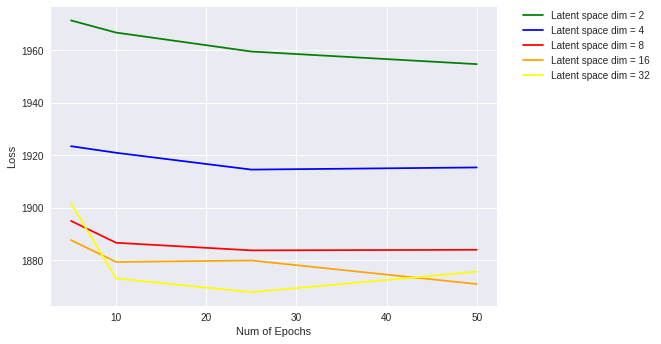

In [30]:
epoch = epochss
lat2 = see[0:4]
lat4 = see[4:8]
lat8 = see[8:12]
lat16 = see[12:16]
lat32 = see[16:]
print(lat2)
print(lat8)

plt.plot(epoch, lat2, color='g', label="Latent space dim = 2")
plt.plot(epoch, lat4, color='b', label="Latent space dim = 4")
plt.plot(epoch, lat8, color='red', label="Latent space dim = 8")
plt.plot(epoch, lat16, color='orange', label="Latent space dim = 16")
plt.plot(epoch, lat32, color='yellow', label="Latent space dim = 32")

plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# year = [1960, 1970, 1980, 1990, 2000, 2010]
# pop_pakistan = [44.91, 58.09, 78.07, 107.7, 138.5, 170.6]
# pop_india = [449.48, 553.57, 696.783, 870.133, 1000.
# 4, 1309.1]
# plt.plot(year, pop_pakistan, color='g')
# plt.plot(year, pop_india, color='orange')
# plt.xlabel('Countries')
# plt.ylabel('Population in million')
# plt.title('Pakistan India Population till 2010')
# plt.show()

In [0]:
def visualize_closest(latent_point, axis1, axis2, step):
    n = 3
    #img_size = 32
    figure = np.zeros((SIZE[0] * 3, SIZE[1] * 3, 3))

    for i in range(-1, 2):
        for j in range(-1, 2):
            temp = latent_point
            temp[axis1] += i*step
            temp[axis2] += j * step
            x_decoded = generator.predict(np.array([temp]))
            print(x_decoded)
            img = x_decoded[0].reshape(SIZE)
            #img *= 255
            #print(img)
            figure[(i+1) * SIZE[0]: (i + 2) * SIZE[0], (j+1) * SIZE[1]: (j + 2) * SIZE[1]] = img

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()

In [0]:
for index, y in enumerate(y_train):
  if (y == 4):
    print(index)

In [81]:
lat1, lat2 = encoder.predict(x_train[49984:49986]) 
lat3, lat4 = encoder.predict(x_train[49981:49983]) 
#lat2 = encoder.predict(x_train[49990])
plt.imshow(x_train[49984].reshape(SIZE))
plt.show()
visualize_closest(lat1, 1, 3, 0.5)
plt.imshow(x_train[49981].reshape(SIZE))
plt.show()
visualize_closest(lat3, 1, 3, 0.1)
print(x_train.shape)

ValueError: ignored

In [88]:
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.
to_fit_generator = x_train[:10002]
vae_y = y_train[:10000]
SIZE = (32,32,3)
print(to_fit_generator.shape)
def generate_images_vae( x_train_part, y_train_part = vae_y, image_num = 10000):
  generated_res = np.zeros((image_num, 32, 32, 3))
  gen_y = []
  per_image = int(image_num/len(x_train_part))
  print("per image {} generated".format(per_image))
  step = 0.3
  count = 0
  for index in range(len(x_train_part)-2):
      
      latent_point, st = encoder.predict(x_train_part[index:index+2])
      axis1 = 1
      axis2 = 3
      for i in range(-1, 2):
            for j in range(-1, 2):
                if (i != 0 and j != 0 and count < image_num):
                  gen_y.append(y_train_part[index])
                  temp = latent_point
                  temp[axis1] += i*step
                  temp[axis2] += j * step
                  #print(temp)
                  #print(temp.shape)
                  x_decoded = generator.predict(np.array([temp]))
                  #print(x_decoded)
                  img = x_decoded[0].reshape(SIZE)
                  generated_res[count] = img
                  #img *= 255
                  #print(img)
  #                 figure[(i+1) * SIZE[0]: (i + 2) * SIZE[0], (j+1) * SIZE[1]: (j + 2) * SIZE[1]] = img
                  count += 1
  return generated_res, np.asarray(gen_y)


#fake, labels_fake = generate_images_vae(10000)
#print(fake.shape)  
#print(labels_fake.shape) 

(10002, 3072)


In [89]:
print(temp_x_train.shape)
print(temp_x_train[:int(num_images*ratio/4)+2,].shape)
fake, sampled_labels = generate_images_vae(temp_x_train[:int(num_images*ratio/4)+2,],vae_y, int(num_images*ratio))

(50000, 3072)
(27, 3072)
per image 3 generated
